# Energy Analysis
We will be using the new energy layer to analyze a variety of PV module futures.

We will use a literture-sourced global scale deployment schedule through 2050, then assume that capacity increases at a lower constant rate through 2100.

Module specific module and material input files are stored in the baselines\Energy_CellModuleTechCompare folder.

In [1]:
import numpy as np
import pandas as pd
import os,sys
from pathlib import Path
import matplotlib.pyplot as plt

import PV_ICE

cwd = os.getcwd() #grabs current working directory

testfolder = str(Path().resolve().parent.parent / 'PV_ICE' / 'TEMP' / 'EnergyAnalysis')
inputfolder = str(Path().resolve().parent.parent / 'PV_ICE' / 'TEMP')
baselinesfolder = str(Path().resolve().parent.parent /'PV_ICE' / 'baselines')
supportMatfolder = str(Path().resolve().parent.parent / 'PV_ICE' / 'baselines' / 'SupportingMaterial')
altBaselinesfolder = str(Path().resolve().parent.parent / 'PV_ICE' / 'baselines' / 'Energy_CellModuleTechCompare')

if not os.path.exists(testfolder):
    os.makedirs(testfolder)

In [2]:
from platform import python_version 
print(python_version())

3.11.5


In [122]:
#print("Working on a ", platform.system(), platform.release())
print("Python version ", sys.version)
print("Pandas version ", pd.__version__)
print("pyplot ", plt.matplotlib.__version__)
print("PV_ICe version ", PV_ICE.__version__)

Python version  3.11.5 | packaged by Anaconda, Inc. | (main, Sep 11 2023, 13:26:23) [MSC v.1916 64 bit (AMD64)]
Pandas version  2.0.3
pyplot  3.7.2
PV_ICe version  


Graphing settings

In [3]:
#https://www.learnui.design/tools/data-color-picker.html#palette
#color pallette - modify here for all graphs below
colorpalette=['#000000', #PV ICE baseline
              '#595959', '#7F7F7F', '#A6A6A6', '#D9D9D9', #BAU, 4 grays, perc, shj, topcon, irena
              #'#067872','#0aa39e','#09d0cd','#00ffff', #realistic cases (4) teals, perc, shj, topcon, irena
              '#0579C1','#C00000','#FFC000', #extreme cases (3) long life, high eff, circular
                '#6E30A0','#00B3B5','#10C483', #ambitious modules (5) high eff+ long life, 50 yr perc, recycleSi, 
               '#97CB3F','#FF7E00' #circular perovskite+life, circular perovkiste+ high eff
                ] 

colormats = ['#00bfbf','#ff7f0e','#1f77be','#2ca02c','#d62728','#9467BD','#8C564B'] #colors for material plots       

import matplotlib as mpl #import matplotlib
from cycler import cycler #import cycler
mpl.rcParams['axes.prop_cycle'] = cycler(color=colorpalette) #reset the default color palette of mpl

from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

plt.rcParams.update({'font.size': 14})
plt.rcParams['figure.figsize'] = (8, 6)

scennames_labels = ['PV_ICE','PERC','SHJ','TOPCon','Low\nQuality',
                         'Long-Lived','High Eff','Circular',
                        'High Eff\n+ Long-life','Long-Life\n+ Recycling',
                         'Recycled-Si\n+ Long-life','Circular\n+ Long-life',
                        'Circular\n+ High Eff'
                    ]  

scennames_labels_flat = ['PV_ICE','PERC','SHJ','TOPCon','Low Quality',
                         'Long-Lived','High Eff','Circular',
                        'High Eff + Long-life','Long-Life + Recycling',
                         'Recycled-Si + Long-life','Circular + Long-life',
                        'Circular + High Eff'
                    ] 
#,'Lightweight'


Scenarios and materials

In [4]:
MATERIALS = ['glass', 'silicon', 'silver', 'aluminium_frames', 'copper', 'encapsulant', 'backsheet']
moduleFile_m = os.path.join(baselinesfolder, 'baseline_modules_mass_US.csv')
moduleFile_e = os.path.join(baselinesfolder, 'baseline_modules_energy.csv')

We will be deploying based on power (not area) because each of these have different efficiencies, and those differences should be accounted for in the simulation. Additionally, we will run the installation compensation to simulate the required replacements for each module type.

In [6]:
#load in a baseline and materials for modification
sim1 = PV_ICE.Simulation(name='sim1', path=testfolder)

sim1.createScenario(name='PV_ICE', massmodulefile=moduleFile_m, energymodulefile=moduleFile_e)
for mat in range (0, len(MATERIALS)):
    matbaseline_m = os.path.join(baselinesfolder,'baseline_material_mass_'+MATERIALS[mat]+'.csv')
    matbaseline_e = os.path.join(baselinesfolder,'baseline_material_energy_'+MATERIALS[mat]+'.csv')
    sim1.scenario['PV_ICE'].addMaterial(MATERIALS[mat], massmatfile=matbaseline_m, energymatfile=matbaseline_e)


path = C:\Users\hmirletz\Documents\GitHub\PV_ICE\PV_ICE\TEMP\EnergyAnalysis
Baseline folder directed to default:  C:\Users\hmirletz\Documents\GitHub\PV_ICE\PV_ICE\baselines


# 1. Module & Scenario Creation
Starting modifications in 2022, using PV ICE baseline as historical for all modules

**NOTE: Currently have to modify all scenarios before extending the years to avoid errors.**

**NOTE: all dynamic values changed with PV ICE modify functions must feed in a Pandas Series**

In [7]:
celltech_modeff = pd.read_csv(os.path.join(supportMatfolder, 'output-celltech-modeffimprovements.csv'),index_col=0) #pull in module eff
celltech_aguse = pd.read_csv(os.path.join(supportMatfolder, 'output-celltech-Agusageimprovements.csv'),index_col=0) #pull in Ag use

In [8]:
celltech_modeff.loc[2030]

PERC      24.5
SHJ       25.3
TOPCon    25.0
Name: 2030, dtype: float64

In [9]:
#glass-glass package mass per area calculation
#ITRPV 2022 Figs 36 and 38, we are assuming that the front and back glass heave equal thickness of 2.5mm
density_glass = 2500*1000 # g/m^3 
glassperm2 = (2.5/1000)* 2 * density_glass
print('The mass per module area of glass is '+str(glassperm2)+' g/m^2 for all modules with a glass-glass package')

The mass per module area of glass is 12500.0 g/m^2 for all modules with a glass-glass package


In [10]:
timeshift = 2022-1995

In [11]:
idx_temp = pd.RangeIndex(start=2000,stop=2051,step=1)

## 1.1 Business as Usual
Commercialized Modules with Expected Continued Improvement
- PERC
- SHJ
- TOPCon
- IRENA reg. loss/mc-Si/vintage modules

For all these modules, we assume improving recycling slightly behind the EU WEEE Directive:
- 2022: 15% collection, 75% recycled module, 100% downcycled glass, 100% HQ al frames, 20% closed loop
- 2030: 30% collection, 80% recycled module, 30% closed-loop glass, 30% closed-loop silicon, 30% closed-loop silver, 50% closed loop Al frames
- 2050: 75% collection, 95% recycled module, 75% closed loop recycled glass, 75% closed loop recycled silicon, 75% closed-loop silver, 100% closed loop al frames

### 1.1.1 PERC

In [12]:
#modified module
moduleinput_m_r_PERC = os.path.join(altBaselinesfolder, 'mod_r_PERC.csv')
sim1.createScenario(name='r_PERC', massmodulefile=moduleinput_m_r_PERC, energymodulefile=moduleFile_e) 

In [13]:
#module efficiency modify for PERC
sim1.modifyScenario('r_PERC', 'mod_eff', celltech_modeff.loc[2022:,'PERC'], start_year=2022) #changing module eff
#sim1.scenario['SHJ'].dataIn_m.loc[timeshift:,'mod_eff'] = celltech_modeff.loc[2022:,'SHJ'].values

In [14]:
#modified materials
#glass
matinput_glass_m_improvedRecycle = os.path.join(altBaselinesfolder,'material_mass_glass_improvedRecycle.csv')
matbaseline_e_glass = os.path.join(baselinesfolder,'baseline_material_energy_glass.csv')
sim1.scenario['r_PERC'].addMaterial('glass', massmatfile=matinput_glass_m_improvedRecycle, energymatfile=matbaseline_e_glass)
#silicon
matinput_silicon_m_improvedRecycle = os.path.join(altBaselinesfolder,'material_mass_silicon_improvedRecycle.csv')
matbaseline_e_si = os.path.join(baselinesfolder,'baseline_material_energy_silicon.csv')
sim1.scenario['r_PERC'].addMaterial('silicon', massmatfile=matinput_silicon_m_improvedRecycle, energymatfile=matbaseline_e_si)
#silver
matinput_silver_m_improvedRecycle = os.path.join(altBaselinesfolder,'material_mass_silver_improvedRecycle.csv')
matbaseline_e_ag = os.path.join(baselinesfolder,'baseline_material_energy_silver.csv')
sim1.scenario['r_PERC'].addMaterial('silver', massmatfile=matinput_silver_m_improvedRecycle, energymatfile=matbaseline_e_ag)
#aluminium frames
matinput_Al_m_improvedRecycle = os.path.join(altBaselinesfolder,'material_mass_aluminium_frames_improvedRecycle.csv')
matbaseline_e_al = os.path.join(baselinesfolder,'baseline_material_energy_aluminium_frames.csv')
sim1.scenario['r_PERC'].addMaterial('aluminium_frames', massmatfile=matinput_Al_m_improvedRecycle, energymatfile=matbaseline_e_al)

#standard materials
baselineMats=['copper', 'encapsulant', 'backsheet']
for mats in range (0, len(baselineMats)):
    matbaseline_m = os.path.join(baselinesfolder,'baseline_material_mass_'+baselineMats[mats]+'.csv')
    matbaseline_e = os.path.join(baselinesfolder,'baseline_material_energy_'+baselineMats[mats]+'.csv')
    sim1.scenario['r_PERC'].addMaterial(baselineMats[mats], massmatfile=matbaseline_m, energymatfile=matbaseline_e)

In [15]:
#modify silver usage for PERC
sim1.scenario['r_PERC'].modifyMaterials('silver', 'mat_massperm2', celltech_aguse.loc[2022:,'PERC'], start_year=2022)

In [16]:
#modify package to glass glass
sim1.scenario['r_PERC'].modifyMaterials('glass', 'mat_massperm2', glassperm2, start_year=2022)
sim1.scenario['r_PERC'].modifyMaterials('backsheet', 'mat_massperm2', 0.0, start_year=2022) #

### 1.1.2 SHJ
This is a modern SHJ module with expected silver and module efficiency improvements taken from Zhang et al 2021, Gervais et al 2021, and ITPRV 2022. See PERC vs SHJ vs TOPCon for a more detailed evaluation.

In [17]:
#modified module
moduleinput_m_r_SHJ = os.path.join(altBaselinesfolder, 'mod_r_SHJ.csv')
sim1.createScenario(name='r_SHJ', massmodulefile=moduleinput_m_r_SHJ, energymodulefile=moduleFile_e) 

In [18]:
#module efficiency modify for SHJ
sim1.modifyScenario('r_SHJ', 'mod_eff', celltech_modeff.loc[2022:,'SHJ'], start_year=2022) #changing module eff
#sim1.scenario['SHJ'].dataIn_m.loc[timeshift:,'mod_eff'] = celltech_modeff.loc[2022:,'SHJ'].values

In [19]:
#load modified materials
#modified materials
#glass
matinput_glass_m_improvedRecycle = os.path.join(altBaselinesfolder,'material_mass_glass_improvedRecycle.csv')
matbaseline_e_glass = os.path.join(baselinesfolder,'baseline_material_energy_glass.csv')
sim1.scenario['r_SHJ'].addMaterial('glass', massmatfile=matinput_glass_m_improvedRecycle, energymatfile=matbaseline_e_glass)
#silicon
matinput_silicon_m_improvedRecycle = os.path.join(altBaselinesfolder,'material_mass_silicon_improvedRecycle.csv')
matbaseline_e_si = os.path.join(baselinesfolder,'baseline_material_energy_silicon.csv')
sim1.scenario['r_SHJ'].addMaterial('silicon', massmatfile=matinput_silicon_m_improvedRecycle, energymatfile=matbaseline_e_si)
#silver
matinput_silver_m_improvedRecycle = os.path.join(altBaselinesfolder,'material_mass_silver_improvedRecycle.csv')
matbaseline_e_ag = os.path.join(baselinesfolder,'baseline_material_energy_silver.csv')
sim1.scenario['r_SHJ'].addMaterial('silver', massmatfile=matinput_silver_m_improvedRecycle, energymatfile=matbaseline_e_ag)
#aluminium frames
matinput_Al_m_improvedRecycle = os.path.join(altBaselinesfolder,'material_mass_aluminium_frames_improvedRecycle.csv')
matbaseline_e_al = os.path.join(baselinesfolder,'baseline_material_energy_aluminium_frames.csv')
sim1.scenario['r_SHJ'].addMaterial('aluminium_frames', massmatfile=matinput_Al_m_improvedRecycle, energymatfile=matbaseline_e_al)

#standard materials
baselineMats=['copper', 'encapsulant', 'backsheet']
for mats in range (0, len(baselineMats)):
    matbaseline_m = os.path.join(baselinesfolder,'baseline_material_mass_'+baselineMats[mats]+'.csv')
    matbaseline_e = os.path.join(baselinesfolder,'baseline_material_energy_'+baselineMats[mats]+'.csv')
    sim1.scenario['r_SHJ'].addMaterial(baselineMats[mats], massmatfile=matbaseline_m, energymatfile=matbaseline_e)

In [20]:
#modify silver usage for SHJ
sim1.scenario['r_SHJ'].modifyMaterials('silver', 'mat_massperm2', celltech_aguse.loc[2022:,'SHJ'], start_year=2022)

In [21]:
#modify package to glass glass
sim1.scenario['r_SHJ'].modifyMaterials('glass', 'mat_massperm2', glassperm2, start_year=2022)
sim1.scenario['r_SHJ'].modifyMaterials('backsheet', 'mat_massperm2', 0.0, start_year=2022) #

### 1.1.3 TOPCon

In [22]:
#modified module
moduleinput_m_r_TOPCon = os.path.join(altBaselinesfolder, 'mod_r_TOPCon.csv')
sim1.createScenario(name='r_TOPCon', massmodulefile=moduleinput_m_r_TOPCon, energymodulefile=moduleFile_e) 

In [23]:
#module efficiency modify
sim1.modifyScenario('r_TOPCon', 'mod_eff', celltech_modeff.loc[2022:,'TOPCon'], start_year=2022) #changing module eff
#sim1.scenario['SHJ'].dataIn_m.loc[timeshift:,'mod_eff'] = celltech_modeff.loc[2022:,'SHJ'].values

In [24]:
#modified materials
#glass
matinput_glass_m_improvedRecycle = os.path.join(altBaselinesfolder,'material_mass_glass_improvedRecycle.csv')
matbaseline_e_glass = os.path.join(baselinesfolder,'baseline_material_energy_glass.csv')
sim1.scenario['r_TOPCon'].addMaterial('glass', massmatfile=matinput_glass_m_improvedRecycle, energymatfile=matbaseline_e_glass)
#silicon
matinput_silicon_m_improvedRecycle = os.path.join(altBaselinesfolder,'material_mass_silicon_improvedRecycle.csv')
matbaseline_e_si = os.path.join(baselinesfolder,'baseline_material_energy_silicon.csv')
sim1.scenario['r_TOPCon'].addMaterial('silicon', massmatfile=matinput_silicon_m_improvedRecycle, energymatfile=matbaseline_e_si)
#silver
matinput_silver_m_improvedRecycle = os.path.join(altBaselinesfolder,'material_mass_silver_improvedRecycle.csv')
matbaseline_e_ag = os.path.join(baselinesfolder,'baseline_material_energy_silver.csv')
sim1.scenario['r_TOPCon'].addMaterial('silver', massmatfile=matinput_silver_m_improvedRecycle, energymatfile=matbaseline_e_ag)
#aluminium frames
matinput_Al_m_improvedRecycle = os.path.join(altBaselinesfolder,'material_mass_aluminium_frames_improvedRecycle.csv')
matbaseline_e_al = os.path.join(baselinesfolder,'baseline_material_energy_aluminium_frames.csv')
sim1.scenario['r_TOPCon'].addMaterial('aluminium_frames', massmatfile=matinput_Al_m_improvedRecycle, energymatfile=matbaseline_e_al)

#standard materials
baselineMats=['copper', 'encapsulant', 'backsheet']
for mats in range (0, len(baselineMats)):
    matbaseline_m = os.path.join(baselinesfolder,'baseline_material_mass_'+baselineMats[mats]+'.csv')
    matbaseline_e = os.path.join(baselinesfolder,'baseline_material_energy_'+baselineMats[mats]+'.csv')
    sim1.scenario['r_TOPCon'].addMaterial(baselineMats[mats], massmatfile=matbaseline_m, energymatfile=matbaseline_e)

In [25]:
#modify silver usage for PERC
sim1.scenario['r_TOPCon'].modifyMaterials('silver', 'mat_massperm2', celltech_aguse.loc[2022:,'TOPCon'], start_year=2022)

In [26]:
#modify package to glass glass
sim1.scenario['r_TOPCon'].modifyMaterials('glass', 'mat_massperm2', glassperm2, start_year=2022)
sim1.scenario['r_TOPCon'].modifyMaterials('backsheet', 'mat_massperm2', 0.0, start_year=2022) #

### 1.1.4 IRENA Reg. Loss with improved recycling
This scenario uses the IRENA 2016 regular loss scenario results, or a low quality module, and assumes the same EoL recycling improvement as the previous three scenarios. We're assuming this is a mc-Si, therefore, changing the ingot energy to reflect the lower energy intensity.

In [27]:
#modified module
moduleinput_m_r_IRENA = os.path.join(altBaselinesfolder, 'mod_r_IRENAregloss.csv')
sim1.createScenario(name='r_IRENA', massmodulefile=moduleinput_m_r_IRENA, energymodulefile=moduleFile_e) 

In [28]:
#modified materials
#glass
matinput_glass_m_improvedRecycle = os.path.join(altBaselinesfolder,'material_mass_glass_improvedRecycle.csv')
matbaseline_e_glass = os.path.join(baselinesfolder,'baseline_material_energy_glass.csv')
sim1.scenario['r_IRENA'].addMaterial('glass', massmatfile=matinput_glass_m_improvedRecycle, energymatfile=matbaseline_e_glass)
#silicon
matinput_silicon_m_improvedRecycle = os.path.join(altBaselinesfolder,'material_mass_silicon_improvedRecycle.csv')
matbaseline_e_si = os.path.join(baselinesfolder,'baseline_material_energy_silicon.csv')
sim1.scenario['r_IRENA'].addMaterial('silicon', massmatfile=matinput_silicon_m_improvedRecycle, energymatfile=matbaseline_e_si)
#silver
matinput_silver_m_improvedRecycle = os.path.join(altBaselinesfolder,'material_mass_silver_improvedRecycle.csv')
matbaseline_e_ag = os.path.join(baselinesfolder,'baseline_material_energy_silver.csv')
sim1.scenario['r_IRENA'].addMaterial('silver', massmatfile=matinput_silver_m_improvedRecycle, energymatfile=matbaseline_e_ag)
#aluminium frames
matinput_Al_m_improvedRecycle = os.path.join(altBaselinesfolder,'material_mass_aluminium_frames_improvedRecycle.csv')
matbaseline_e_al = os.path.join(baselinesfolder,'baseline_material_energy_aluminium_frames.csv')
sim1.scenario['r_IRENA'].addMaterial('aluminium_frames', massmatfile=matinput_Al_m_improvedRecycle, energymatfile=matbaseline_e_al)

#standard materials
baselineMats=['copper', 'encapsulant', 'backsheet']
for mats in range (0, len(baselineMats)):
    matbaseline_m = os.path.join(baselinesfolder,'baseline_material_mass_'+baselineMats[mats]+'.csv')
    matbaseline_e = os.path.join(baselinesfolder,'baseline_material_energy_'+baselineMats[mats]+'.csv')
    sim1.scenario['r_IRENA'].addMaterial(baselineMats[mats], massmatfile=matbaseline_m, energymatfile=matbaseline_e)

In [29]:
#modify silicon mfging energy to be mc-Si only
altmfgSi_mcSi = pd.read_csv(os.path.join(supportMatfolder, 'output_energy_silicon_MFG_mcSi.csv'), index_col=0)
#modify silicon recycling energy
sim1.scenario['r_IRENA'].modifyMaterialEnergy('silicon', 'e_mat_MFG', 
                                              altmfgSi_mcSi.loc[2022:,'E_MFG_kWhpkg'], start_year=2022)
sim1.scenario['r_IRENA'].modifyMaterialEnergy('silicon', 'e_mat_MFG_fuelfraction', 
                                              altmfgSi_mcSi.loc[2022:,'E_mfgFuelFraction'], start_year=2022)


In [30]:
sim1.scenario['r_IRENA'].material['silicon'].matdataIn_e.iloc[25:30,]

year  e_mat_extraction   e_mat_MFG  e_mat_MFG_fuelfraction  \
25  2020            0.0062  169.060000               22.000000   
26  2021            0.0062  170.730000               21.000000   
27  2022            0.0062  144.532276                0.236169   
28  2023            0.0062  144.418207                0.236356   
29  2024            0.0062  144.304139                0.236542   

    e_mat_MFGScrap_LQ  e_mat_MFGScrap_HQ  e_mat_Landfill  \
25                1.6             138.38            0.09   
26                1.6             143.04            0.09   
27                1.6             144.33            0.09   
28                1.6             144.20            0.09   
29                1.6             144.60            0.09   

    e_mat_Landfill_fuelfraction  e_mat_EoL_ReMFG_clean  e_mat_Recycled_LQ  \
25                            0                    0.4                1.6   
26                            0                    0.4                1.6   
27                            0                    0.4                1.6   
28                            0                    0.4                1.6   
29                            0                    0.4                1.6   

    e_mat_Recycled_HQ  e_mat_Recycled_HQ_fuelfraction  
25             138.38                              20  
26             143.04                              19  
27             144.33                              19  
28             144.20                              19  
29             144.60                              19

## 1.2 Extreme modules
What if you could have 1/3 design aspects perfectly optimized right now, but at the expense of the other two?

In [31]:
#names for extreme set of scenarios
scennames_ex = ['ex_Life', 'ex_High_eff', 'ex_Circular'] #extreme boundaries

In [32]:
for scen in scennames_ex:  #creates extreme scenarios
    sim1.createScenario(name=scen, massmodulefile=moduleFile_m, energymodulefile=moduleFile_e)
    for mat in range (0, len(MATERIALS)):
        matbaseline_m = os.path.join(baselinesfolder,'baseline_material_mass_'+MATERIALS[mat]+'.csv')
        matbaseline_e = os.path.join(baselinesfolder,'baseline_material_energy_'+MATERIALS[mat]+'.csv')
        sim1.scenario[scen].addMaterial(MATERIALS[mat], massmatfile=matbaseline_m, energymatfile=matbaseline_e)

### 1.2.1 Extreme Lifetime - 50 year module
This module represents current PERC technology if it were to have it's lifetime extended significantly. Glass-glass technology is assumed, expected decreases in silver usage and increases in module efficiency are derived from Zhang et al 2021, Gervais et al 2021 and ITRPV 2022. Merchant tail is set to 100%, while material circularity is set to 0 after 2022.

In [33]:
#module efficiency modify for PERC
#evolves at the same rate as the baseline comparison
sim1.modifyScenario('ex_Life', 'mod_eff', celltech_modeff.loc[2022:,'PERC'], start_year=2022) #PERC 2030 module eff

In [34]:
#silver modify for PERC
sim1.scenario['ex_Life'].modifyMaterials('silver', 'mat_massperm2', celltech_aguse.loc[2022:,'PERC'], start_year=2022)
#old way
#sim1.scenario['PERC_50'].material['silver'].matdataIn_m.loc[timeshift:,'mat_massperm2'] = celltech_aguse.loc[2022:,'PERC'].values

In [35]:
#modify package to glass glass
sim1.scenario['ex_Life'].modifyMaterials('glass', 'mat_massperm2', glassperm2, start_year=2022) #
sim1.scenario['ex_Life'].modifyMaterials('backsheet', 'mat_massperm2', 0.0, start_year=2022) #

In [36]:
#Lifetime and Degradation
#degradation rate from Theristis et al 2022
#failure is T10 at 50 years
#degradation rate:
sim1.modifyScenario('ex_Life', 'mod_degradation', 0.4, start_year=2022) #annual power degradation to reach 80% at 55 yrs
#T50
sim1.modifyScenario('ex_Life', 'mod_reliability_t50', 56.07, start_year=2022)
#t90
sim1.modifyScenario('ex_Life', 'mod_reliability_t90', 59.15, start_year=2022) 
#Mod Project Lifetime
sim1.modifyScenario('ex_Life', 'mod_lifetime', 50, start_year=2022) #project lifetime of 50 years


In [37]:
#Merchant Tail set high
sim1.modifyScenario('ex_Life', 'mod_MerchantTail', 100, start_year=2022) #all installations stay for merchant tail

#Set to no material circularity after 2022
sim1.modifyScenario('ex_Life', 'mod_EOL_collection_eff', 0.0, start_year=2022)
for mat in sim1.scenario['ex_Life'].material:
        sim1.scenario['ex_Life'].modifyMaterials(mat, 'mat_MFG_scrap_Recycled', 0.0, start_year=2022) #        

### 1.2.2 Extreme High Efficiency
This represents a current 25 year lifetime module warranty where efficiency has been prioritized. This could represent a silicon based tandem, along the lines of a heterojunction, multijunction or tandem structure. This will also be assumed to be bifacial at 0.92, the highest projection from ITRPV 2023.

In [38]:
sim1.modifyScenario('ex_High_eff', 'mod_eff', 30.0, start_year=2022) #changing module eff

In [39]:
#Lifetime and Degradation
#degradation rate:
sim1.modifyScenario('ex_High_eff', 'mod_degradation', 0.75, start_year=2022) #standard current degrdation
#T50
sim1.modifyScenario('ex_High_eff', 'mod_reliability_t50', 30.7, start_year=2022)
#t90
sim1.modifyScenario('ex_High_eff', 'mod_reliability_t90', 35, start_year=2022) 
#Mod Project Lifetime
sim1.modifyScenario('ex_High_eff', 'mod_lifetime', 25, start_year=2022) #project lifetime of 25 years

In [40]:
#modify package to glass glass
sim1.scenario['ex_High_eff'].modifyMaterials('glass', 'mat_massperm2', glassperm2, start_year=2022)
sim1.scenario['ex_High_eff'].modifyMaterials('backsheet', 'mat_massperm2', 0.0, start_year=2022) #

In [41]:
#Set to no material circularity after 2022
sim1.modifyScenario('ex_High_eff', 'mod_EOL_collection_eff', 0.0, start_year=2022)
for mat in sim1.scenario['ex_High_eff'].material:
        sim1.scenario['ex_High_eff'].modifyMaterials(mat, 'mat_MFG_scrap_Recycled', 0.0, start_year=2022) #    

### 1.2.3 Extreme Circular 
There are currently no circular modules, so this extreme case is based on hypothetical perovskite Si tandems modules. This module uses current best perovskite si tandem module and cell efficiencies, has a prospective life of 15 years and 1.47% degradation rate, and is highly circular. This is the extreme module proposed by perovskite tandems [Jean et al. 2019]. This maximizes material circularity, through remanufacturing glass and silicon wafers, and recycling the al frames closed loop.

In [42]:
#2022 module eff = 17.9% #https://www.nrel.gov/pv/assets/pdfs/champion-module-efficiencies-rev220401b.pdf
#2050 module eff = 19.1-26.1% for cheap on mc-Si, 21-27.3% for high eff on SHJ, Sofia et al 2019
idx_perovskite_eff = pd.RangeIndex(start=2022,stop=2051,step=1) #create the index
df_perovskite_eff = pd.DataFrame(index=idx_perovskite_eff, columns=['mod_eff_p'], dtype=float)
df_perovskite_eff.loc[2022] = 17.9 #current champion mini module
df_perovskite_eff.loc[2030] = 19.1 #using the low efficiency, cheap and circular plan
df_perovskite_eff.loc[2050] = 19.1
df_perovskite_eff.interpolate(inplace=True)

In [43]:
#module efficiency modify for PERC
sim1.modifyScenario('ex_Circular', 'mod_eff', df_perovskite_eff.loc[2022:,'mod_eff_p'], start_year=2022) 

In [44]:
#modify package to glass glass
sim1.scenario['ex_Circular'].modifyMaterials('glass', 'mat_massperm2', glassperm2, start_year=2022)
sim1.scenario['ex_Circular'].modifyMaterials('backsheet', 'mat_massperm2', 0.0, start_year=2022) #

In [45]:
#Lifetime and Degradation
#values taken from lifetime vs recycling paper
#degradation rate:
sim1.modifyScenario('ex_Circular', 'mod_degradation', 1.47, start_year=2022) #annual power degradation
#Mod Project Lifetime
sim1.modifyScenario('ex_Circular', 'mod_lifetime', 15, start_year=2022) #project lifetime of 15 years
#T50
sim1.modifyScenario('ex_Circular', 'mod_reliability_t50', 20.49, start_year=2022)
#t90
sim1.modifyScenario('ex_Circular', 'mod_reliability_t90', 25, start_year=2022) 

In [46]:
#remfg glass, remfg si, recycle Al, near perfect levels
#100% collection rate
sim1.modifyScenario('ex_Circular', 'mod_EOL_collection_eff', 100.0, start_year=2022) #100% collection

# remanufacturing
sim1.modifyScenario('ex_Circular', 'mod_EOL_pg3_reMFG', 100.0, start_year=2022) #all modules attempt remfg
sim1.modifyScenario('ex_Circular', 'mod_EOL_sp_reMFG_recycle', 100.0, start_year=2022) # recycle if can't remfg
sim1.modifyScenario('ex_Circular', 'mod_EOL_pb3_reMFG', 100.0, start_year=2022) # remfg bad mods too
sim1.modifyScenario('ex_Circular', 'mod_EOL_reMFG_yield', 98.0, start_year=2022) # REMFG YIELD 98%

#set all other paths to 0
sim1.modifyScenario('ex_Circular', 'mod_EOL_pg0_resell', 0.0, start_year=2022) # 
sim1.modifyScenario('ex_Circular', 'mod_EOL_pg1_landfill', 0.0, start_year=2022) # 
sim1.modifyScenario('ex_Circular', 'mod_EOL_pg2_stored', 0.0, start_year=2022) #
sim1.modifyScenario('ex_Circular', 'mod_EOL_pg4_recycled', 0.0, start_year=2022) # 
sim1.modifyScenario('ex_Circular', 'mod_EOL_pb1_landfill', 0.0, start_year=2022) # 
sim1.modifyScenario('ex_Circular', 'mod_EOL_pb2_stored', 0.0, start_year=2022) # 
sim1.modifyScenario('ex_Circular', 'mod_EOL_pb4_recycled', 0.0, start_year=2022) # 
sim1.modifyScenario('ex_Circular', 'mod_Repair', 0.0, start_year=2022) #
sim1.modifyScenario('ex_Circular', 'mod_MerchantTail', 0.0, start_year=2022) #


#Material Remanufacture
#Glass
#mfg scrap
sim1.scenario['ex_Circular'].modifyMaterials('glass', 'mat_MFG_scrap_Recycled', 100.0, start_year=2022) #send mfg scrap to recycle
sim1.scenario['ex_Circular'].modifyMaterials('glass', 'mat_MFG_scrap_Recycling_eff', 98.0, start_year=2022) #98% yield
sim1.scenario['ex_Circular'].modifyMaterials('glass', 'mat_MFG_scrap_Recycled_into_HQ', 100.0, start_year=2022) #all HQ
sim1.scenario['ex_Circular'].modifyMaterials('glass', 'mat_MFG_scrap_Recycled_into_HQ_Reused4MFG', 100.0, start_year=2022) #closed-loop
#eol
sim1.scenario['ex_Circular'].modifyMaterials('glass', 'mat_PG3_ReMFG_target', 100.0, start_year=2022) #send all to remfg
sim1.scenario['ex_Circular'].modifyMaterials('glass', 'mat_PG4_Recycling_target', 100.0, start_year=2022) #any breakage gets recycled
sim1.scenario['ex_Circular'].modifyMaterials('glass', 'mat_ReMFG_yield', 98.0, start_year=2022) #98% yeild
sim1.scenario['ex_Circular'].modifyMaterials('glass', 'mat_Recycling_yield', 98.0, start_year=2022) #98% yeild


#silicon ReMFG 
#mfg scrap
sim1.scenario['ex_Circular'].modifyMaterials('silicon', 'mat_MFG_scrap_Recycled', 100.0, start_year=2022) #send mfg scrap to recycle
sim1.scenario['ex_Circular'].modifyMaterials('silicon', 'mat_MFG_scrap_Recycling_eff', 98.0, start_year=2022) #98% yield
sim1.scenario['ex_Circular'].modifyMaterials('silicon', 'mat_MFG_scrap_Recycled_into_HQ', 100.0, start_year=2022) #all HQ
sim1.scenario['ex_Circular'].modifyMaterials('silicon', 'mat_MFG_scrap_Recycled_into_HQ_Reused4MFG', 100.0, start_year=2022) #closed-loop
#eol
sim1.scenario['ex_Circular'].modifyMaterials('silicon', 'mat_PG3_ReMFG_target', 100.0, start_year=2022) #send to remfg
sim1.scenario['ex_Circular'].modifyMaterials('silicon', 'mat_ReMFG_yield', 98.0, start_year=2022) #98% yeild
sim1.scenario['ex_Circular'].modifyMaterials('silicon', 'mat_PG4_Recycling_target', 100.0, start_year=2022) #remfg breakage gets recycled
sim1.scenario['ex_Circular'].modifyMaterials('silicon', 'mat_Recycling_yield', 98.0, start_year=2022) #99% yeild
sim1.scenario['ex_Circular'].modifyMaterials('silicon', 'mat_EOL_Recycled_into_HQ', 100.0, start_year=2022) #all HQ
sim1.scenario['ex_Circular'].modifyMaterials('silicon', 'mat_EOL_RecycledHQ_Reused4MFG', 100.0, start_year=2022) #closed-loop


#aluminium_frames recycle
#mfg scrap
sim1.scenario['ex_Circular'].modifyMaterials('aluminium_frames', 'mat_MFG_scrap_Recycled', 100.0, start_year=2022) #send mfg scrap to recycle
sim1.scenario['ex_Circular'].modifyMaterials('aluminium_frames', 'mat_MFG_scrap_Recycling_eff', 98.0, start_year=2022) #98% yield
sim1.scenario['ex_Circular'].modifyMaterials('aluminium_frames', 'mat_MFG_scrap_Recycled_into_HQ', 100.0, start_year=2022) #all HQ
sim1.scenario['ex_Circular'].modifyMaterials('aluminium_frames', 'mat_MFG_scrap_Recycled_into_HQ_Reused4MFG', 100.0, start_year=2022) #closed-loop
#eol
sim1.scenario['ex_Circular'].modifyMaterials('aluminium_frames', 'mat_PG3_ReMFG_target', 0.0, start_year=2022) #send to recycle
sim1.scenario['ex_Circular'].modifyMaterials('aluminium_frames', 'mat_ReMFG_yield', 0.0, start_year=2022) #0% yeild
sim1.scenario['ex_Circular'].modifyMaterials('aluminium_frames', 'mat_PG4_Recycling_target', 100.0, start_year=2022) #send to recycle
sim1.scenario['ex_Circular'].modifyMaterials('aluminium_frames', 'mat_Recycling_yield', 98.0, start_year=2022) #99% yeild
sim1.scenario['ex_Circular'].modifyMaterials('aluminium_frames', 'mat_EOL_Recycled_into_HQ', 100.0, start_year=2022) #all HQ
sim1.scenario['ex_Circular'].modifyMaterials('aluminium_frames', 'mat_EOL_RecycledHQ_Reused4MFG', 100.0, start_year=2022) #closed-loop



## 1.3 Ambitious Hypothetical Modules

"What if we could have 2/3 design aspects improved?" These are modules which have a basis in laboratory or field but have not yet been fully/completely demonstrated or commercialized. They are the mix and match of the extreme design aspects. Typically one of the two design aspects is emphasized more heavily.
- High Eff + Long Life; 30% efficient bifacial tandem with 40 year lifetimes
- 50 year PERC module; this is the closest to an existing module, but we don't yet have 50 years worth of data to assert that this exists yet.
- Recycled Silicon PERC; this was a demonstration from Fraunhofer to recycle a silicon cell by skipping the mg-Si step, which has energy and carbon implications
- Circular + Long life Pervoskite tandems; in addition to circularizing the materials, improvements to 25 year lifetimes is made, but little improvements to efficiency.
- Circular + Efficient Perovskite tandems; instead of increasing lifetime and reliability, high efficiency is persued [Sofia] in addition to circularizing the materials

### 1.3.1 High Efficiency + Long Life
What if we made long lived tandem modules?
- Lifetime: 25-40 years
- Eff: current SHJ to 30%, 0.9
- Mod. CE: 0%
- Mat. CE: 0%

In [47]:
#modified module
moduleinput_m_r_EffLife = os.path.join(altBaselinesfolder, 'mod_r_EffLife.csv')
sim1.createScenario(name='h_EffLife', massmodulefile=moduleinput_m_r_EffLife, energymodulefile=moduleFile_e) 

#load standard materials
for mat in range (0, len(MATERIALS)):
    matbaseline_m = os.path.join(baselinesfolder,'baseline_material_mass_'+MATERIALS[mat]+'.csv')
    matbaseline_e = os.path.join(baselinesfolder,'baseline_material_energy_'+MATERIALS[mat]+'.csv')
    sim1.scenario['h_EffLife'].addMaterial(MATERIALS[mat], massmatfile=matbaseline_m, energymatfile=matbaseline_e)

In [48]:
#sim1.modifyScenario('ex_High_eff', 'mod_eff', 30.0, start_year=2022) #changing module eff
#module efficiency in the module file from 23.86 to 30% in 2040
#also lifetime and reliabiltiy in mod file, from 25-40 years in 2050

In [49]:
#modify package to glass glass
sim1.scenario['h_EffLife'].modifyMaterials('glass', 'mat_massperm2', glassperm2, start_year=2022)
sim1.scenario['h_EffLife'].modifyMaterials('backsheet', 'mat_massperm2', 0.0, start_year=2022) #

In [50]:
#Set to no material circularity after 2022
sim1.modifyScenario('h_EffLife', 'mod_EOL_collection_eff', 0.0, start_year=2022)
for mat in sim1.scenario['h_EffLife'].material:
        sim1.scenario['h_EffLife'].modifyMaterials(mat, 'mat_MFG_scrap_Recycled', 0.0, start_year=2022) # 

### 1.3.2 50-year PERC
What if long lived modules were eventually recycled?
- Lifetime: 40-50 years
- Eff: PERC 23.1%-24.5%
- Mod. CE: 75-100% merchant tail
- Mat. CE: 0-25% (collection mod * recycling target material)

In [51]:
#modified module
moduleinput_m_r_50PERC = os.path.join(altBaselinesfolder, 'mod_r_50PERC.csv')
sim1.createScenario(name='h_50PERC', massmodulefile=moduleinput_m_r_50PERC, energymodulefile=moduleFile_e) 

#load standard materials
for mat in range (0, len(MATERIALS)):
    matbaseline_m = os.path.join(baselinesfolder,'baseline_material_mass_'+MATERIALS[mat]+'.csv')
    matbaseline_e = os.path.join(baselinesfolder,'baseline_material_energy_'+MATERIALS[mat]+'.csv')
    sim1.scenario['h_50PERC'].addMaterial(MATERIALS[mat], massmatfile=matbaseline_m, energymatfile=matbaseline_e)

In [52]:
#modify package to glass glass
sim1.scenario['h_50PERC'].modifyMaterials('glass', 'mat_massperm2', glassperm2, start_year=2022)
sim1.scenario['h_50PERC'].modifyMaterials('backsheet', 'mat_massperm2', 0.0, start_year=2022) #

In [53]:
#glass recycling, 25% closed loop recycle in 2050
#create improvement series
idx_temp = pd.RangeIndex(start=2022,stop=2051,step=1) #create the index
df_glass_target = pd.DataFrame(index=idx_temp, columns=['mat_PG4_Recycling_target'], dtype=float)
df_glass_target.loc[2022] = 0
df_glass_target.loc[2030] = 100
df_glass_target.loc[2050] = 100
df_glass_target.interpolate(inplace=True)

df_glass_lowrecycle = pd.DataFrame(index=idx_temp, columns=['mat_EOL_Recycled_into_HQ'], dtype=float)
df_glass_lowrecycle.loc[2022] = 0
df_glass_lowrecycle.loc[2030] = 0
df_glass_lowrecycle.loc[2050] = 50
df_glass_lowrecycle.interpolate(inplace=True)

#eol
sim1.scenario['h_50PERC'].modifyMaterials('glass', 'mat_PG3_ReMFG_target', 0.0, start_year=2022) #send to recycle
sim1.scenario['h_50PERC'].modifyMaterials('glass', 'mat_PG4_Recycling_target', 
                                          df_glass_target.loc[2022:,'mat_PG4_Recycling_target'], start_year=2022) #send to recycle

sim1.scenario['h_50PERC'].modifyMaterials('glass', 'mat_EOL_Recycled_into_HQ', 
                                          df_glass_lowrecycle.loc[2022:,'mat_EOL_Recycled_into_HQ'], start_year=2022) #all HQ
sim1.scenario['h_50PERC'].modifyMaterials('glass', 'mat_EOL_RecycledHQ_Reused4MFG', 100.0, start_year=2022) #closed-loop


In [54]:
#silicon recycled, 25% closed loop in 2050
#create improvement series
idx_temp = pd.RangeIndex(start=2022,stop=2051,step=1) #create the index
df_si_target = pd.DataFrame(index=idx_temp, columns=['mat_PG4_Recycling_target'], dtype=float)
df_si_target.loc[2022] = 0
df_si_target.loc[2030] = 0
df_si_target.loc[2050] = 50
df_si_target.interpolate(inplace=True)

#eol
sim1.scenario['h_50PERC'].modifyMaterials('silicon', 'mat_PG3_ReMFG_target', 0.0, start_year=2022) #send to recycle
sim1.scenario['h_50PERC'].modifyMaterials('silicon', 'mat_PG4_Recycling_target', 
                                          df_si_target.loc[2022:,'mat_PG4_Recycling_target'], start_year=2022) #send to recycle

sim1.scenario['h_50PERC'].modifyMaterials('silicon', 'mat_EOL_Recycled_into_HQ', 100.0, start_year=2022) #all HQ
sim1.scenario['h_50PERC'].modifyMaterials('silicon', 'mat_EOL_RecycledHQ_Reused4MFG', 100.0, start_year=2022) #closed-loop



In [55]:
#aluminium_frames recycle, 25% closed loop in 2050
idx_temp = pd.RangeIndex(start=2022,stop=2051,step=1) #create the index
df_al_target = pd.DataFrame(index=idx_temp, columns=['mat_PG4_Recycling_target'], dtype=float)
df_al_target.loc[2022] = 0
df_al_target.loc[2030] = 100
df_al_target.loc[2050] = 100
df_al_target.interpolate(inplace=True)

df_al_lowrecycle = pd.DataFrame(index=idx_temp, columns=['mat_EOL_Recycled_into_HQ'], dtype=float)
df_al_lowrecycle.loc[2022] = 0
df_al_lowrecycle.loc[2030] = 100
df_al_lowrecycle.loc[2050] = 100
df_al_lowrecycle.interpolate(inplace=True)

df_al_lowCL = pd.DataFrame(index=idx_temp, columns=['mat_EOL_RecycledHQ_Reused4MFG'], dtype=float)
df_al_lowCL.loc[2022] = 0
df_al_lowCL.loc[2030] = 20
df_al_lowCL.loc[2050] = 50
df_al_lowCL.interpolate(inplace=True)

#eol
sim1.scenario['h_50PERC'].modifyMaterials('aluminium_frames', 'mat_PG3_ReMFG_target', 0.0, start_year=2022) #send to recycle
sim1.scenario['h_50PERC'].modifyMaterials('aluminium_frames', 'mat_PG4_Recycling_target', 
                                          df_al_target.loc[2022:,'mat_PG4_Recycling_target'], start_year=2022) #send to recycle
sim1.scenario['h_50PERC'].modifyMaterials('aluminium_frames', 'mat_Recycling_yield', 98.0, start_year=2022) #98% yeild
sim1.scenario['h_50PERC'].modifyMaterials('aluminium_frames', 'mat_EOL_Recycled_into_HQ', 
                                          df_al_lowrecycle.loc[2022:,'mat_EOL_Recycled_into_HQ'], start_year=2022) #all HQ
sim1.scenario['h_50PERC'].modifyMaterials('aluminium_frames', 'mat_EOL_RecycledHQ_Reused4MFG', 
                                          df_al_lowCL.loc[2022:,'mat_EOL_RecycledHQ_Reused4MFG'], start_year=2022) #closed-loop


### 1.3.3 Recycled Silicon PERC
This module is based on the recent test from Fraunhofer ISE in which an old module was dissassembled, and the silicon wafer cleaned, put into a Cz ingot growth process and made using standard PERC processing, creating a 19% efficient module.
https://www.ise.fraunhofer.de/en/press-media/press-releases/2022/solar-cells-from-recycled-silicon.html
We will assume this is a low quality module, like a mc-Si module, thus changing the mfging energy, and that the module efficiency improves slightly slower than mc-Si expectations (22% by 2050, ITRPV 2023).

- Lifetime: 20-32 years
- Eff: 19% - 22% 
- Mod. CE: 0%
- Mat. CE: 100% silicon recycling at reduced energy, 0-71% glass, silver, Al frame

In [56]:
#modified module
moduleinput_m_r_RecyclePERC = os.path.join(altBaselinesfolder, 'mod_r_PERCrecycleSi.csv')
sim1.createScenario(name='h_RecycledPERC', massmodulefile=moduleinput_m_r_RecyclePERC, energymodulefile=moduleFile_e) 

#for mat in range (0, len(MATERIALS)):
#    matbaseline_m = os.path.join(baselinesfolder,'baseline_material_mass_'+MATERIALS[mat]+'.csv')
#    matbaseline_e = os.path.join(baselinesfolder,'baseline_material_energy_'+MATERIALS[mat]+'.csv')
#    sim1.scenario['h_RecycledPERC'].addMaterial(MATERIALS[mat], massmatfile=matbaseline_m, energymatfile=matbaseline_e)

In [57]:
#modified materials for 71% closed loop recycling in 2050 
#glass
matinput_glass_m_improvedRecycle = os.path.join(altBaselinesfolder,'material_mass_glass_improvedRecycle.csv')
matbaseline_e_glass = os.path.join(baselinesfolder,'baseline_material_energy_glass.csv')
sim1.scenario['h_RecycledPERC'].addMaterial('glass', massmatfile=matinput_glass_m_improvedRecycle, energymatfile=matbaseline_e_glass)
#silicon
matinput_silicon_m_improvedRecycle = os.path.join(altBaselinesfolder,'material_mass_silicon_improvedRecycle.csv')
matbaseline_e_si = os.path.join(baselinesfolder,'baseline_material_energy_silicon.csv')
sim1.scenario['h_RecycledPERC'].addMaterial('silicon', massmatfile=matinput_silicon_m_improvedRecycle, energymatfile=matbaseline_e_si)
#silver
matinput_silver_m_improvedRecycle = os.path.join(altBaselinesfolder,'material_mass_silver_improvedRecycle.csv')
matbaseline_e_ag = os.path.join(baselinesfolder,'baseline_material_energy_silver.csv')
sim1.scenario['h_RecycledPERC'].addMaterial('silver', massmatfile=matinput_silver_m_improvedRecycle, energymatfile=matbaseline_e_ag)
#aluminium frames
matinput_Al_m_improvedRecycle = os.path.join(altBaselinesfolder,'material_mass_aluminium_frames_improvedRecycle.csv')
matbaseline_e_al = os.path.join(baselinesfolder,'baseline_material_energy_aluminium_frames.csv')
sim1.scenario['h_RecycledPERC'].addMaterial('aluminium_frames', massmatfile=matinput_Al_m_improvedRecycle, energymatfile=matbaseline_e_al)

#standard materials
baselineMats=['copper', 'encapsulant', 'backsheet']
for mats in range (0, len(baselineMats)):
    matbaseline_m = os.path.join(baselinesfolder,'baseline_material_mass_'+baselineMats[mats]+'.csv')
    matbaseline_e = os.path.join(baselinesfolder,'baseline_material_energy_'+baselineMats[mats]+'.csv')
    sim1.scenario['h_RecycledPERC'].addMaterial(baselineMats[mats], massmatfile=matbaseline_m, energymatfile=matbaseline_e)

In [58]:
#silicon Fraunhofer test recycled
#mfg scrap
sim1.scenario['h_RecycledPERC'].modifyMaterials('silicon', 'mat_MFG_scrap_Recycled', 100.0, start_year=2022) #send mfg scrap to recycle
sim1.scenario['h_RecycledPERC'].modifyMaterials('silicon', 'mat_MFG_scrap_Recycling_eff', 98.0, start_year=2022) #98% yield
sim1.scenario['h_RecycledPERC'].modifyMaterials('silicon', 'mat_MFG_scrap_Recycled_into_HQ', 100.0, start_year=2022) #all HQ
sim1.scenario['h_RecycledPERC'].modifyMaterials('silicon', 'mat_MFG_scrap_Recycled_into_HQ_Reused4MFG', 100.0, start_year=2022) #closed-loop
#eol
sim1.scenario['h_RecycledPERC'].modifyMaterials('silicon', 'mat_PG3_ReMFG_target', 0.0, start_year=2022) #send to recycle
sim1.scenario['h_RecycledPERC'].modifyMaterials('silicon', 'mat_PG4_Recycling_target', 100.0, start_year=2022) #send to recycle
sim1.scenario['h_RecycledPERC'].modifyMaterials('silicon', 'mat_Recycling_yield', 98.0, start_year=2022) #99% yeild
sim1.scenario['h_RecycledPERC'].modifyMaterials('silicon', 'mat_EOL_Recycled_into_HQ', 100.0, start_year=2022) #all HQ
sim1.scenario['h_RecycledPERC'].modifyMaterials('silicon', 'mat_EOL_RecycledHQ_Reused4MFG', 100.0, start_year=2022) #closed-loop


In [59]:
#silicon mfging energy to be mc-Si only for the virgin manufacturing
altmfgSi_mcSi = pd.read_csv(os.path.join(supportMatfolder, 'output_energy_silicon_MFG_mcSi.csv'), index_col=0)
#modify
sim1.scenario['h_RecycledPERC'].modifyMaterialEnergy('silicon', 'e_mat_MFG', 
                                              altmfgSi_mcSi.loc[2022:,'E_MFG_kWhpkg'], start_year=2022)
sim1.scenario['h_RecycledPERC'].modifyMaterialEnergy('silicon', 'e_mat_MFG_fuelfraction', 
                                              altmfgSi_mcSi.loc[2022:,'E_mfgFuelFraction'], start_year=2022)


In [60]:
#the cool feature of this module was that the wafer was directly put into the Cz process
#therefore, we need to modify the recycling energy to reflect this
#this energy profile is output by the (baseline development) Energy Silicon Manufacturing journal.
altHQRecycle_e = pd.read_csv(os.path.join(supportMatfolder, 'output_energy_silicon_eol_recycleHQ_ALT.csv'), index_col=0)
#altHQRecycle_e

#modify silicon recycling energy to match Fraunhofer ISE CZ process
sim1.scenario['h_RecycledPERC'].modifyMaterialEnergy('silicon', 'e_mat_Recycled_HQ', 
                                                     altHQRecycle_e.loc[2022:,'E_MFG_kWhpkg'], start_year=2022)
sim1.scenario['h_RecycledPERC'].modifyMaterialEnergy('silicon', 'e_mat_Recycled_HQ_fuelfraction', 
                                                     altHQRecycle_e.loc[2022:,'E_mfgFuelFraction'], start_year=2022)


In [61]:
#check all modifications made
sim1.scenario['h_RecycledPERC'].material['silicon'].matdataIn_e.iloc[25:30,]

year  e_mat_extraction   e_mat_MFG  e_mat_MFG_fuelfraction  \
25  2020            0.0062  169.060000               22.000000   
26  2021            0.0062  170.730000               21.000000   
27  2022            0.0062  144.532276                0.236169   
28  2023            0.0062  144.418207                0.236356   
29  2024            0.0062  144.304139                0.236542   

    e_mat_MFGScrap_LQ  e_mat_MFGScrap_HQ  e_mat_Landfill  \
25                1.6             138.38            0.09   
26                1.6             143.04            0.09   
27                1.6             144.33            0.09   
28                1.6             144.20            0.09   
29                1.6             144.60            0.09   

    e_mat_Landfill_fuelfraction  e_mat_EoL_ReMFG_clean  e_mat_Recycled_LQ  \
25                            0                    0.4                1.6   
26                            0                    0.4                1.6   
27                            0                    0.4                1.6   
28                            0                    0.4                1.6   
29                            0                    0.4                1.6   

    e_mat_Recycled_HQ  e_mat_Recycled_HQ_fuelfraction  
25         138.380000                       20.000000  
26         143.040000                       19.000000  
27          77.837724                        0.055738  
28          77.837724                        0.055738  
29          77.837724                        0.055738

### 1.3.4 Circular + Long Life Perovskite Tandem
What if perovskite silicon tandems focused on circularity and lifetime improvements?
- Lifetime: 15-25 year
- Eff: 17.9%-19.1%
- Mod. CE: 0%
- Mat. CE: 100% remanufacture glass, 20% recycle Si to 72% remfg Si, 98% recycle Al frame

In [62]:
#modified module
moduleinput_m_r_perovskite = os.path.join(altBaselinesfolder, 'mod_r_perovskite_life.csv')
sim1.createScenario(name='h_Perovskite_life', massmodulefile=moduleinput_m_r_perovskite, energymodulefile=moduleFile_e) 

#modified materials
#glass
matinput_glass_m_remfg = os.path.join(altBaselinesfolder,'material_mass_glass_r_perovskite.csv')
matbaseline_e_glass = os.path.join(baselinesfolder,'baseline_material_energy_glass.csv')
sim1.scenario['h_Perovskite_life'].addMaterial('glass', massmatfile=matinput_glass_m_remfg, energymatfile=matbaseline_e_glass)

#silicon
matinput_silicon_m_remfg = os.path.join(altBaselinesfolder,'material_mass_silicon_r_perovskite.csv')
matbaseline_e_si = os.path.join(baselinesfolder,'baseline_material_energy_silicon.csv')
sim1.scenario['h_Perovskite_life'].addMaterial('silicon', massmatfile=matinput_silicon_m_remfg, energymatfile=matbaseline_e_si)

#load standard materials
subMats =['silver', 'aluminium_frames','copper','encapsulant', 'backsheet']
for mat in range (0, len(subMats)):
    matbaseline_m = os.path.join(baselinesfolder,'baseline_material_mass_'+subMats[mat]+'.csv')
    matbaseline_e = os.path.join(baselinesfolder,'baseline_material_energy_'+subMats[mat]+'.csv')
    sim1.scenario['h_Perovskite_life'].addMaterial(subMats[mat], massmatfile=matbaseline_m, energymatfile=matbaseline_e)

In [63]:
sim1.scenario['h_Perovskite_life'].modifyMaterials('glass', 'mat_massperm2', glassperm2, start_year=2022)
sim1.scenario['h_Perovskite_life'].modifyMaterials('backsheet', 'mat_massperm2', 0.0, start_year=2022) #

In [64]:
#aluminium_frames recycle
#eol
sim1.scenario['h_Perovskite_life'].modifyMaterials('aluminium_frames', 'mat_PG3_ReMFG_target', 0.0, start_year=2022) #send to recycle
sim1.scenario['h_Perovskite_life'].modifyMaterials('aluminium_frames', 'mat_PG4_Recycling_target', 100.0, start_year=2022) #send to recycle
sim1.scenario['h_Perovskite_life'].modifyMaterials('aluminium_frames', 'mat_Recycling_yield', 98.0, start_year=2022) #99% yeild
sim1.scenario['h_Perovskite_life'].modifyMaterials('aluminium_frames', 'mat_EOL_Recycled_into_HQ', 100.0, start_year=2022) #all HQ
sim1.scenario['h_Perovskite_life'].modifyMaterials('aluminium_frames', 'mat_EOL_RecycledHQ_Reused4MFG',100.0, start_year=2022) #closed-loop


### 1.3.5 Circular + High Efficiency Perovskite Si Tandem
What if perovskite Si tandems focused on circularity and efficiency?
- Lifetime: 15 year
- Eff: 17.9%-27.3%
- Mod. CE: 0%
- Mat. CE: 100% remanufacture glass, 20% recycle Si to 72% remfg Si, 98% recycle Al frame

In [65]:
#modified module
moduleinput_m_r_perovskite = os.path.join(altBaselinesfolder, 'mod_r_perovskite_eff.csv')
sim1.createScenario(name='h_Perovskite_Eff', massmodulefile=moduleinput_m_r_perovskite, energymodulefile=moduleFile_e) 

#modified materials
#glass
matinput_glass_m_remfg = os.path.join(altBaselinesfolder,'material_mass_glass_r_perovskite.csv')
matbaseline_e_glass = os.path.join(baselinesfolder,'baseline_material_energy_glass.csv')
sim1.scenario['h_Perovskite_Eff'].addMaterial('glass', massmatfile=matinput_glass_m_remfg, energymatfile=matbaseline_e_glass)

#silicon
matinput_silicon_m_remfg = os.path.join(altBaselinesfolder,'material_mass_silicon_r_perovskite.csv')
matbaseline_e_si = os.path.join(baselinesfolder,'baseline_material_energy_silicon.csv')
sim1.scenario['h_Perovskite_Eff'].addMaterial('silicon', massmatfile=matinput_silicon_m_remfg, energymatfile=matbaseline_e_si)

#load standard materials
subMats =['silver', 'aluminium_frames','copper','encapsulant', 'backsheet']
for mat in range (0, len(subMats)):
    matbaseline_m = os.path.join(baselinesfolder,'baseline_material_mass_'+subMats[mat]+'.csv')
    matbaseline_e = os.path.join(baselinesfolder,'baseline_material_energy_'+subMats[mat]+'.csv')
    sim1.scenario['h_Perovskite_Eff'].addMaterial(subMats[mat], massmatfile=matbaseline_m, energymatfile=matbaseline_e)

In [66]:
#package to glass-glass
sim1.scenario['h_Perovskite_Eff'].modifyMaterials('glass', 'mat_massperm2', glassperm2, start_year=2022)
sim1.scenario['h_Perovskite_Eff'].modifyMaterials('backsheet', 'mat_massperm2', 0.0, start_year=2022) #

In [67]:
#aluminium_frames recycle
#eol
sim1.scenario['h_Perovskite_Eff'].modifyMaterials('aluminium_frames', 'mat_PG3_ReMFG_target', 0.0, start_year=2022) #send to recycle
sim1.scenario['h_Perovskite_Eff'].modifyMaterials('aluminium_frames', 'mat_PG4_Recycling_target', 100.0, start_year=2022) #send to recycle
sim1.scenario['h_Perovskite_Eff'].modifyMaterials('aluminium_frames', 'mat_Recycling_yield', 98.0, start_year=2022) #99% yeild
sim1.scenario['h_Perovskite_Eff'].modifyMaterials('aluminium_frames', 'mat_EOL_Recycled_into_HQ', 100.0, start_year=2022) #all HQ
sim1.scenario['h_Perovskite_Eff'].modifyMaterials('aluminium_frames', 'mat_EOL_RecycledHQ_Reused4MFG',100.0, start_year=2022) #closed-loop


## 1.4 Extend Years and Apply Deployment Curve
### 1.4.1 Time Period for study: 2000 to 2100
We do this after we modify the baselines to propogate the modified 2050 values forward

In [68]:
#trim to start in 2000, this trims module and materials
#had to specify and end year, cannot use to extend
sim1.trim_Years(startYear=2000, endYear=2100)

Trimming and extending  PV_ICE
PV_ICE glass : Data trimmed for Energy, years now encompass  2000  to  2100
PV_ICE silicon : Data trimmed for Energy, years now encompass  2000  to  2100
PV_ICE silver : Data trimmed for Energy, years now encompass  2000  to  2100
PV_ICE aluminium_frames : Data trimmed for Energy, years now encompass  2000  to  2100
PV_ICE copper : Data trimmed for Energy, years now encompass  2000  to  2100
PV_ICE encapsulant : Data trimmed for Energy, years now encompass  2000  to  2100
PV_ICE backsheet : Data trimmed for Energy, years now encompass  2000  to  2100
PV_ICE backsheet : Data trimmed for Mass, years now encompass  2000  to  2100
Trimming and extending  r_PERC
r_PERC glass : Data trimmed for Energy, years now encompass  2000  to  2100
r_PERC silicon : Data trimmed for Energy, years now encompass  2000  to  2100
r_PERC silver : Data trimmed for Energy, years now encompass  2000  to  2100
r_PERC aluminium_frames : Data trimmed for Energy, years now encompass  

In [69]:
#check
#sim1.scenario['h_Perovskite'].dataIn_m

### 1.4.2 Apply deployment curve
For the full derivation of the deployment curve, see the "PV Installations - Global" development journal. Essentially, the projection is 2000-2021 IRENA historical installation data, 2022 through 2050 is a quadratic fit to achieve 75 TW in 2050, and from 2050 to 2100 is a linear increase to 86 TW based on 2000-2021 global increase in electricity capacity.

This is the deployment curve applied to all PV technologies - however, it will be modified for each PV tech using the installation compensation method, increasing it for any replacement modules required to maintain capacity.

In [205]:
#global_projection = pd.read_csv(os.path.join(supportMatfolder,'input-globalDeploymentProjection-HieslmairPlus.csv'), index_col=0)
global_projection = pd.read_csv(os.path.join(supportMatfolder,'output-globalInstallsProjection.csv'), index_col=0)
#global_projection = pd.read_csv(os.path.join(supportMatfolder,'input-expotoflatGlobalInstallsProjection.csv'), index_col=0)


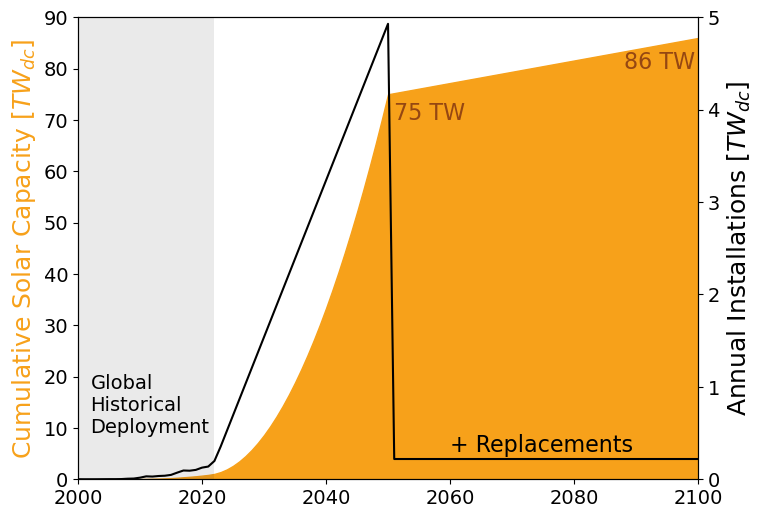

In [206]:

fig, ax1 = plt.subplots(figsize=(8,6))

ax1.stackplot(global_projection.index, global_projection['World_Cumu_[MW]']/1e6, color='#F7A11A')
ax1.set_ylabel('Cumulative Solar Capacity [$TW_{dc}$]', color='#F7A11A', fontsize=18)
ax1.set_ylim(0,90)
ax1.set_xlim(2000,2100)
ax1.text(2051,70,'75 TW', color='#954712', fontsize=16)
ax1.text(2088,80,'86 TW', color='#954712', fontsize=16)

ax2 = ax1.twinx()

ax2.plot(global_projection.loc[:,'World_Annual_[MW]']/1e6)
ax2.set_ylabel('Annual Installations [$TW_{dc}$]', fontsize=18)
ax2.set_ylim(0,5)
ax2.axvspan(2000,2022, facecolor='0.2', alpha=0.1) #grey shading
ax2.text(2002,0.5,'Global\nHistorical\nDeployment', fontsize=14)
ax2.text(2060,0.3,'+ Replacements', fontsize=16)

ax2.set_zorder(10) #send orange to back
ax2.patch.set_visible(False) #send orange to back

plt.show()

fig.savefig('energyresults-deployment.png', dpi=300, bbox_inches='tight')

In [207]:
global_projection.loc[2050]/1e3

World_Cumu_[MW]      75000.000000
World_Annual_[MW]     4929.349673
Name: 2050, dtype: float64

In [208]:
#deployment projection for all scenarios
sim1.modifyScenario(scenarios=None,stage='new_Installed_Capacity_[MW]', 
                    value= global_projection['World_Annual_[MW]'], start_year=2000)
#for scen in scennames:
#    sim1.scenario[scen].dataIn_m.loc[0:len(global_projection.index-1),'new_Installed_Capacity_[MW]'] = global_projection['World_annual_[MWdc]'].values

# 2. Calculate Mass flow: Identical Installations
Can just calc mass here (exclude energy) because we're going to immediately do Install Compensation.

In [209]:
sim1.scenario.keys()

dict_keys(['PV_ICE', 'r_PERC', 'r_SHJ', 'r_TOPCon', 'r_IRENA', 'ex_Life', 'ex_High_eff', 'ex_Circular', 'h_EffLife', 'h_50PERC', 'h_RecycledPERC', 'h_Perovskite_life', 'h_Perovskite_Eff'])

In [210]:
for scen in sim1.scenario.keys():
    print(sim1.scenario[scen].material.keys())

dict_keys(['glass', 'silicon', 'silver', 'aluminium_frames', 'copper', 'encapsulant', 'backsheet'])
dict_keys(['glass', 'silicon', 'silver', 'aluminium_frames', 'copper', 'encapsulant', 'backsheet'])
dict_keys(['glass', 'silicon', 'silver', 'aluminium_frames', 'copper', 'encapsulant', 'backsheet'])
dict_keys(['glass', 'silicon', 'silver', 'aluminium_frames', 'copper', 'encapsulant', 'backsheet'])
dict_keys(['glass', 'silicon', 'silver', 'aluminium_frames', 'copper', 'encapsulant', 'backsheet'])
dict_keys(['glass', 'silicon', 'silver', 'aluminium_frames', 'copper', 'encapsulant', 'backsheet'])
dict_keys(['glass', 'silicon', 'silver', 'aluminium_frames', 'copper', 'encapsulant', 'backsheet'])
dict_keys(['glass', 'silicon', 'silver', 'aluminium_frames', 'copper', 'encapsulant', 'backsheet'])
dict_keys(['glass', 'silicon', 'silver', 'aluminium_frames', 'copper', 'encapsulant', 'backsheet'])
dict_keys(['glass', 'silicon', 'silver', 'aluminium_frames', 'copper', 'encapsulant', 'backsheet'])


#evolving weibulls

idx_temp = pd.RangeIndex(start=2022,stop=2101,step=1) #create the index
evolve_weibull = pd.DataFrame(index=idx_temp, columns=['alpha','beta'], dtype=float)
evolve_weibull.loc[2022] = [5.3759,30]
evolve_weibull.loc[2030] = [5.1   ,35]
evolve_weibull.loc[2050] = [4.602 ,40.767]

evolve_weibull.interpolate(inplace=True)
evolve_weibull = round(evolve_weibull,3)
#evolve_weibull_temp = evolve_weibull.reset_index(drop=True)
#evolve_weibull_temp.to_dict(orient='dict')
#dict([(i,[a,b,c ]) for i, a,b,c in zip(df.ID, df.A,df.B,df.C)])
dict_weibull = {'alpha':evolve_weibull['alpha'].tolist(),
                'beta':evolve_weibull['beta'].tolist()}
evolve_weibull.to_csv(os.path.join(altBaselinesfolder,'evolve_weibull.csv'))

In [211]:
IRENAregloss = {'alpha':5.3759,
                   'beta':30} #IRENA values

In [212]:
bifiFactors = {'PV_ICE':0.0,
               'ex_Life':0.35, # ITRPV 2022, Fig. 58, 0.7 but only 50% of market share is bifi 
               'ex_High_eff': 0.92,
               'ex_Circular': 0.0,
               'h_EffLife': 0.92,
               'h_50PERC':0.35,
               'h_RecycledPERC': 0.0,
               'h_Perovskite_life': 0.0,
               'h_Perovskite_Eff': 0.0,
               'r_PERC':0.7,
               'r_SHJ':0.9, # ITRPV 2022, Fig. 58
               'r_TOPCon':0.8, # ITRPV 2022, Fig. 58              
                'r_IRENA':0.0 } 

#MAY NEED TO CHANGE TO BE DYNAMIC

In [213]:
#PV ICE currently set up to read in a csv of bifi factors, so generate files to read in 
idx_temp = pd.RangeIndex(start=2000,stop=2101,step=1) #create the index
df_temp = pd.DataFrame(index=idx_temp, columns=['bifi'], dtype=float)
bifiPathDict={}

for f in bifiFactors.keys(): #loop over module types
    bifi = df_temp.copy() #copy of df
    bifi['bifi'] = bifiFactors[f] #assign column
    bifipath = os.path.join(testfolder,'bifi_'+str(f)+'.csv') #create file path
    bifi.to_csv(path_or_buf=bifipath, index_label='year') #create file
    bifiPathDict[str(f)] = bifipath
    #append bifi path to dict? or list?


In [214]:
#CALCULATE MASS FLOWs
#13 scenarios, 7 mats = 

for scen in sim1.scenario.keys(): #loop over scenarios
    if scen in ['r_IRENA']: #,'ex_Lightweight'
        sim1.calculateMassFlow(scenarios=[scen], bifacialityfactors=bifiPathDict[scen], weibullInputParams=IRENAregloss)
    #elif scen in ['ex_Life','h_50PERC']:
    #    sim1.calculateMassFlow(scenarios=[scen], bifacialityfactors=bifiPathDict[scen], nameplatedeglimit=0.0) 
    else:
        sim1.calculateMassFlow(scenarios=[scen], bifacialityfactors=bifiPathDict[scen]) 


>>>> Calculating Material Flows <<<<

Working on Scenario:  PV_ICE
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
>>>> Calculating Material Flows <<<<

Working on Scenario:  r_PERC
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1342018529.1785421  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  38148506.617913775  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  224478.16770168545  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frame

In [215]:
ii_yearly, ii_cumu = sim1.aggregateResults() #have to do this to get auto plots

C:\Users\hmirletz\Documents\GitHub\PV_ICE\PV_ICE\main.py:2164: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  USyearly[nicekey+'_'+mat+'_'+self.name+'_'+scen] = self.scenario[scen].material[mat].matdataOut_m[keywd]
C:\Users\hmirletz\Documents\GitHub\PV_ICE\PV_ICE\main.py:2164: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  USyearly[nicekey+'_'+mat+'_'+self.name+'_'+scen] = self.scenario[scen].material[mat].matdataOut_m[keywd]
C:\Users\hmirletz\Documents\GitHub\PV_ICE\PV_ICE\main.py:2164: PerformanceWarning: DataFrame is highly fra

In [216]:
sim1.saveSimulation(customname='_EnergyAnalysis_identicalinstalls')

:) Saved Input and Output Dataframes


In [217]:
effective_capacity = ii_yearly.filter(like='ActiveCapacity')
#plt.plot(ii_cumu['newInstalledCapacity_sim1_PV_ICE_[MW]']/1e6, label='Capacity Target', color='black', ls='--')
#plt.plot(effective_capacity/1e6, label=sim1.scenario.keys())
#plt.legend()
#plt.ylabel('Effective Capacity [TW]')
#plt.title('Effective Capacity: No Replacements')
#plt.ylim(0,)

In [218]:
scennames_labels_flat[5:8]

['Long-Lived', 'High Eff', 'Circular']

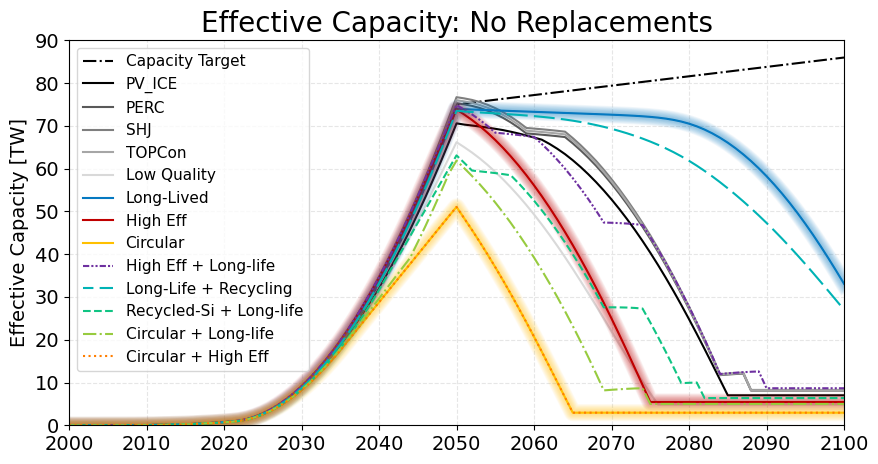

In [219]:
effective_capacity_tw = ii_yearly.filter(like='ActiveCapacity')/1e6

plt.rcParams['figure.figsize'] = (10,5)

fig_effectiveCap = plt.figure()

#capacity target
plt.plot(ii_cumu['newInstalledCapacity_sim1_PV_ICE_[MW]']/1e6, 
         label='Capacity Target', color='black', ls='dashdot')

#BAU
plt.plot(effective_capacity_tw.iloc[:,0], label=scennames_labels_flat[0]) #, ls='dotted')
plt.plot(effective_capacity_tw.iloc[:,1:5], label=scennames_labels_flat[1:5])

#Extreme
plt.plot(effective_capacity_tw.iloc[:,5:8], label=scennames_labels_flat[5:8])
#create glowlines for extreme scens
n_lines = 10
diff_linewidth = 1.05
alpha_value = 0.05
for n in range(1, n_lines+1):    
    plt.plot(effective_capacity_tw.iloc[:,5],
            linewidth=2+(diff_linewidth*n),
            alpha=alpha_value,
            color=colorpalette[5])

for n in range(1, n_lines+1):    
    plt.plot(effective_capacity_tw.iloc[:,6],
            linewidth=2+(diff_linewidth*n),
            alpha=alpha_value,
            color=colorpalette[6])

for n in range(1, n_lines+1):    
    plt.plot(effective_capacity_tw.iloc[:,7],
            linewidth=2+(diff_linewidth*n),
            alpha=alpha_value,
            color=colorpalette[7])

#Ambitious
plt.plot(effective_capacity_tw.iloc[:,8], label=scennames_labels_flat[8],  ls=(0, (3, 1, 1, 1, 1, 1))) #color=colorpalette[4:7],
plt.plot(effective_capacity_tw.iloc[:,9], label=scennames_labels_flat[9],  ls=(5, (10, 3))) #color=colorpalette[4:7],
plt.plot(effective_capacity_tw.iloc[:,10], label=scennames_labels_flat[10],  ls='--') #color=colorpalette[4:7],
plt.plot(effective_capacity_tw.iloc[:,11], label=scennames_labels_flat[11],  ls='-.') #color=colorpalette[4:7],
plt.plot(effective_capacity_tw.iloc[:,12], label=scennames_labels_flat[12],  ls=':') #color=colorpalette[4:7],


#plt.plot(effective_capacity/1e6, label=sim1.scenario.keys())
plt.legend(prop={'size': 11}) #bbox_to_anchor=(1,1.02), 
plt.ylabel('Effective Capacity [TW]')
plt.title('Effective Capacity: No Replacements', fontsize=20)
plt.ylim(0,90)
plt.xlim(2000,2100)

#ax.xaxis.set_minor_locator(MultipleLocator(10))
plt.xticks(np.arange(2000, 2101, 10))
plt.yticks(np.arange(0, 91, 10))
plt.grid(axis='both', which='both', color='0.9', ls='--')

fig_effectiveCap

fig_effectiveCap.savefig('energyresults-effectivecapacity.png', dpi=300, bbox_inches='tight')

In [220]:
plt.rcParams['figure.figsize'] = (8, 6)

# 3. Calculate Mass and Energy Flow: Installation Compensation
Make the installations always match up to the cumulative capacity deployment schedule. 

In [221]:
#13 scenarios with 7 materials
#currently takes: ~50 mins
UnderInstall_df = pd.DataFrame()


for row in range (0,len(sim1.scenario['PV_ICE'].dataIn_m)): #loop over length of years
    print(row)
    for scen in sim1.scenario.keys(): #loop over scenarios
        print(scen)
        Under_Installment = global_projection.iloc[row,0] - ((sim1.scenario[scen].dataOut_m['Effective_Capacity_[W]'][row])/1e6)  # MWATTS
        sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed
        UnderInstall_df.loc[row,scen] = Under_Installment #save the underinstallment as df
        #calculate flows for that scenario with it's bifi factor and modified weibull
        if scen in ['r_IRENA']: #,'ex_Lightweight'
            sim1.calculateFlows(scenarios=[scen], bifacialityfactors=bifiPathDict[scen], weibullInputParams=IRENAregloss)
        #elif scen in ['ex_Life','h_50PERC']:
        #    sim1.calculateMassFlow(scenarios=[scen], bifacialityfactors=bifiPathDict[scen], nameplatedeglimit=0.0) 
        else:
            sim1.calculateFlows(scenarios=[scen], bifacialityfactors=bifiPathDict[scen]) 


0
PV_ICE
>>>> Calculating Material Flows <<<<

Working on Scenario:  PV_ICE
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  r_PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1254222924.4659307  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  35652809.92328402  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  209792.68009503305  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  188309737.9618834  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1192345750.1533868  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  33894036.79490179  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  369744.70500469964  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  179020152.35454065  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copp

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1217860187.5584183  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  34619398.88448849  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  355884.5768194879  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  182851261.42256415  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Ma

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  1243090273.7192624  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  43535636.81728997  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  258566.00755147517  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  230886617.3710586  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Materia

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Circular
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Circular
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  3255894939.4743814  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  16287278.722760536  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  86820399.18007183  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  4679112.026830453  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Circular  =  306819144.9062372  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Circular
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_EffLife
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
h_50PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  h_50PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  14299775.168573432  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  3182486.5721515296  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  28233952.34569437  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Ma

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_RecycledPERC  =  1702175643.1118681  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  88933321.91337505  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  347624.15072285547  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  305633062.54142976  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_fram

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  3774568962.1105003  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  9886272.571859539  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  68762899.41892573  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  2720239.946204775  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_life  =  354470718.9765205  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Materi

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  2486309175.2287116  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  6916769.455043746  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  45100070.03597143  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  1818434.7023281073  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_Eff  =  233641681.09588602  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_Eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  r_PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1254222924.4659307  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  35652809.92328402  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  209792.68009503305  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  188309737.9618834  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1192345750.1533868  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  33894036.79490179  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  369744.70500469964  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  179020152.35454065  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copp

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1217860187.5584183  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  34619398.88448849  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  355884.5768194879  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  182851261.42256415  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Ma

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  1243090273.7192624  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  43535636.81728997  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  258566.00755147517  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  230886617.3710586  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Materia

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Circular


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Circular
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  3255894939.4743814  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  16287278.722760536  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  86820399.18007183  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  4679112.026830453  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Circular  =  306819144.9062372  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Circular
********************
==> Working on Ene

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_EffLife
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
h_50PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  h_50PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  14299775.168573432  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  3182486.5721515296  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  28233952.34569437  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Ma

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_RecycledPERC  =  1702175643.1118681  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  88933321.91337505  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  347624.15072285547  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  305633062.54142976  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_fram

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  3774568962.1105003  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  9886272.571859539  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  68762899.41892573  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  2720239.946204775  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_life  =  354470718.9765205  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Materi

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  2486309175.2287116  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  6916769.455043746  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  45100070.03597143  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  1818434.7023281073  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_Eff  =  233641681.09588602  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_Eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  r_PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1254222924.4659307  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  35652809.92328402  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  209792.68009503305  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  188309737.9618834  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1192345750.1533868  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  33894036.79490179  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  369744.70500469964  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  179020152.35454065  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copp

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1217860187.5584183  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  34619398.88448849  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  355884.5768194879  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  182851261.42256415  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Ma

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  r_IRENA
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  1243090273.7192624  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  43535636.81728997  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  258566.00755147517  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  230886617.3710586  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Life
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Circular
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Circular
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  3255894939.4743814  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  16287278.722760536  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  86820399.18007183  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  4679112.026830453  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Circular  =  306819144.9062372  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Circular
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_EffLife
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
h_50PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  h_50PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  14299775.168573432  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  3182486.5721515296  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  28233952.34569437  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Ma

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_RecycledPERC  =  1702175643.1118681  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  88933321.91337505  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  347624.15072285547  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  305633062.54142976  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_fram

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  3774568962.1105003  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  9886272.571859539  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  68762899.41892573  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  2720239.946204775  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_life  =  354470718.9765205  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Materi

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  2486309175.2287116  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  6916769.455043746  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  45100070.03597143  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  1818434.7023281073  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_Eff  =  233641681.09588602  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_Eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  r_PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1254222924.4659307  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  35652809.92328402  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  209792.68009503305  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  188309737.9618834  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1192345750.1533868  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  33894036.79490179  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  369744.70500469964  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  179020152.35454065  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copp

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1217860187.5584183  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  34619398.88448849  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  355884.5768194879  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  182851261.42256415  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Ma

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  1243090273.7192624  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  43535636.81728997  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  258566.00755147517  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  230886617.3710586  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Materia

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Circular
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Circular
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  3255894939.4743814  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  16287278.722760536  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  86820399.18007183  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  4679112.026830453  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Circular  =  306819144.9062372  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Circular
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_EffLife
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
h_50PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  h_50PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  14299775.168573432  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  3182486.5721515296  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  28233952.34569437  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Ma

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_RecycledPERC  =  1702175643.1118681  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  88933321.91337505  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  347624.15072285547  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  305633062.54142976  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_fram

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  3774568962.1105003  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  9886272.571859539  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  68762899.41892573  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  2720239.946204775  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_life  =  354470718.9765205  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Materi

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  2486309175.2287116  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  6916769.455043746  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  45100070.03597143  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  1818434.7023281073  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_Eff  =  233641681.09588602  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_Eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  r_PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1254222924.4659307  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  35652809.92328402  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  209792.68009503305  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  188309737.9618834  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1192345750.1533868  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  33894036.79490179  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  369744.70500469964  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  179020152.35454065  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copp

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1217860187.5584183  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  34619398.88448849  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  355884.5768194879  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  182851261.42256415  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Ma

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  1243090273.7192624  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  43535636.81728997  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  258566.00755147517  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  230886617.3710586  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Materia

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Circular
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Circular
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  3255894939.4743814  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  16287278.722760536  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  86820399.18007183  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  4679112.026830453  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Circular  =  306819144.9062372  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Circular
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_EffLife
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
h_50PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  h_50PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  14299775.168573432  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  3182486.5721515296  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  28233952.34569437  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Ma

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_RecycledPERC  =  1702175643.1118681  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  88933321.91337505  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  347624.15072285547  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  305633062.54142976  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_fram

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  3774568962.1105003  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  9886272.571859539  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  68762899.41892573  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  2720239.946204775  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_life  =  354470718.9765205  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Materi

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  2486309175.2287116  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  6916769.455043746  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  45100070.03597143  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  1818434.7023281073  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_Eff  =  233641681.09588602  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_Eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  r_PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1254222924.4659307  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  35652809.92328402  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  209792.68009503305  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  188309737.9618834  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1192345750.1533868  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  33894036.79490179  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  369744.70500469964  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  179020152.35454065  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copp

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1217860187.5584183  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  34619398.88448849  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  355884.5768194879  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  182851261.42256415  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Ma

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  r_IRENA
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  1243090273.7192624  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  43535636.81728997  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  258566.00755147517  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  230886617.3710586  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Circular
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Circular
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  3255894939.4743814  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  16287278.722760536  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  86820399.18007183  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  4679112.026830453  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Circular  =  306819144.9062372  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Circular
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_EffLife
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
h_50PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  h_50PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  14299775.168573432  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  3182486.5721515296  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  28233952.34569437  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Ma

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_RecycledPERC  =  1702175643.1118681  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  88933321.91337505  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  347624.15072285547  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  305633062.54142976  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_fram

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  3774568962.1105003  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  9886272.571859539  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  68762899.41892573  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  2720239.946204775  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_life  =  354470718.9765205  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Materi

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  2486309175.2287116  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  6916769.455043746  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  45100070.03597143  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  1818434.7023281073  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_Eff  =  233641681.09588602  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_Eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  r_PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1254222924.4659307  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  35652809.92328402  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  209792.68009503305  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  188309737.9618834  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1192345750.1533868  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  33894036.79490179  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  369744.70500469964  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  179020152.35454065  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copp

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1217860187.5584183  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  34619398.88448849  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  355884.5768194879  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  182851261.42256415  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Ma

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  1243090273.7192624  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  43535636.81728997  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  258566.00755147517  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  230886617.3710586  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Materia

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Circular
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Circular
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  3255894939.4743814  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  16287278.722760536  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  86820399.18007183  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  4679112.026830453  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Circular  =  306819144.9062372  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Circular
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_EffLife
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
h_50PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  h_50PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  14299775.168573432  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  3182486.5721515296  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  28233952.34569437  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Ma

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_RecycledPERC  =  1702175643.1118681  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  88933321.91337505  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  347624.15072285547  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  305633062.54142976  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_fram

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  3774568962.1105003  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  9886272.571859539  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  68762899.41892573  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  2720239.946204775  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_life  =  354470718.9765205  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Materi

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  2486309175.2287116  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  6916769.455043746  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  45100070.03597143  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  1818434.7023281073  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_Eff  =  233641681.09588602  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_Eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  r_PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1254222924.4659307  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  35652809.92328402  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  209792.68009503305  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  188309737.9618834  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1192345750.1533868  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  33894036.79490179  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  369744.70500469964  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  179020152.35454065  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copp

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1217860187.5584183  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  34619398.88448849  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  355884.5768194879  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  182851261.42256415  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Ma

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  1243090273.7192624  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  43535636.81728997  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  258566.00755147517  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  230886617.3710586  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Materia

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Circular
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Circular
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  3255894939.4743814  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  16287278.722760536  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  86820399.18007183  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  4679112.026830453  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Circular  =  306819144.9062372  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Circular
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_EffLife
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
h_50PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  h_50PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  14299775.168573432  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  3182486.5721515296  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  28233952.34569437  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Ma

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_RecycledPERC  =  1702175643.1118681  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  88933321.91337505  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  347624.15072285547  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  305633062.54142976  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_fram

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  3774568962.1105003  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  9886272.571859539  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  68762899.41892573  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  2720239.946204775  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_life  =  354470718.9765205  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Materi

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  h_Perovskite_Eff
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  2486309175.2287116  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  6916769.455043746  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  45100070.03597143  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  1818434.7023281073  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_Eff  =  233641681.09588602  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_Eff
***

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  r_PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1254222924.4659307  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  35652809.92328402  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  209792.68009503305  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  188309737.9618834  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1192345750.1533868  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  33894036.79490179  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  369744.70500469964  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  179020152.35454065  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copp

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1217860187.5584183  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  34619398.88448849  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  355884.5768194879  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  182851261.42256415  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Ma

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  1243090273.7192624  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  43535636.81728997  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  258566.00755147517  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  230886617.3710586  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Materia

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Circular
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Circular
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  3255894939.4743814  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  16287278.722760536  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  86820399.18007183  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  4679112.026830453  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Circular  =  306819144.9062372  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Circular
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_EffLife
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
h_50PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  h_50PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  14299775.168573432  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  3182486.5721515296  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  28233952.34569437  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Ma

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_RecycledPERC  =  1702175643.1118681  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  88933321.91337505  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  347624.15072285547  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  305633062.54142976  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_fram

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  3774568962.1105003  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  9886272.571859539  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  68762899.41892573  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  2720239.946204775  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_life  =  354470718.9765205  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Materi

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  2486309175.2287116  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  6916769.455043746  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  45100070.03597143  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  1818434.7023281073  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_Eff  =  233641681.09588602  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_Eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  r_PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1254222924.4659307  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  35652809.92328402  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  209792.68009503305  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  188309737.9618834  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1192345750.1533868  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  33894036.79490179  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  369744.70500469964  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  179020152.35454065  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copp

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1217860187.5584183  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  34619398.88448849  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  355884.5768194879  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  182851261.42256415  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Ma

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  1243090273.7192624  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  43535636.81728997  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  258566.00755147517  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  230886617.3710586  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Materia

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Circular
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Circular
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  3255894939.4743814  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  16287278.722760536  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  86820399.18007183  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  4679112.026830453  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Circular  =  306819144.9062372  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Circular
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_EffLife
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
h_50PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  h_50PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  14299775.168573432  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  3182486.5721515296  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  28233952.34569437  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Ma

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_RecycledPERC  =  1702175643.1118681  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  88933321.91337505  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  347624.15072285547  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  305633062.54142976  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_fram

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  3774568962.1105003  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  9886272.571859539  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  68762899.41892573  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  2720239.946204775  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_life  =  354470718.9765205  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Materi

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  2486309175.2287116  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  6916769.455043746  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  45100070.03597143  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  1818434.7023281073  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_Eff  =  233641681.09588602  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_Eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  r_PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1254222924.4659307  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  35652809.92328402  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  209792.68009503305  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  188309737.9618834  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1192345750.1533868  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  33894036.79490179  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  369744.70500469964  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  179020152.35454065  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copp

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1217860187.5584183  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  34619398.88448849  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  355884.5768194879  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  182851261.42256415  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Ma

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  1243090273.7192624  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  43535636.81728997  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  258566.00755147517  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  230886617.3710586  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Materia

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Circular
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Circular
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  3255894939.4743814  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  16287278.722760536  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  86820399.18007183  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  4679112.026830453  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Circular  =  306819144.9062372  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Circular
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_EffLife
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
h_50PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  h_50PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  14299775.168573432  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  3182486.5721515296  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  28233952.34569437  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Ma

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_RecycledPERC  =  1702175643.1118681  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  88933321.91337505  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  347624.15072285547  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  305633062.54142976  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_fram

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  3774568962.1105003  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  9886272.571859539  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  68762899.41892573  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  2720239.946204775  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_life  =  354470718.9765205  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Materi

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  2486309175.2287116  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  6916769.455043746  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  45100070.03597143  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  1818434.7023281073  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_Eff  =  233641681.09588602  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_Eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  r_PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1254222924.4659307  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  35652809.92328402  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  209792.68009503305  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  188309737.9618834  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1192345750.1533868  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  33894036.79490179  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  369744.70500469964  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  179020152.35454065  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copp

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1217860187.5584183  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  34619398.88448849  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  355884.5768194879  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  182851261.42256415  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Ma

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  1243090273.7192624  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  43535636.81728997  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  258566.00755147517  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  230886617.3710586  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Materia

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Circular
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Circular
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  3255894939.4743814  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  16287278.722760536  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  86820399.18007183  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  4679112.026830453  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Circular  =  306819144.9062372  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Circular
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_EffLife
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
h_50PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  h_50PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  14299775.168573432  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  3182486.5721515296  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  28233952.34569437  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Ma

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_RecycledPERC  =  1702175643.1118681  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  88933321.91337505  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  347624.15072285547  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  305633062.54142976  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_fram

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  3774568962.1105003  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  9886272.571859539  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  68762899.41892573  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  2720239.946204775  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_life  =  354470718.9765205  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Materi

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  2486309175.2287116  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  6916769.455043746  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  45100070.03597143  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  1818434.7023281073  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_Eff  =  233641681.09588602  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_Eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  r_PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1254222924.4659307  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  35652809.92328402  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  209792.68009503305  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  188309737.9618834  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1192345750.1533868  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  33894036.79490179  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  369744.70500469964  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  179020152.35454065  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copp

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1217860187.5584183  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  34619398.88448849  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  355884.5768194879  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  182851261.42256415  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Ma

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  r_IRENA
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  1243090273.7192624  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  43535636.81728997  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  258566.00755147517  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  230886617.3710586  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Circular
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Circular
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  3255894939.4743814  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  16287278.722760536  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  86820399.18007183  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  4679112.026830453  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Circular  =  306819144.9062372  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Circular
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_EffLife
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
h_50PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  h_50PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  14299775.168573432  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  3182486.5721515296  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  28233952.34569437  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Ma

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_RecycledPERC  =  1702175643.1118681  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  88933321.91337505  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  347624.15072285547  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  305633062.54142976  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_fram

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  3774568962.1105003  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  9886272.571859539  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  68762899.41892573  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  2720239.946204775  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_life  =  354470718.9765205  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Materi

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  2486309175.2287116  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  6916769.455043746  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  45100070.03597143  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  1818434.7023281073  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_Eff  =  233641681.09588602  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_Eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  r_PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1254222924.4659307  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  35652809.92328402  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  209792.68009503305  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  188309737.9618834  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1192345750.1533868  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  33894036.79490179  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  369744.70500469964  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  179020152.35454065  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copp

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1217860187.5584183  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  34619398.88448849  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  355884.5768194879  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  182851261.42256415  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Ma

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  1243090273.7192624  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  43535636.81728997  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  258566.00755147517  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  230886617.3710586  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Materia

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Circular
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Circular
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  3255894939.4743814  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  16287278.722760536  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  86820399.18007183  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  4679112.026830453  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Circular  =  306819144.9062372  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Circular
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  h_EffLife
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_EffLife
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
h_50PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  h_50PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  14299775.168573432  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  3182486.5721515296  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  28233952.34569437  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Ma

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_RecycledPERC  =  1702175643.1118681  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  88933321.91337505  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  347624.15072285547  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  305633062.54142976  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_fram

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  3774568962.1105003  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  9886272.571859539  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  68762899.41892573  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  2720239.946204775  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_life  =  354470718.9765205  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Materi

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  2486309175.2287116  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  6916769.455043746  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  45100070.03597143  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  1818434.7023281073  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_Eff  =  233641681.09588602  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_Eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_PERC


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  r_PERC
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1254222924.4659307  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  35652809.92328402  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  209792.68009503305  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  188309737.9618834  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> W

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1192345750.1533868  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  33894036.79490179  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  369744.70500469964  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  179020152.35454065  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copp

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1217860187.5584183  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  34619398.88448849  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  355884.5768194879  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  182851261.42256415  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Ma

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  1243090273.7192624  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  43535636.81728997  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  258566.00755147517  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  230886617.3710586  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Materia

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Circular
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Circular
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  3255894939.4743814  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  16287278.722760536  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  86820399.18007183  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  4679112.026830453  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Circular  =  306819144.9062372  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Circular
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_EffLife
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
h_50PERC


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  h_50PERC
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  14299775.168573432  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  3182486.5721515296  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  28233952.34569437  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Materia

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_RecycledPERC  =  1702175643.1118681  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  88933321.91337505  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  347624.15072285547  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  305633062.54142976  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_fram

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  3774568962.1105003  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  9886272.571859539  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  68762899.41892573  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  2720239.946204775  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_life  =  354470718.9765205  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Materi

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  2486309175.2287116  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  6916769.455043746  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  45100070.03597143  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  1818434.7023281073  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_Eff  =  233641681.09588602  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_Eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  r_PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1254222924.4659307  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  35652809.92328402  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  209792.68009503305  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  188309737.9618834  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1192345750.1533868  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  33894036.79490179  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  369744.70500469964  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  179020152.35454065  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copp

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1217860187.5584183  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  34619398.88448849  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  355884.5768194879  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  182851261.42256415  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Ma

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  1243090273.7192624  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  43535636.81728997  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  258566.00755147517  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  230886617.3710586  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Materia

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Circular


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Circular
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  3255894939.4743814  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  16287278.722760536  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  86820399.18007183  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  4679112.026830453  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Circular  =  306819144.9062372  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Circular
********************
==> Working on Ene

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_EffLife
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
h_50PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  h_50PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  14299775.168573432  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  3182486.5721515296  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  28233952.34569437  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Ma

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_RecycledPERC  =  1702175643.1118681  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  88933321.91337505  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  347624.15072285547  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  305633062.54142976  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_fram

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  3774568962.1105003  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  9886272.571859539  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  68762899.41892573  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  2720239.946204775  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_life  =  354470718.9765205  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Materi

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  2486309175.2287116  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  6916769.455043746  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  45100070.03597143  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  1818434.7023281073  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_Eff  =  233641681.09588602  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_Eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  PV_ICE
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  r_PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1254222924.4659307  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  35652809.92328402  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  209792.68009503305  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  188309737.9618834  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1192345750.1533868  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  33894036.79490179  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  369744.70500469964  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  179020152.35454065  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copp

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1217860187.5584183  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  34619398.88448849  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  355884.5768194879  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  182851261.42256415  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Ma

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  1243090273.7192624  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  43535636.81728997  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  258566.00755147517  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  230886617.3710586  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Materia

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Circular
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Circular
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  3255894939.4743814  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  16287278.722760536  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  86820399.18007183  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  4679112.026830453  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Circular  =  306819144.9062372  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Circular
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_EffLife
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
h_50PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  h_50PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  14299775.168573432  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  3182486.5721515296  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  28233952.34569437  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Ma

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_RecycledPERC  =  1702175643.1118681  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  88933321.91337505  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  347624.15072285547  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  305633062.54142976  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_fram

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  h_Perovskite_life
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  3774568962.1105003  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  9886272.571859539  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  68762899.41892573  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  2720239.946204775  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_life  =  354470718.9765205  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_lif

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  2486309175.2287116  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  6916769.455043746  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  45100070.03597143  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  1818434.7023281073  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_Eff  =  233641681.09588602  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_Eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  PV_ICE
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_PERC


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  r_PERC
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1254222924.4659307  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  35652809.92328402  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  209792.68009503305  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  188309737.9618834  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> W

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1192345750.1533868  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  33894036.79490179  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  369744.70500469964  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  179020152.35454065  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copp

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1217860187.5584183  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  34619398.88448849  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  355884.5768194879  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  182851261.42256415  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Ma

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  1243090273.7192624  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  43535636.81728997  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  258566.00755147517  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  230886617.3710586  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Materia

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Circular
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Circular
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  3255894939.4743814  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  16287278.722760536  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  86820399.18007183  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  4679112.026830453  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Circular  =  306819144.9062372  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Circular
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  h_EffLife
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_EffLife
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
h_50PERC


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  h_50PERC
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  14299775.168573432  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  3182486.5721515296  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  28233952.34569437  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Materia

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_RecycledPERC  =  1702175643.1118681  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  88933321.91337505  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  347624.15072285547  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  305633062.54142976  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_fram

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  3774568962.1105003  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  9886272.571859539  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  68762899.41892573  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  2720239.946204775  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_life  =  354470718.9765205  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Materi

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  2486309175.2287116  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  6916769.455043746  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  45100070.03597143  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  1818434.7023281073  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_Eff  =  233641681.09588602  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_Eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  r_PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1254222924.4659307  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  35652809.92328402  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  209792.68009503305  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  188309737.9618834  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1192345750.1533868  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  33894036.79490179  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  369744.70500469964  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  179020152.35454065  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copp

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1217860187.5584183  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  34619398.88448849  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  355884.5768194879  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  182851261.42256415  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Ma

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  1243090273.7192624  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  43535636.81728997  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  258566.00755147517  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  230886617.3710586  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Materia

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Circular


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Circular
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  3255894939.4743814  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  16287278.722760536  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  86820399.18007183  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  4679112.026830453  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Circular  =  306819144.9062372  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Circular
********************
==> Working on Ene

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_EffLife
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
h_50PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  h_50PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  14299775.168573432  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  3182486.5721515296  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  28233952.34569437  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Ma

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_RecycledPERC  =  1702175643.1118681  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  88933321.91337505  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  347624.15072285547  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  305633062.54142976  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_fram

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  3774568962.1105003  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  9886272.571859539  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  68762899.41892573  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  2720239.946204775  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_life  =  354470718.9765205  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Materi

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  2486309175.2287116  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  6916769.455043746  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  45100070.03597143  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  1818434.7023281073  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_Eff  =  233641681.09588602  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_Eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  r_PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1254222924.4659307  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  35652809.92328402  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  209792.68009503305  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  188309737.9618834  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1192345750.1533868  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  33894036.79490179  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  369744.70500469964  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  179020152.35454065  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copp

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1217860187.5584183  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  34619398.88448849  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  355884.5768194879  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  182851261.42256415  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Ma

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  1243090273.7192624  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  43535636.81728997  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  258566.00755147517  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  230886617.3710586  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Materia

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Life
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Circular
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Circular
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  3255894939.4743814  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  16287278.722760536  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  86820399.18007183  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  4679112.026830453  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Circular  =  306819144.9062372  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Circular
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_EffLife
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
h_50PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  h_50PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  14299775.168573432  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  3182486.5721515296  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  28233952.34569437  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Ma

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_RecycledPERC  =  1702175643.1118681  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  88933321.91337505  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  347624.15072285547  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  305633062.54142976  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_fram

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  3774568962.1105003  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  9886272.571859539  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  68762899.41892573  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  2720239.946204775  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_life  =  354470718.9765205  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Materi

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  2486309175.2287116  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  6916769.455043746  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  45100070.03597143  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  1818434.7023281073  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_Eff  =  233641681.09588602  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_Eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  r_PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1254222924.4659307  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  35652809.92328402  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  209792.68009503305  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  188309737.9618834  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1192345750.1533868  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  33894036.79490179  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  369744.70500469964  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  179020152.35454065  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copp

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1217860187.5584183  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  34619398.88448849  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  355884.5768194879  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  182851261.42256415  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Ma

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  1243090273.7192624  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  43535636.81728997  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  258566.00755147517  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  230886617.3710586  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Materia

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Circular
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Circular
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  3255894939.4743814  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  16287278.722760536  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  86820399.18007183  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  4679112.026830453  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Circular  =  306819144.9062372  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Circular
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_EffLife
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
h_50PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  h_50PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  14299775.168573432  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  3182486.5721515296  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  28233952.34569437  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Ma

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_RecycledPERC  =  1702175643.1118681  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  88933321.91337505  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  347624.15072285547  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  305633062.54142976  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
=

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  3774568962.1105003  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  9886272.571859539  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  68762899.41892573  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  2720239.946204775  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_life  =  354470718.9765205  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Materi

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  2486309175.2287116  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  6916769.455043746  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  45100070.03597143  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  1818434.7023281073  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_Eff  =  233641681.09588602  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_Eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  PV_ICE
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  r_PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1254222924.4659307  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  35652809.92328402  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  209792.68009503305  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  188309737.9618834  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  r_SHJ
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1192345750.1533868  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  33894036.79490179  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  369744.70500469964  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  179020152.35454065  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Workin

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1217860187.5584183  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  34619398.88448849  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  355884.5768194879  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  182851261.42256415  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Ma

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  1243143948.0381682  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  43538085.16702439  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  258587.2551248677  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  230897294.96966106  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Materia

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Circular
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Circular
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  3256098436.845499  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  16287377.39822049  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  86828923.93984328  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  4679456.496715097  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Circular  =  306847597.21238065  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Circular
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  h_EffLife
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_EffLife
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
h_50PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  h_50PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  14299775.168573432  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  3182486.5721515296  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  28233952.34569437  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Ma

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_RecycledPERC  =  1702318667.6073952  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  88942020.64783573  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  347680.7685529012  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  305661514.8475732  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  h_Perovskite_life
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  3774772459.481618  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  9886272.571859524  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  68769162.50773743  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  2720416.335236614  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_life  =  354499171.282664  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_life


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  2486512672.5998297  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  6916769.455043746  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  45106333.124783106  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  1818611.0913599469  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_Eff  =  233670133.40202945  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_Eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  r_PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1254222924.4659307  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  35652809.92328402  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  209839.50854984  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  188309737.9618834  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  cop

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1192345750.1533868  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  33894036.79490179  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  369842.8663699996  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  179020152.35454065  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  coppe

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  r_TOPCon
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1217860187.5584183  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  34619398.88448849  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  355884.5768194879  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  182851261.42256415  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  1243143948.0381682  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  43538085.16702439  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  258587.2551248677  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  230897294.96966106  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Materia

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Life
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Circular


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Circular
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  3256098436.845499  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  16287377.39822049  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  86828923.93984328  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  4679456.496715097  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Circular  =  306847597.21238065  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Circular
********************
==> Working on Ener

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  h_EffLife
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_EffLife
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
h_50PERC


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  h_50PERC
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  14299775.168573432  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  3182486.5721515296  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  28233952.34569809  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Materia

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_RecycledPERC  =  1702318667.6073952  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  88942020.64783573  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  347680.7685529012  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  305661514.8475732  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  3774772459.481618  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  9886272.571859524  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  68769162.50773743  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  2720416.335236614  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_life  =  354499171.282664  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  2486512672.5998297  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  6916769.455043746  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  45106333.124783106  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  1818611.0913599469  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_Eff  =  233670133.40202945  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_Eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  r_PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1254222924.4659307  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  35652809.92328402  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  209895.40351244144  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  188339048.2792347  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1192345750.1533868  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  33894036.79490179  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  369957.9190583731  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  179048051.1548146  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1217860187.5584183  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  34619398.88448849  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  355975.5178745743  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  182879774.36651596  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Ma

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  1243143948.0381682  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  43538085.16702439  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  258587.2551248677  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  230897294.96966106  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Materia

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Circular


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Circular
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  3256098436.845499  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  16287377.39822049  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  86828923.93984328  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  4679456.496715097  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Circular  =  306847597.21238065  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Circular
********************
==> Working on Ener

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_EffLife
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
h_50PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  h_50PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  14299775.168573432  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  3182486.5721515296  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  28233952.353634004  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for M

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_RecycledPERC  =  1702318667.6073952  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  88942020.64783573  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  347680.7685529012  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  305661514.8475732  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  3774772459.481618  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  9886272.571859524  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  68769162.50773743  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  2720416.335236614  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_life  =  354499171.282664  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  2486512672.5998297  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  6916769.455043746  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  45106333.124783106  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  1818611.0913599469  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_Eff  =  233670133.40202945  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_Eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  PV_ICE
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  r_PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1254491403.5137715  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  35661361.635807976  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  209965.67281048454  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  188377368.24731737  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  r_SHJ
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1192601250.5297968  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  33902175.105084255  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  370099.64857377653  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  179084518.67936775  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Worki

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1218121287.8124182  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  34627715.56443094  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  356090.04272474686  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  182917041.16062945  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for M

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  r_IRENA
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  1243143948.0381682  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  43538085.16702439  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  258587.2551248677  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  230897294.96966106  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Circular


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Circular
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  3256098436.845499  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  16287377.39822049  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  86828923.93984328  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  4679456.496715097  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Circular  =  306847597.21238065  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Circular
********************
==> Working on Ener

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  h_EffLife
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_EffLife
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
h_50PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  h_50PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  14299775.168573432  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  3182486.5721515296  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  28233953.948103417  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for M

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_RecycledPERC  =  1702318667.6073952  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  88942020.64783573  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  347680.7685529012  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  305661514.8475732  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  3774772459.481618  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  9886272.571859524  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  68769162.50773743  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  2720416.335236614  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_life  =  354499171.282664  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  2486512672.5998297  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  6916769.455043746  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  45106333.124783106  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  1818611.0913599469  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_Eff  =  233670133.40202945  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_Eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  PV_ICE
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  r_PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1254853700.5959802  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  35672717.92286885  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  210054.98184320287  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  188428166.0222584  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1192945968.0366974  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  33912980.356231764  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  370275.70898860466  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  179132851.61715192  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  cop

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1218473528.0081182  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  34638756.61602418  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  356235.93289976363  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  182966428.85670823  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for M

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  1243441784.3035097  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  43549825.0118085  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  258671.06814721436  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  230949527.34272206  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Materia

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Circular
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Circular
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  3256098436.845499  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  16287377.39822049  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  86828923.93984328  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  4679456.496715097  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Circular  =  306847597.21238065  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Circular
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_EffLife
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
h_50PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  h_50PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  14299775.168573432  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  3182486.5721515296  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  28234012.8869032  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Mat

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_RecycledPERC  =  1702318667.6073952  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  88942020.64783573  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  347680.7685529012  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  305661514.8475732  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  3774772459.481618  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  9886272.571859524  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  68769162.50773743  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  2720416.335236614  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_life  =  354499171.282664  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  2486512672.5998297  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  6916769.455043746  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  45106333.124783106  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  1818611.0913599469  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_Eff  =  233670133.40202945  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_Eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  r_PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1255331468.6841753  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  35687451.349611826  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  210166.42048153316  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  188494506.29113096  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1193400468.3497038  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  33926996.25062026  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  370489.77622123307  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  179195961.0497668  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  coppe

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  r_TOPCon
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1218937904.4507248  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  34653077.07079576  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  356417.8106506644  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  183030909.6347714  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  s

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  1243871630.4367418  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  43566559.3551498  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  258785.73669258735  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  231024604.95319337  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Materia

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Circular
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Circular
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  3256098436.845499  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  16287377.39822049  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  86828923.93984328  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  4679456.496715097  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Circular  =  306847597.21238065  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Circular
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_EffLife
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
h_50PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  h_50PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  14299775.168573432  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  3182486.572163318  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  28234681.758466575  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Ma

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_RecycledPERC  =  1702318667.6073952  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  88942020.64783573  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  347680.7685529012  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  305661514.8475732  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  3774772459.481618  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  9886272.571859524  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  68769162.50773743  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  2720416.335236614  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_life  =  354499171.282664  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  2486512672.5998297  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  6916769.455043746  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  45106333.124783106  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  1818611.0913599469  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_Eff  =  233670133.40202945  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_Eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  r_PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1255930962.8373635  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  35705654.773401976  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  210298.29011105944  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  188576915.52318645  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1193970661.1918287  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  33944309.95066572  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  370735.6954306877  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  179274342.3884223  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1219520435.0329077  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  34670765.40186923  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  356632.83214818826  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  183110986.97609535  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for M

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  r_IRENA
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  1244456295.6434598  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  43588732.15289381  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  258931.4047841193  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  231124824.50024843  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Circular
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Circular
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  3256098436.845499  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  16287377.39822049  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  86828923.93984328  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  4679456.496715097  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Circular  =  306847597.21238065  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Circular
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_EffLife
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
h_50PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  h_50PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  14299775.168573432  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  3182486.58993468  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  28238029.421611737  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Mat

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_RecycledPERC  =  1702318667.6073952  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  88942020.64783573  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  347680.7685529012  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  305661514.8475732  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  3774772459.481618  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  9886272.571859524  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  68769162.50773743  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  2720416.335236614  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_life  =  354499171.282664  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  2486512672.5998297  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  6916769.455043746  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  45106333.124783106  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  1818611.0913599469  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_Eff  =  233670133.40202945  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_Eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  r_PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1256713095.1986134  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  35729033.68624214  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  210460.3183513631  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  188683465.23663896  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1194714429.90428  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  33966542.12614284  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  371027.68795061857  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  179375665.83073577  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1220280230.0635273  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  34693476.62400668  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  356896.5146473539  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  183214493.6800831  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Mat

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  r_IRENA
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  1245299599.6608405  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  43619888.08977217  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  259126.7418102958  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  231266723.80034807  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Circular
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Circular
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  3256098436.845499  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  16287377.39822049  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  86828923.93984328  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  4679456.496715097  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Circular  =  306847597.21238065  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Circular
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_EffLife
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
h_50PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  h_50PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  14299775.168573432  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  3182489.0866535893  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  28247962.942026645  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for M

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_RecycledPERC  =  1702318667.6073952  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  88942020.64783573  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  347680.7685529012  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  305661514.8475732  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  3774772459.481618  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  9886272.571859524  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  68769162.50773743  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  2720416.335236614  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_life  =  354499171.282664  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  h_Perovskite_Eff
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  2486512672.5998297  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  6916769.455043746  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  45106333.124783106  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  1818611.0913599469  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_Eff  =  233670133.40202945  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_Eff
**

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  r_PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1257716989.4083197  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  35758566.10332721  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  210655.69052320794  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  188819079.8795304  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1195668911.5269237  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  33994620.93076929  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  371365.9525732852  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  179504605.39742497  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  coppe

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1221255193.2944193  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  34722157.95367162  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  357213.604930062  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  183346200.07813913  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Mat

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  1246471479.2576976  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  43662067.63672197  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  259378.18050470593  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  231460334.3777908  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Materia

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Circular
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Circular
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  3256098436.845499  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  16287377.39822049  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  86828923.93984328  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  4679456.496715097  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Circular  =  306847597.21238065  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Circular
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  h_EffLife
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_EffLife
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
h_50PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  h_50PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  14299775.168573424  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  3182555.9906928265  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  28268714.20957273  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Ma

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_RecycledPERC  =  1702318667.6073952  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  88942020.64783573  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  347680.7685529012  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  305661514.8475732  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  3774772459.481618  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  9886272.571859524  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  68769162.50773743  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  2720416.335236614  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_life  =  354499171.282664  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  2486512672.5998297  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  6916769.455043746  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  45106333.124783106  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  1818611.0913599469  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_Eff  =  233670133.40202945  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_Eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_PERC


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  r_PERC
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1258972996.0436296  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  35795260.307033636  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  210884.37953751953  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  188987318.64433  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Wo

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1196862884.75354  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  34029502.82992951  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  371743.53197692387  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  179664534.95130038  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1222474682.4354386  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  34757785.29965876  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  357583.63619704015  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  183509547.42122138  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for M

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  1247969814.5444355  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  43715865.45897283  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  259678.99074808377  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  231706951.32377914  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Materi

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Life
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Circular
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Circular
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  3256098436.845499  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  16287377.39822049  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  86828923.93984328  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  4679456.496715097  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Circular  =  306847597.21238065  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Circular
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_EffLife
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
h_50PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  h_50PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  14299775.168595158  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  3183139.34230978  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  28303106.69395098  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Mate

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_RecycledPERC  =  1702318667.6073952  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  88942020.64783573  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  347680.7685529012  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  305661514.8475732  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  3774772459.481618  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  9886272.571859524  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  68769162.50773743  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  2720416.335236614  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_life  =  354499171.282664  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  2486512672.5998297  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  6916769.455043746  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  45106333.124783106  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  1818611.0913599469  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_Eff  =  233670133.40202945  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_Eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  r_PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1260333491.543117  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  35834731.13065367  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  211128.37346635346  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  189168035.37944627  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1198156186.546081  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  34067024.22339248  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  372148.55492232845  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  179836326.24172083  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  coppe

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1223795622.6771417  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  34796108.54241298  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  357980.62743698264  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  183685009.9698695  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Ma

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  1249680054.338128  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  43777121.73501311  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  260023.9001008815  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  231987385.63013488  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Circular
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Circular
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  3256098436.845499  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  16287377.39822049  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  86828923.93984328  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  4679456.496715097  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Circular  =  306847597.21238065  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Circular
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_EffLife
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
h_50PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  h_50PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  14299775.185951792  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  3184904.971980316  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  28348410.869603924  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Ma

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_RecycledPERC  =  1704518966.8746183  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  89047099.19863802  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  348124.5097165779  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  306022306.00741786  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frame

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  3780158527.62933  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  9886272.571859539  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  68874594.83129999  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  2723385.653736957  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_life  =  355001957.1881289  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  2486512672.5998297  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  6916769.455043746  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  45106333.124783106  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  1818611.0913599469  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_Eff  =  233670133.40202945  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_Eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_PERC


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  r_PERC
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1262209612.765508  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  35889161.33632999  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  211459.72579638156  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  189417233.37577772  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> W

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1199939647.2245126  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  34118766.15263675  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  372701.6334140057  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  180073216.4928926  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1225617196.9914763  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  34848956.228053235  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  358522.81970867584  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  183926962.7093212  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for M

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  r_IRENA
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  1252062627.4721248  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  43862459.21699692  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  260504.4009994519  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  232378064.90601093  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Circular
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Circular
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  3256098436.845499  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  16287377.39822049  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  86828923.93984328  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  4679456.496715097  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Circular  =  306847597.21238065  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Circular
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_EffLife
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
h_50PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  h_50PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  14299777.602040946  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  3189125.6946115405  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  28408841.26371841  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Ma

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_RecycledPERC  =  1707521595.6509387  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  89190494.18363532  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  348730.0591557572  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  306514658.0864869  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  3787499302.1988196  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  9886272.571859524  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  69018290.54742996  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  2727432.5943136876  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_life  =  355687213.64748174  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Mate

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  2486512672.5998297  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  6916769.455043746  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  45106333.124783106  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  1818611.0913599469  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_Eff  =  233670133.40202945  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_Eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  r_PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1264093904.4380963  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  35943828.583877265  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  211787.39327383094  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  189667510.5497862  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material : 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1201730875.3177154  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  34170733.43085026  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  373251.6648423105  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  180311132.68797708  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  coppe

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1227446704.4604237  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  34902034.07112261  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  359062.10163877095  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  184169963.2839226  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Ma

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  1254603670.5520535  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  43953472.6742375  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  261016.86102252104  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  232794729.08150724  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Materia

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Circular


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Circular
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  3256098436.845499  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  16287377.39822049  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  86828923.93984328  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  4679456.496715097  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Circular  =  306847597.21238065  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Circular
********************
==> Working on Ener

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_EffLife
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
h_50PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  h_50PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  14299867.373579448  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  3196677.674440696  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  28480963.77209841  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Mat

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_RecycledPERC  =  1710597364.4418583  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  89337382.0783719  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  349350.35896806663  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  307019003.20263577  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  3795511846.7646594  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  9886272.571859524  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  69175136.16617393  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  2731849.879086495  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_life  =  356435179.39246124  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Mater

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  2486512672.5998297  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  6916769.455043746  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  45106333.124783106  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  1818611.0913599469  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_Eff  =  233670133.40202945  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_Eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  PV_ICE
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  r_PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1266705469.8805869  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  36019595.56656231  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  212234.42534487692  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  190014379.01151422  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material : 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1204213457.033598  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  34242758.32550581  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  374006.4328430986  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  180640869.51436153  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1229982340.4614198  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  34975598.18169676  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  359802.2245920111  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  184506746.78735605  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Ma

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  1258120144.7578304  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  44079423.500216424  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  261726.0392599341  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  233371338.2847032  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Materia

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Circular
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Circular
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  3256098436.845499  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  16287377.39822049  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  86828923.93984328  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  4679456.496715097  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Circular  =  306847597.21238065  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Circular
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_EffLife
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
h_50PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  h_50PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  14301196.658430964  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  3209095.282248949  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  28570819.322614543  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Ma

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_RecycledPERC  =  1714768203.1485927  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  89536566.65906167  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  350191.50491980347  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  307702910.9587051  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frame

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  3806189644.7675943  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  9886272.571859524  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  69384154.1405305  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  2737736.5077520567  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_life  =  357431944.7860735  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Materi

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  2486512672.5998297  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  6916769.455043746  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  45106333.124783106  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  1818611.0913599469  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_Eff  =  233670133.40202945  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_Eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  r_PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1269577035.6183608  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  36102905.7023119  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  212718.1642686187  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  190395778.93586117  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  c

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1206943197.5280437  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  34321953.81393288  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  374828.05573010247  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  181003432.28085962  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copp

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1232770417.3027358  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  35056486.12971582  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  360608.0148729787  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  184877057.75825372  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Ma

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  1262125584.8947268  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  44222887.7954535  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  262533.8287701432  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  234028125.0292185  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Circular


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Circular
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  3256098436.845499  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  16287377.39822049  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  86828923.93984328  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  4679456.496715097  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Circular  =  306847597.21238065  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Circular
********************
==> Working on Ener

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  h_EffLife
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_EffLife
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
h_50PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  h_50PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  14310233.551292697  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  3227964.9411794688  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  28675383.90348614  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Ma

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_RecycledPERC  =  1719370907.7415369  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  89756375.63486889  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  351119.746601541  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  308457633.35181224  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  3818364807.864104  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  9886272.571859539  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  69622483.04759485  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  2744448.627991846  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_life  =  358568488.22254336  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Materi

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  2486512672.5998297  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  6916769.455043746  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  45106333.124783106  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  1818611.0913599469  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_Eff  =  233670133.40202945  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_Eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  r_PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1272372396.659252  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  36184004.98021538  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  213181.47609634325  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  190767056.44160348  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1209600498.060655  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  34399047.66736176  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  375619.8100464855  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  181356372.70584357  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1235484505.5707872  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  35135227.51427595  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  361384.61878527  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  185237540.6825651  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Mater

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  1266249905.9590278  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  44370610.091780186  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  263365.59336494707  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  234704405.11644444  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Mater

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Life
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Circular
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Circular
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  3274040280.456519  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  16296077.361571467  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  87306962.11497284  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  4698773.141342781  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Circular  =  308522456.46745867  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Circular
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_EffLife
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
h_50PERC


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  h_50PERC
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  14345551.527412033  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  3251791.8246016535  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  28792894.009431005  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Materi

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_RecycledPERC  =  1723942767.7573552  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  89974711.58220549  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  352041.7677619382  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  309207298.0462136  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  3831234012.0590096  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  9886272.571859524  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  69874397.81425937  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  2751543.3703999664  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_life  =  359769819.93731135  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Mate

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  2501675912.1117983  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  6916769.455043746  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  45403153.649633296  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  1826970.526549605  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_Eff  =  235085611.79902026  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_Eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  r_PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1276107082.2959445  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  36292356.03179748  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  213790.33555444368  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  191263093.59354046  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material : 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1213150729.005161  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  34502047.30203443  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  376666.8439963956  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  181827910.77296478  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1239110607.4730568  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  35240428.324323975  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  362411.76115736546  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  185719155.85321385  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  1271543992.697102  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  44560230.3074977  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  264433.2682238872  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  235572495.98162863  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Circular
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Circular
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  3306093840.5745254  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  16311620.067457259  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  88160989.47790258  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  4733282.818457084  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Circular  =  311514635.141275  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Circular
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_EffLife
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
h_50PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  h_50PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  14444658.402373377  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  3281448.8623283654  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  28930745.554548606  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for M

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_RecycledPERC  =  1729910332.1348722  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  90259701.45878729  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  353245.264941  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  310185821.5158546  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==>

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  3857547011.0422635  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  9886272.571859539  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  70389474.96267653  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  2766049.6247840025  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_life  =  362226121.01937485  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Mate

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  2528368911.4338994  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  6916769.455043746  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  45925669.30747527  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  1841686.2736480113  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_Eff  =  237577385.6618218  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_Eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material : 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  r_PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1279658890.362252  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  36395401.42207645  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  214359.73893713785  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  191734840.82114702  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1216527116.2236571  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  34600003.366148144  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  377652.363627845  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  182276358.79715875  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  coppe

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1242559149.6727374  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  35340477.75555041  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  363378.695076133  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  186177187.42237872  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Mat

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  r_IRENA
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  1277015000.6598394  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  44756187.37458267  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  265536.6233338188  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  236469597.27043945  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Circular
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Circular
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  3347574205.088892  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  16331733.811556533  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  89266182.35473588  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  4777941.632663818  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Circular  =  315386799.7814921  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Circular
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_EffLife
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
h_50PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  h_50PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  14670966.951635623  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  3315242.2432721546  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  29082011.505892076  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for M

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_RecycledPERC  =  1735736537.7244353  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  90537940.53705604  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  354420.2538557557  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  311141165.86535513  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frame

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  3892109281.3815956  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  9886272.571859648  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  71066031.65849584  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  2785103.670502995  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_life  =  365452486.1359889  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Materi

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  2562413875.4206147  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  6916769.455043746  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  46592099.727641486  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  1860455.130379221  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_Eff  =  240755460.57196787  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_Eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  r_PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1283647469.0878577  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  36511118.44387646  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  214988.33544638404  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  192264599.27986646  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material : 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1220318702.2632198  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  34710005.21757958  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  378747.57041421236  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  182779952.91290876  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copp

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1246431763.73764  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  35452830.39968767  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  364453.4033519824  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  186691543.5876633  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Mater

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  1283284436.5240626  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  44980742.022025704  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  266800.9998699697  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  237497619.7175311  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Materia

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Circular
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Circular
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  3401058521.197823  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  16357668.247286089  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  90691205.63690636  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  4835524.206106627  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Circular  =  320379525.377514  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Circular
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy f

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_EffLife
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
h_50PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  h_50PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  15087735.092208104  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  3354072.798323704  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  29251697.48875603  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Mat

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_RecycledPERC  =  1742305166.2764924  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  90851635.12364739  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  355744.96950733534  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  312218248.0373981  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frame

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  3937580208.568894  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  9886272.571859663  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  71956125.39225931  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  2810171.6164743197  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_life  =  369697167.1669755  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Materi

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  2605686813.5173836  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  6916769.455043746  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  47439167.808809355  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  1884311.3334815043  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_Eff  =  244794960.77256468  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_Eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  r_PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1288598829.3267522  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  36654767.77365544  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  215755.2249894756  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  192922233.18411213  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1225025516.9170287  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  34846559.767802425  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  380092.8628019755  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  183405106.55715987  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copp

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1251239166.2630231  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  35592303.21471825  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  365773.7120237525  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  187330057.19594687  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Ma

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  1290904704.8698735  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  45253679.92407517  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  268337.8029738338  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  238747143.1327173  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Circular
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Circular
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  3468202849.8826184  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  16390226.395236101  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  92480183.01574516  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  4907813.496108691  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Circular  =  326647404.12853926  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Circular
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energ

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_EffLife
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
h_50PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  h_50PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  15664976.689538658  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  3398383.7264820123  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  29442434.435201276  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for M

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_RecycledPERC  =  1750367011.7832718  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  91236640.49780889  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  357370.8268440399  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  313540178.4830461  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  3995610828.89127  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  9886272.571859648  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  73092075.21141721  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  2842163.6726057325  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_life  =  375114287.25964826  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Materi

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  h_Perovskite_Eff
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  2659250040.2400594  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  6916769.455043997  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  48487668.36543149  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  1913840.5328312705  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_Eff  =  249795052.62227935  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_Eff
***

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  r_PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1293484357.2056537  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  36796507.16880342  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  216498.65640114655  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  193571123.26081222  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material : 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1229669752.517928  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  34981298.76864591  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  381406.17904312833  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  184021948.4768008  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1255982651.4206421  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  35729921.6530528  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  367062.83280582743  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  187960081.32518077  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Ma

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  1298995245.622186  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  45543461.74266373  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  269969.4473695235  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  240073778.84326813  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Circular
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Circular
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  3546416892.7039304  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  16428152.224979661  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  94564099.20130594  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  4992020.7215660475  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Circular  =  333948633.385486  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Circular
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_EffLife
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
h_50PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  h_50PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  16374913.476545217  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  3446355.1362812123  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  29647027.38824639  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Ma

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_RecycledPERC  =  1758645162.1972077  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  91631975.83322339  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  359040.30706088623  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  314897577.239526  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  4063572232.9818416  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  9886272.571859663  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  74422420.19579843  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  2879630.53134953  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_life  =  381458439.46033275  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Materi

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  2720781182.9867663  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  6916769.455043997  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  49692140.936763816  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  1947762.41341165  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_Eff  =  255538944.17206135  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_Eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material : 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  r_PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1298879784.807294  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  36953039.82275139  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  217305.03356773185  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  194287737.6116177  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  c

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1234798704.217467  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  35130100.398614176  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  382841.0049670662  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  184703169.81157705  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  coppe

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1261221211.3390718  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  35881903.24699502  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  368471.4419580073  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  188655860.69472694  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Ma

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  1308174259.934802  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  45872229.81167075  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  271820.6075972073  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  241578895.56507605  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Circular
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Circular
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  3637396248.3304243  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  16472267.928850792  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  96988131.31757288  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  5089971.407080512  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Circular  =  342441496.16456383  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Circular
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energ

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_EffLife
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
h_50PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  h_50PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  17193650.00757921  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  3497322.347506413  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  29863183.237970203  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Mat

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_RecycledPERC  =  1772935479.3126478  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  92314431.09527095  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  361922.27954552794  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  317240813.0726834  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frame

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  4143163961.8250985  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  9886272.571859663  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  75980428.87266076  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  2923509.143065244  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_life  =  388888274.7978179  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Materi

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  2791378627.5953984  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  6916769.455043997  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  51074086.433652885  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  1986682.5110791433  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_Eff  =  262129169.0146746  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_Eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  r_PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1304805397.4341276  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  37124954.25460547  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  218174.5649681618  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  195074770.51093113  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1240431655.456933  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  35293524.11072274  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  384399.7355478865  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  185451331.76965243  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1266974541.5491302  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  36048819.40514081  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  370001.93302510463  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  189420011.24608523  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for M

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  1319014738.9081302  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  46260507.16017361  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  274006.8405456501  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  243356448.75537214  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Materia

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Circular
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Circular
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  3742710667.035284  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  16523334.675553396  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  99794103.41408466  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  5203355.58567426  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Circular  =  352272527.6173548  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Circular
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy f

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_EffLife
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
h_50PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  h_50PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  18067606.988833796  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  3549101.309668003  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  30082096.450843744  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Ma

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_RecycledPERC  =  1792739629.7324252  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  93260207.63439032  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  365916.2438592966  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  320488172.4233534  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  4235935850.8461113  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  9886272.571859663  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  77796439.28183645  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  2974653.926017549  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_life  =  397548469.3857631  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Materi

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  2872000086.4035277  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  6916769.455044248  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  52652252.08214294  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  2031128.808934577  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_Eff  =  269655128.96450657  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_Eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material : 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  r_PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1311644441.2054286  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  37323369.23688836  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  219159.56993748058  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  195983124.2592996  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1246932922.8377838  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  35482139.492539845  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  386179.01984555426  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  186314822.4551957  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copp

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1273614744.9385078  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  36241465.61152816  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  371749.2636550526  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  190301955.248839  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Mate

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  1331369490.01742  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  46703021.74038086  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  276498.4614427889  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  245382302.71474645  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Circular
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Circular
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  3861814165.755305  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  16581087.719014369  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  102967468.44914122  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  5331585.438111239  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Circular  =  363390760.58539146  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Circular
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energ

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_EffLife
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
h_50PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  h_50PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  18918253.735294674  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  3598012.6950320504  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  30288515.69651022  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Ma

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_RecycledPERC  =  1818095957.7949197  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  94471136.64126007  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  371029.93302359805  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  324645942.7536656  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frame

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  4341284086.07066  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  9886272.571859663  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  79858631.76034401  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  3032731.999902047  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_life  =  407382657.58833975  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Materia

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  2961966967.5266957  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  6916769.455044248  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  54413354.441110104  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  2080727.2019014123  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_Eff  =  278053477.91718  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_Eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  r_PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1319140240.234212  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  37540838.064582266  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  220218.81806571173  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  196978707.46802023  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material : 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1254058508.9838393  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  35688867.669197775  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  388107.5516166231  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  187261234.42436197  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copp

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1280892609.0253477  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  36452611.69015208  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  373643.473309431  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  191268592.59495586  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Mat

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  1344456641.7585945  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  47171768.97839681  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  279137.787842316  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  247528251.09826794  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Circular
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Circular
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  3992358594.7138367  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  16644388.446199156  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  106445662.88364935  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  5472132.886689336  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Circular  =  375576996.8373772  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Circular
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energ

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_EffLife
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
h_50PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  h_50PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  19669049.005509093  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  3640393.63464355  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  30467185.830705326  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Mat

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_RecycledPERC  =  1847792215.3539262  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  95889325.40995908  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  377018.8692025874  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  329515347.2784786  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  4370182753.111646  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  9886272.571859663  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  80424323.37998807  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  3048663.7230675328  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_life  =  410080329.0764185  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Materi

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  3059283888.9641356  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  6916769.455044498  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  56318333.89322947  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  2134377.6436141618  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_Eff  =  287137948.28036314  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_Eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  r_PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1327248331.6040661  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  37776070.77536687  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  221342.58140438143  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  198055614.62507427  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material : 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1261766147.186133  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  35912482.39495352  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  390170.2315106629  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  188284953.86281005  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1288764963.7284098  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  36681005.18654806  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  375669.7847275936  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  192314189.48525685  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Ma

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  1359969770.4994454  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  47727408.31032124  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  282266.3685323505  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  250071995.8490874  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Circular
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Circular
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  4138489050.573736  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  16715246.806020204  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  110339127.67827113  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  5629460.647778135  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Circular  =  389218178.4100108  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Circular
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  h_EffLife
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_EffLife
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
h_50PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  h_50PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  20290916.860285945  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  3675083.8255223087  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  30613337.562537126  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for M

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_RecycledPERC  =  1883994707.5805433  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  97618229.0528739  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  384319.9378653561  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  335451603.02072227  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  4403904112.2318  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  9886272.571859648  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  81084419.23251386  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  3067254.1776896873  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_life  =  413228195.6859295  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  h_Perovskite_Eff
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  3166810811.5890217  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  6916769.455044498  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  58423174.19360531  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  2193656.8194206655  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_Eff  =  297175515.51329404  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_Eff
***

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  r_PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1335028360.7986908  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  38001785.71541296  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  222399.75738479896  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  199088948.94994244  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material : 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1269161928.0261273  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  36127049.48553033  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  392127.0162017751  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  189267252.7732626  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1296318795.4610317  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  36900157.6645137  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  377592.398831236  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  193317480.5293303  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Mater

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  1376449770.2814214  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  48317678.411339544  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  285589.9410979475  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  252774281.99904475  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Materi

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Circular
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Circular
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  4296845175.194484  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  16792033.367673036  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  114558330.25719641  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  5799950.874436745  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Circular  =  404000618.08953434  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Circular
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energ

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_EffLife
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
h_50PERC


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  h_50PERC
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  20767974.31506685  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  3701483.543611068  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  30724513.33353245  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_RecycledPERC  =  1924529996.5289178  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  99554051.82139364  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  392494.81505404995  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  342098323.37016726  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_fram

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  4438298133.556434  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  9886272.571859648  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  81757682.45263435  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  3086215.468378804  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_life  =  416438854.86810714  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Materi

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  3281845932.3541875  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  6916769.455044498  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  60674987.52773944  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  2257075.2357697454  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_Eff  =  307913968.08537084  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_Eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_PERC


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  r_PERC
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1343951841.135856  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  38260674.567744955  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  223588.08673032315  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  200274155.1103566  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> W

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1277644684.9136553  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  36373152.02761549  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  394345.6591630102  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  190393922.56358194  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  coppe

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1304982832.937442  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  37151519.536124185  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  379772.68267056043  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  194468227.79419872  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for M

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  1397894922.5784824  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  49085787.172274314  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  289914.8513396036  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  256290722.46037617  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Materi

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Life
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Circular
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Circular
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  4470702282.931322  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  16876336.32440421  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  119190537.31003104  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  5987129.853306386  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Circular  =  420230064.30850023  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Circular
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  h_EffLife
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_EffLife
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
h_50PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  h_50PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  21144246.243109915  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  3722180.1542381584  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  30811644.471307043  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for M

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_RecycledPERC  =  1971490568.8837693  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  101796723.51674095  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  401965.49903512705  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  349798621.0611525  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_fram

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  4477785153.223204  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  9886272.571859648  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  82530641.15272014  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  3107984.509319997  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_life  =  420124942.08289707  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Materi

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  3406549235.3505726  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  6916769.455044498  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  63116055.60008121  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  2325823.6835214077  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_Eff  =  319554939.08536375  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_Eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  PV_ICE
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  r_PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1353382158.8435602  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  38534267.833626345  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  224818.3126736987  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  201526678.81406012  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material : 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1286609247.7838469  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  36633232.77026654  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  396663.12033524486  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  191584585.25770125  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copp

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  r_TOPCon
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1314138972.3629746  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  37417158.31584955  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  382050.4866693233  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  195684335.46101943  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  1423054472.1220393  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  49986935.84018223  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  294988.855570914  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  260416226.29351813  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Circular
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Circular
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  4660102072.720291  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  16968175.895942703  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  124236859.85321902  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  6191042.478520933  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Circular  =  437910409.63505656  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Circular
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energ

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_EffLife
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
h_50PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  h_50PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  21405843.48113129  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  3736506.7372071557  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  30871945.40602098  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Mat

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_RecycledPERC  =  2024063607.0629182  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  104307426.83125474  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  412568.06637092255  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  358419215.4065524  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_fram

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  4521140756.339107  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  9886272.571859663  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  83379327.40224504  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  3131886.285327024  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_life  =  424172159.0084515  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Materia

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  3540709508.8682723  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  6916769.455044498  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  65742243.93985751  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  2399785.722478369  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_Eff  =  332078712.03960496  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_Eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material : 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_PERC


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  r_PERC
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1364437346.2472672  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  38855001.97222701  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  226230.50093255503  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  202995015.79921976  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1297118361.837603  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  36938124.17738619  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  399347.9861698524  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  192980393.42294475  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1324872705.2527637  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  37728566.385804266  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  384689.90364062577  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  197109977.23581353  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  1452231861.1624167  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  51031992.91567745  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  300873.1499297285  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  265200550.0398062  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Circular
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Circular
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  4867549781.042307  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  17068766.86634538  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  129764046.80630088  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  6414385.951318922  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Circular  =  457275516.24062586  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Circular
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_EffLife
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
h_50PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  h_50PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  21605533.64055593  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  3747404.7975692176  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  30917808.20680355  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Mat

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_RecycledPERC  =  2083814450.5463948  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  107160916.8705361  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  424618.203919477  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  368216780.87559223  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==>

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  h_Perovskite_life
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  4647112131.489187  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  9886272.571859663  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  85845217.99631183  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  3201333.8163435995  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_life  =  435931503.7067539  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_lif

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  h_Perovskite_Eff
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  3685846916.5221376  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  6916769.455044498  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  68583309.76099758  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  2479799.4129512883  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_Eff  =  345627193.2178604  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_Eff
****

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  r_PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1376182566.0292075  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  39195755.39520138  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  227730.8338412657  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  204555002.07307246  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1308283592.6975553  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  37262050.907108  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  402200.4765622918  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  194463346.25050312  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  r_TOPCon
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1336276492.4381058  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  38059414.134115584  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  387494.0864671564  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  198624614.83386213  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material : 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  1470669533.034885  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  51652015.90947633  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  303126.30029738974  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  267484761.9689792  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Circular
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Circular
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  4916237425.03746  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  16798205.367330346  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  130987050.05571614  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  6440388.083055239  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Circular  =  461540956.37798333  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Circular
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_EffLife
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
h_50PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  h_50PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  21756537.132168133  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  3755627.100453173  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  30952407.02196716  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Mat

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_RecycledPERC  =  2097042344.2044206  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  107595931.64518036  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  426547.4858186065  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  369738078.1168995  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frame

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  h_Perovskite_life
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  4681525047.833567  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  9688547.120422443  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  86567854.37942238  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  3206012.573187965  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_life  =  438879733.51254624  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_lif

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  h_Perovskite_Eff
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  3692236416.439092  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  6778434.065943808  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  68726290.25345446  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  2472860.8212023424  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_Eff  =  345970872.34931374  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_Eff
****

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  r_PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1389516234.6884406  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  39582593.04667092  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  229310.6230378143  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  206325964.25808716  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1320958724.980525  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  37629783.03918062  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  404936.46574738447  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  196146842.4087532  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  r_TOPCon
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1349222497.0097575  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  38435004.83854967  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  390677.49940726074  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  200344087.93082917  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material : 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  1488497235.6789331  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  52263405.675491236  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  305568.98296071077  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  269704372.75914407  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Mater

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Circular
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Circular
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  4959438506.19382  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  16524983.445191722  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  132138089.29378672  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  6463482.281271914  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Circular  =  465520413.29754615  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Circular
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_EffLife
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
h_50PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  h_50PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  21841592.869905155  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  3760248.960872924  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  30971853.819522336  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Ma

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_RecycledPERC  =  2149006935.568979  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  109165508.11067864  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  436582.79901685624  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  375090127.42026573  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_fram

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  4712968334.897237  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  9490821.668985302  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  87286888.23688513  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  3210589.8711467455  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_life  =  441776934.18639827  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Mater

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  h_Perovskite_Eff
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  3695262243.620745  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  6640098.676842868  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  68857954.81674498  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  2465603.535938105  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_Eff  =  346226738.65250593  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_Eff
*****

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  r_PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1405781310.5743406  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  40054476.96080427  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  230327.5862285015  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  208188495.27078432  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1336420485.25819  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  38078361.08519765  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  406509.21641299676  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  197915860.80347246  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1365014680.852833  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  38893169.164179616  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  393106.61634223757  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  202150153.68707716  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for M

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  1505312751.3270688  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  52849720.28145543  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  307983.01489345316  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  271792713.46854126  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Materi

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Circular
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Circular
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  4998908550.904279  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  16249952.35109484  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  133189719.69224146  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  6482559.550867368  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Circular  =  469151580.42828166  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Circular
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_EffLife
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
h_50PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  h_50PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  21901874.08771175  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  3763518.419230617  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  30985609.32444463  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Mate

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_RecycledPERC  =  2164649701.800975  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  109912551.58366579  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  439737.52410098934  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  377655129.30709696  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_fram

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  4742548475.303813  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  9293096.217548126  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  87969450.98484692  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  3214140.0235726354  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_life  =  444500211.3499438  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Materi

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  3695791113.3554177  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  6501763.287742179  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  68940741.41966584  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  2456969.6877083513  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_Eff  =  346249515.62662584  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_Eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  r_PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1423023416.7444634  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  40538603.496340305  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  230851.34540399865  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  209930970.8418155  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material : 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1352797852.7912378  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  38538157.86135771  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  407138.2893116948  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  199570419.52058226  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  coppe

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1381735498.1417642  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  39362583.735157795  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  394823.1952398591  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  203839148.2109197  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Ma

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  1521109287.994998  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  53415101.6930898  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  310454.6115583056  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  273762850.44860464  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Circular
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Circular
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  5034159723.545393  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  15972875.5345416  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  134128943.47580984  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  6497094.6756164  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Circular  =  472388918.63683283  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Circular
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy fo

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_EffLife
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
h_50PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  h_50PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  21944340.845436662  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  3765817.6614193656  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  30995282.297176022  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for M

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_RecycledPERC  =  2180736714.7097187  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  110680810.71476212  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  442981.84178747237  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  380292975.95470595  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_fra

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  4769954827.228203  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  9095370.766111048  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  88609461.80729914  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  3216491.7748311227  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_life  =  447020566.79390985  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Mater

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  3693607415.619884  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  6363427.898641238  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  68970429.4944284  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  2446840.4115427076  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_Eff  =  346019076.21836084  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_Eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  r_PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1439526815.8893037  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  40998210.056094415  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  230964.04797346186  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  211569151.61416617  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1368471758.6222434  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  38974613.4576998  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  407075.06104800577  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  201125683.28515536  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  coppe

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1397737207.2541988  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  39808142.37548694  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  395973.72327063454  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  205426651.0069863  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Ma

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  1535894000.9014168  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  53963649.303232335  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  313058.5768308358  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  275628375.5837543  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Materia

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Circular


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Circular
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  5064885419.200851  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  15693604.323433528  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  134947591.53668693  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  6506757.556877082  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Circular  =  475203806.5566958  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Circular
********************
==> Working on Ene

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  h_EffLife
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_EffLife
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
h_50PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  h_50PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  21974097.37482768  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  3767426.130289488  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  31002048.839029957  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Mat

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_RecycledPERC  =  2197448683.9722915  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  111478915.5622814  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  446352.1963562227  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  383033298.99319005  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frame

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  h_Perovskite_life
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  4795429310.995828  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  8897645.314673843  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  89211656.29638943  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  3217778.494660202  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_life  =  449360583.62094796  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_lif

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  3688778143.8984504  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  6225092.509540298  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  68948330.43898007  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  2435252.6406894987  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_Eff  =  345541674.22523886  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_Eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  r_PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1455401431.81699  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  41440981.21715717  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  230802.9510171855  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  213120962.82255816  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  co

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1383548256.9451082  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  39395082.26945534  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  406683.02149993705  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  202598903.36884344  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copp

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1413128903.228778  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  40237381.1533783  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  396786.29106539907  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  206930386.96587327  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Mat

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  1550037244.914191  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  54491249.02886486  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  315860.81867801055  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  277402994.5378537  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Circular
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Circular
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  5091553363.321248  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  15412365.516887262  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  135658125.83952418  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  6512051.759751667  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Circular  =  477639906.04987067  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Circular
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energ

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_EffLife
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
h_50PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  h_50PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  21994813.64493596  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  3768544.239699819  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  31006752.33791431  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Mate

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_RecycledPERC  =  2215028099.5098753  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  112318446.59160922  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  449897.49150020967  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  385915860.3863957  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_fram

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  4819120623.869165  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  8699919.863236574  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  89778945.20212317  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  3218082.159284552  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_life  =  451534142.622334  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  3682283017.5284176  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  6086757.120439609  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  68893622.26654647  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  2422746.4906232324  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_Eff  =  344908765.80054224  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_Eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  r_PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1477858839.2149491  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  42177659.86360842  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  230454.21428689448  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  214598933.6271514  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1404868891.9270644  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  40094548.0740553  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  406223.8063259606  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  204002158.68164402  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1434891461.160973  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  40951383.4363466  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  397413.90233914944  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  208362776.75926554  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Mat

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  1563475225.5534613  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  54995902.81609754  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  318496.80669645674  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  279078340.328721  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Circular
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Circular
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  5113834681.776614  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  15128999.64450832  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  136251783.94093257  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  6512623.209997088  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Circular  =  479666516.9334625  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Circular
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_EffLife
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
h_50PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  h_50PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  22009155.83236422  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  3769317.2311209263  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  31010003.939284068  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Ma

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_RecycledPERC  =  2233791939.061539  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  113214541.5442127  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  453681.6531011933  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  388992636.1395083  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  4839061889.927484  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  8502194.411799492  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  90272826.91390157  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  3216318.437630181  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_life  =  453357637.2294871  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Materia

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  3674143233.8215766  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  5948421.731338668  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  68806719.9146617  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  2409333.6473397687  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_Eff  =  344204105.4818989  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_Eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  r_PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1510748590.3055558  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  43131860.42119452  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  230528.63617027094  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  216649974.0676472  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  r_SHJ
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1436134251.473668  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  41001621.63111299  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  408261.8459743974  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  205949851.85458317  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1466824973.106472  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  41877841.49375585  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  400761.794470482  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  210351076.56994858  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Mate

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  1576035920.0795188  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  55469134.52993712  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  320955.86970903975  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  280609834.29042256  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Materi

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Circular
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Circular
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  5131442141.869604  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  14843367.427748073  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  136720912.88185972  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  6508162.665594498  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Circular  =  481256826.2248171  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Circular
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_EffLife
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
h_50PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  h_50PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  22019038.2081594  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  3769849.154722253  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  31012241.426488582  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Mate

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_RecycledPERC  =  2245027992.688431  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  113599124.33407842  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  455873.57168355875  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  390306923.8631732  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frame

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  4856145536.425522  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  8304468.960362286  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  90710770.70179272  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  3212979.321384686  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_life  =  454914374.9374169  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Materia

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  3664455883.3731875  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  5810086.342237728  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  68689523.93244117  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  2395067.636508074  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_Eff  =  343456486.5702015  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_Eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  r_PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1547088329.7308674  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  44186152.3654127  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  235170.66994792726  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  221476575.50647566  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1470679207.8542638  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  42003843.16052937  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  417087.38280555536  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  210538072.32087272  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copp

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1502108168.127624  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  42901480.87217056  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  409437.90600565873  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  215037349.02398112  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Ma

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  1587837395.5549517  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  55915173.02098323  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  323261.81866571784  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  282016836.3132632  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Materia

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Circular
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Circular
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  5144495953.511291  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  14555527.156146822  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  137068715.50632605  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  6498799.54758797  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Circular  =  482422055.439766  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Circular
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy f

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_EffLife
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
h_50PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  h_50PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  22025820.496972803  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  3770213.768898244  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  31013775.110564973  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Ma

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_RecycledPERC  =  2255546183.9666286  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  113949424.54411511  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  457920.71674410684  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  391503501.0584333  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_fram

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  4870049164.56298  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  8106743.508925079  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  91086465.6069121  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  3207887.073338687  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_life  =  456174260.03097767  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  3653740222.201689  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  5671750.953136536  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  68552198.76026088  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  2380234.721959149  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_Eff  =  342667111.9675056  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_Eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  s

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  r_PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1556864465.6614606  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  44469778.54216034  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  236419.47233128073  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  222775030.37970778  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material : 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1479972510.352617  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  42273461.32824722  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  419461.6334075447  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  211772397.82566103  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1511600071.950172  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  43176860.8802186  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  411771.9581286658  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  216298052.5230057  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Mater

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  r_IRENA
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  1598769876.7470138  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  56330086.43009878  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  325392.5148555219  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  283281346.1487607  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Circular
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Circular
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  5153461810.48371  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  14265704.64366921  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  137307599.64769346  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  6485035.2337337695  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Circular  =  483205676.7853899  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Circular
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_EffLife
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
h_50PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  h_50PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  22030459.11740622  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  3770462.8583818106  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  31014822.8440296  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Mate

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_RecycledPERC  =  2265574834.8599663  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  114276346.0279183  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  459869.134679995  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  392619806.517082  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
=

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  4880600767.290605  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  7909018.057487997  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  91396544.59000686  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  3200946.866672396  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_life  =  457121235.7656881  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Materia

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  3642795549.6645303  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  5533415.564035595  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  68410390.68891525  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  2365275.5543316784  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_Eff  =  341840231.99389243  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_Eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  r_PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1566843269.916848  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  44759284.551442735  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  237694.16354114303  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  224100403.4214113  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1489458471.5908496  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  42548668.929479204  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  421885.1044162961  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  213032312.037628  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1521288751.7024267  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  43457949.77007995  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  414154.39730711246  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  217584891.56951818  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for M

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  1608948346.096993  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  56717993.12488884  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  327371.14714328485  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  284422217.890525  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Circular
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Circular
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  5157659860.819734  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  13973570.231483826  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  137419451.49331445  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  6466137.778133077  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Circular  =  483544226.52942646  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Circular
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energ

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_EffLife
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
h_50PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  h_50PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  22033621.02014962  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  3770632.4731399943  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  31015536.278007198  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Ma

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_RecycledPERC  =  2275277531.9333196  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  114587701.10421377  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  461751.8165001012  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  393682664.12955827  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_fram

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  4888321775.584348  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  7711292.606050759  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  91651214.66626222  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  3192446.164262469  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_life  =  457803977.37888104  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Materi

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  3631319512.319677  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  5395080.174934404  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  68258181.14755508  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  2350023.4473446175  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_Eff  =  340970245.1209588  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_Eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  r_PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1577104218.5104065  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  45056976.158848435  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  239004.89583354114  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  225463250.54218397  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1499212642.3417335  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  42831657.85036351  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  424377.09752437536  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  214327849.521532  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1531251372.7057095  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  43746986.26932746  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  416604.19843638537  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  218908115.17071593  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for M

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  1618458149.4928486  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  57081949.96983007  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  329214.92749839777  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  285453446.0175637  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Materia

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Life
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Circular


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Circular
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  5157845627.911361  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  13679490.271341568  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  137424401.02711964  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  6442920.596463096  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Circular  =  483508232.2816879  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Circular
********************
==> Working on Ene

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  h_EffLife
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_EffLife
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
h_50PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  h_50PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  22035768.040614165  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  3770747.5369146285  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  31016020.255150106  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for M

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_RecycledPERC  =  2284513982.0235243  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  114876789.86517894  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  463540.4688479692  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  394669069.5101361  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frame

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  4893067983.400937  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  7513567.154613552  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  91847653.00132164  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  3182305.465875997  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_life  =  458209023.33162856  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Materi

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  3620281581.449001  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  5256744.785833464  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  68114547.54364571  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  2335012.866759237  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_Eff  =  340063967.218246  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_Eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  si

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  r_PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1577643417.516415  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  45072619.451215275  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  239073.77304725684  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  225534866.31982496  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material : 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1499725210.855571  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  42846528.536382265  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  424508.04840031563  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  214395928.268532  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1531774894.9992013  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  43762174.74743369  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  416732.93218078575  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  218977648.78584313  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for M

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  1627163428.3383443  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  57417090.86853979  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  330896.45689724264  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  286352753.2963923  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Materia

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Circular
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Circular
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  5153642383.797079  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  13383282.088622732  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  137312410.7997173  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  6535362.658334635  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Circular  =  483062526.7357002  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Circular
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_EffLife
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
h_50PERC


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  h_50PERC
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  22037218.468626447  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  3770825.201678049  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  31016346.923773397  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Materia

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_RecycledPERC  =  2293634815.476265  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  115160357.18235941  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  465305.80443069845  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  395636516.80562526  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_fram

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  4894724494.199047  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  7315841.703176345  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  91983610.49454442  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  3170461.429494954  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_life  =  458325648.1076577  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Materia

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  3609631561.285065  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  5118409.396732523  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  67978507.29467072  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  2320216.139843434  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_Eff  =  339118360.39090693  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_Eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  r_PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1578037885.5892797  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  45084063.796112865  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  239124.16234964045  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  225587259.1051935  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material : 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1500100196.5500984  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  42857407.656683855  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  424603.8496519292  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  214445733.42732966  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copp

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1532157894.2775  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  43773286.358582735  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  416827.11141978094  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  219028518.29940984  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Mat

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  1635256830.3560002  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  57730315.954036  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  332454.5872023106  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  287151728.88230675  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Circular
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Circular
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  5145391741.307655  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  13085111.330691654  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  137092582.6613833  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  6735712.613203788  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Circular  =  482238999.223667  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Circular
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy f

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_EffLife
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
h_50PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  h_50PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  22038191.27646711  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  3770877.251310959  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  31016565.85064699  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Mate

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_RecycledPERC  =  2302580574.7718697  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  115435563.5738291  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  467035.8322662617  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  396575256.54794073  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frame

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  4893541730.243395  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  7118116.251739169  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  92063989.16360243  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  3157052.1119435527  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_life  =  458177228.4600398  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Materi

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  3599889460.035762  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  4980074.007631332  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  67860239.56512007  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  2305919.9451073417  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_Eff  =  338136409.0558358  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_Eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  r_PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1552692263.8987548  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  44361277.160150334  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  233854.34816565044  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  221739235.84514967  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1476006369.8626246  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  42170318.7328998  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  416248.51039857394  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  210787760.19311094  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  coppe

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1507549173.3297677  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  43071514.08241698  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  408645.806451569  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  215292372.78751913  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Mat

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  r_IRENA
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  1642677582.5809815  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  58019448.49909994  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  333877.0621416773  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  287840407.60884243  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Circular
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Circular
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  5133145996.798139  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  12785003.355944345  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  136766309.98365045  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  7042568.6265680855  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Circular  =  481309808.40911466  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Circular
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Ener

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_EffLife
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
h_50PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  h_50PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  22038837.318343423  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  3770911.793546498  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  31016711.13889561  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Mat

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_RecycledPERC  =  2311339515.6028314  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  115701848.17278619  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  468728.1838438119  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  397483362.9798048  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frame

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  4902523504.976026  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  6920390.800301931  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  92343338.75216171  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  3149246.465186271  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_life  =  458977661.7878885  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Materia

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  3591321924.499801  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  4841738.618530392  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  67764963.96803758  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  2292271.283897903  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_Eff  =  337118233.07463956  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_Eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  r_PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1523246242.999668  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  43526574.34444783  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  227962.58944141216  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  217385036.39066383  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1448014658.2453308  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  41376841.047793455  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  406793.0505410738  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  206648610.25574234  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copp

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1478959268.3456986  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  42261079.48175366  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  399384.61887937284  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  211064767.66673848  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for M

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  r_IRENA
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  1649392478.1076057  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  58283299.12000393  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  335157.18477588956  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  288413344.4175954  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Circular
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Circular
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  5173078063.045273  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  12510196.29514769  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  137830250.37304315  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  6365651.49013403  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Circular  =  484716828.11194074  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Circular
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_EffLife
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
h_50PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  h_50PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  22039260.89203203  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  3770934.4271198115  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  31016806.337872885  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Ma

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_RecycledPERC  =  2319363416.2839584  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  115933029.84057531  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  470272.29759921884  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  398270942.1760594  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
=

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  4909839405.787703  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  6722665.348864095  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  92590078.84647931  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  3140522.4285911685  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_life  =  459622586.8851006  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Materi

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  3619259743.7423015  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  4703403.229429451  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  68384280.95894603  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  2298747.883329838  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_Eff  =  338759658.1391214  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_Eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  r_PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1489437741.7523725  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  42565306.83784048  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  221420.3567065216  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  212451417.4285397  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  c

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1415875925.320779  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  40463049.58977937  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  396179.0786068938  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  201958657.82707906  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1446133718.381659  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  41327759.949839495  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  388986.0644693629  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  206274589.1627139  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Mat

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  1655589864.9133356  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  58528613.94424519  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  336332.93982454523  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  288901423.4188568  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Materia

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Circular
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Circular
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  5210343327.170949  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  12234096.107444927  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  138823137.1267443  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  6382355.036941483  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Circular  =  488142180.43078214  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Circular
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_EffLife
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
h_50PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  h_50PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  22039534.339383796  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  3770949.030924903  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  31016867.76279702  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Mat

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_RecycledPERC  =  2325826793.3178144  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  116089686.38999051  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  471501.6957204844  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  398802636.5728913  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  4916175455.344816  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  6524939.897426888  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  92817638.34528989  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  3131258.203796068  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_life  =  460176043.51464105  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Materi

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  3645331778.350375  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  4565067.840328761  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  68967075.20192783  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  2304195.8829222065  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_Eff  =  341166872.6894292  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_Eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  r_PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1451869778.454377  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  41494969.46399332  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  214353.23792867298  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  207018471.1396352  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  c

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1380163405.8989983  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  39445575.10117759  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  384604.63527210464  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  196794039.2802109  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  coppe

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  r_TOPCon
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1409658009.0121875  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  40288541.64932886  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  377644.0336908361  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  200999600.78066528  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  1661238689.3247776  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  58754280.71119428  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  337398.06459721236  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  289299552.6276377  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Materia

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Circular
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Circular
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  5244579483.044786  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  11956527.111332513  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  139735317.0471694  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  6395797.368853302  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Circular  =  491284767.4942674  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Circular
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_EffLife
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
h_50PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  h_50PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  22039707.805834725  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  3770958.2908620294  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  31016906.71089967  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Ma

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_RecycledPERC  =  2330830528.217932  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  116176635.56714599  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  472436.7232946954  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  399094988.0829466  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==>

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  4920998648.213548  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  6327214.4459898705  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  93015583.66331056  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  3121159.9469705573  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_life  =  460588275.9711769  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Mater

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  3669284546.745622  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  4426732.451227821  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  69508384.79322343  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  2308475.5392630096  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_Eff  =  343376255.1380042  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_Eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  PV_ICE
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  r_PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1408883903.2651064  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  40267447.11986886  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  206495.3119165226  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  200865924.16719764  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1339300560.557401  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  38278678.87171491  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  371609.4990820301  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  190945360.50373876  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1367921908.9367824  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  39096708.398011915  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  364906.9847657302  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  195025933.49360567  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for M

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  1666335796.3586545  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  58960186.41767634  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  338351.92281864776  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  289607214.7097311  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Materia

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Circular
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Circular
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  5275419147.996686  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  11677311.16370376  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  140557001.67862847  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  6405582.952353821  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Circular  =  494110294.37270576  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Circular
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  h_EffLife
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_EffLife
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
h_50PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  h_50PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  22039815.800209757  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  3770964.0535359653  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  31016930.94919807  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Ma

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_RecycledPERC  =  2229938679.4342556  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  110560508.89707951  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  451645.0050807782  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  379780846.9286242  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frame

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  4953508782.795385  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  5338587.188804  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  94214279.92187643  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  3060880.8877238394  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_life  =  463433028.5033828  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  3690861015.6313825  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  4288397.062127132  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  70003178.30416228  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  2311445.1508917203  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_Eff  =  345363811.59630823  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_Eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  r_PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1361722944.282074  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  38918796.85133409  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  198083.6287497819  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  194158847.47702184  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  c

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1294468834.9178727  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  36996637.11309196  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  357578.6859258005  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  184569539.71525812  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  coppe

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1322132111.94231  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  37787268.90973071  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  351152.12939274684  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  188513858.95070016  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Mat

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  1670999242.6680093  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  59150559.54144854  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  339218.32333948446  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  289843767.84855026  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Materi

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Circular
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Circular
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  5302638211.096194  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  11396339.593625732  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  141282219.8632766  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  6411470.503921989  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Circular  =  496597840.45870733  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Circular
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_EffLife
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
h_50PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  h_50PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  22039881.73483326  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  3770967.570717144  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  31016945.742758922  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Mat

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_RecycledPERC  =  2230761351.801967  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  110599796.8346261  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  451810.91596354364  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  379915743.5411783  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  4992963267.557427  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  5338587.188804  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  94986601.74706988  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  3082631.992188471  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_life  =  467116078.6062971  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  h_Perovskite_Eff
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  3709904389.448256  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  4150061.673026192  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  70448386.46051715  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  2313018.2770239827  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_Eff  =  347114905.30239475  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_Eff
****

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_PERC


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  r_PERC
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1310754095.5587313  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  37459671.72686555  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  189200.16282817107  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  186946011.35130402  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1246017286.3309598  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  35609576.71005173  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  342638.63188521046  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  177712938.30142212  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copp

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1272645135.559649  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  36370566.504682906  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  336503.18732631777  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  181510729.39097705  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for M

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  1675443203.4559155  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  59333071.27307079  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  340040.4595358499  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  290044331.1395192  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Circular
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Circular
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  5326582417.079572  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  11113780.052015472  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  141920183.54088825  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  6413832.261124196  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Circular  =  498779680.79512554  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Circular
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energ

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_EffLife
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
h_50PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  h_50PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  22039921.191472244  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  3770969.6749079367  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  31016954.59316201  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Ma

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_RecycledPERC  =  2231356859.0106287  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  110628236.1634988  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  451931.01374555257  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  380013391.0474565  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frame

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  5034166528.6651  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  5338587.188804  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  95793155.88566385  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  3105347.190377444  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_life  =  470962375.8264554  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  3726656562.8651967  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  4011726.283925252  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  70848744.35221007  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  2313328.2732535275  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_Eff  =  348652116.963901  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_Eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  r_PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1255060165.2658293  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  35863462.09069332  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  179714.80242596817  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  179105595.45030782  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material : 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1193074024.9668012  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  34092202.312698886  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  326552.8284448721  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  170259752.88075754  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copp

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1218570455.9065404  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  34820765.220089294  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  320727.86660313624  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  173898266.4800459  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for M

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  1679550322.8022552  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  59503518.23318996  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  340794.6638760897  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  290189661.30097836  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Materia

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Circular
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Circular
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  5347013925.235125  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  10829517.21039727  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  142464555.74062285  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  6412412.158608101  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Circular  =  500633613.1085574  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Circular
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_EffLife
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
h_50PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  h_50PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  22039944.32075478  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  3770970.908109134  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  31016959.780109517  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Mat

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_RecycledPERC  =  2231788367.96096  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  110648843.51261462  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  452018.03749118996  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  380084147.15640616  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frame

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  5077829074.836166  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  5338587.188804  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  96647850.54774041  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  3129418.182901233  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_life  =  475038245.68355125  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  3740951134.5051627  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  3873390.894824563  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  71200994.67106286  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  2312283.4031459377  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_Eff  =  349959913.12214583  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_Eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  r_PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1195780394.5033152  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  34163219.71295082  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  169835.01826240748  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  170788912.4366755  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1136722022.5115964  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  32475933.197633427  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  309663.7652744363  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  162353822.4785707  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  coppe

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1161014189.939013  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  33169955.825298943  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  304161.8415677921  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  165823383.37072217  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Ma

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  r_IRENA
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  1683662788.8531575  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  59674156.69815643  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  341549.9465027875  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  290335868.18124086  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Circular
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Circular
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  5363742948.083685  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  10543459.041209932  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  142910279.81043437  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  6407005.866352265  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Circular  =  502141920.8631285  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Circular
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_EffLife
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
h_50PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  h_50PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  22039957.5920254  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  3770971.615584369  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  31016962.75580952  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Mater

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_RecycledPERC  =  2232102028.346781  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  110663822.8289636  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  452081.29435205273  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  380135579.2029843  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  5124895132.704904  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  5338587.188804  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  97569168.97631243  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  3155365.5182365254  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_life  =  479431831.1104733  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  3752655322.651958  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  3735055.505723372  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  71502538.21400541  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  2309810.4646555698  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_Eff  =  351025898.6915903  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_Eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  r_PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1132397248.6868517  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  32343929.831514042  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  159498.12265262296  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  161927223.97576568  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1076469306.7075515  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  30746496.21935754  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  291849.38931649574  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  153929803.9183588  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  coppe

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1099473850.8407397  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  31403560.125451177  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  286685.0691902216  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  157219340.35520896  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for M

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  1687398924.679678  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  59831316.007631354  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  342229.3334483019  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  290420366.8111022  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Circular
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Circular
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  5376898693.001317  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  10255668.196846161  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  143260798.32064098  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  6397752.4923001425  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Circular  =  503316665.4820859  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Circular
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energ

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_EffLife
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
h_50PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  h_50PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  22039965.038550436  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  3770972.012498693  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  31016964.425264355  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Ma

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_RecycledPERC  =  2232330901.5647836  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  110560570.41905737  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  452127.451922345  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  379774866.4037558  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==>

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  5173577253.682773  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  5140861.73736688  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  98580999.41412744  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  3183861.967301521  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_life  =  483938265.5483638  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  h_Perovskite_Eff
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  3761859525.140118  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  3596720.116622432  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  71755144.51931293  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  2305959.2937583383  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_Eff  =  351858512.2504041  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_Eff
*****

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  r_PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  1064513681.5511427  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  30394073.302723605  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  148664.66520837  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  152467794.8497239  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  co

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  1011938442.8241007  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  28892941.205905333  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  273025.2456220765  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  144937566.7632387  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  coppe

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  1033563937.0300637  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  29510393.912336137  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  268214.339148208  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  148034935.56695092  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Ma

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  1620014644.2440267  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  57441129.695327275  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  328565.64591141813  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  278842989.32524526  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Mater

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Circular
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Circular
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  5386881231.09561  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  9966338.670969684  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  143526770.66981617  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  6385082.763169609  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Circular  =  504195193.3391783  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Circular
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy f

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_EffLife
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
h_50PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  h_50PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  22039969.119281244  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  3770972.2299890886  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  31016965.34004715  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Ma

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_RecycledPERC  =  2090111627.781694  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  103620296.31071767  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  423371.5596447678  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  356074314.6546169  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  5155485694.861708  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  4943136.285929578  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  98330388.29946709  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  3161130.8966576364  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_life  =  482756345.19292885  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Mater

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  3768843645.198762  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  3458384.727521492  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  71964292.69475192  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  2300884.2000199095  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_Eff  =  352483882.5802208  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_Eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  r_PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  991976982.2080604  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  28309219.663904417  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  137336.09209180676  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  142390342.17804492  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material : 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  r_SHJ
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  942984258.3742012  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  26911056.399404194  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  253176.50736709754  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  135357829.3742685  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  963136175.5883267  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  27486155.47806711  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  248734.73213397895  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  138250475.57132682  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Ma

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  1546750034.3750908  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  54840325.50107381  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  313716.05413668917  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  266301392.6042562  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Materia

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Circular
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Circular
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  5393284028.178284  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  9675273.335982272  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  143697365.25861558  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  6368558.993925916  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Circular  =  504739554.7363418  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Circular
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_EffLife
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
h_50PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  h_50PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  22039971.299632188  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  3770972.3461873136  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  31016965.828786597  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for M

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_RecycledPERC  =  1936010623.646142  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  96183932.82855773  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  392219.44203019404  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  330679332.75940853  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frame

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  5028445530.677704  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  4745410.834492371  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  95947107.4343884  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  3078336.882022396  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_life  =  470314296.20177686  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Materia

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  3773323257.809715  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  3320049.338420552  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  72124415.11850186  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  2294428.381029825  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_Eff  =  352875458.7933839  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_Eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  s

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  r_PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  915120938.3526695  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  26099052.795115884  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  125587.08751906367  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  131739199.2497047  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  869924057.6441753  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  24810047.461706072  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  232418.28685894053  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  125232735.7334671  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  coppe

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  888514650.677197  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  25340247.182878353  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  228358.88500058462  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  127909004.84542277  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Ma

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  1524907522.4851992  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  54081325.15210075  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  309236.91602516355  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  262191666.3328349  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Materia

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Circular
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Circular
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  5396800859.531874  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  9382808.60210255  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  143791066.86916116  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  6348928.120662999  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Circular  =  505014513.1381394  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Circular
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy f

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_EffLife
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
h_50PERC


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  h_50PERC
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  22039972.432856914  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  3770972.4065779266  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  30943492.750943214  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Materi

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_RecycledPERC  =  1772221618.0130847  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  88339694.5184901  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  359113.5151669221  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  303891250.44279927  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  4892940307.39589  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  4547685.3830551645  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  93398122.97527786  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  2990876.1131062503  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_life  =  457626963.66178024  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Mater

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  3775783751.5406184  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  3181713.9493193617  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  72245013.27534048  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  2286859.429624693  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_Eff  =  353078551.59220695  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_Eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  r_PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  833969741.0107397  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  23764274.52867698  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  113444.1690345289  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  120517579.08828685  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  c

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  792780836.8809965  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  22590581.562094912  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  210781.3495416409  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  114565340.17530377  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  coppe

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  809722849.9863663  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  23073350.453836266  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  207116.65762417944  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  117013642.99655168  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for M

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  1498831365.0126457  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  53170686.79106371  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  303903.96550483064  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  257387733.63100022  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Materi

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Circular
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Circular
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  5397344539.494928  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  9088902.193181211  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  143805552.5476135  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  6326096.277082854  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Circular  =  505011929.8206384  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Circular
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy f

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_EffLife
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
h_50PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  h_50PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  22039973.00402964  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  3770972.437015376  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  30768176.0700392  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Mater

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_RecycledPERC  =  1596911270.6467888  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  80011412.6078882  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  323684.04365498235  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  275450010.5814386  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  4745453614.852734  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  4349959.931618083  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  90614601.16734943  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  2896810.0066111563  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_life  =  443821168.87694114  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Mater

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  3776164128.364585  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  3043378.5602184217  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  72324893.12844332  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  2278143.717828638  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_Eff  =  353087466.8511542  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_Eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  r_PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  748215667.888499  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  21295957.19640652  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  100885.85291656337  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  108684610.3807503  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  co

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  r_SHJ
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  711262073.2159095  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  20244171.999540195  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  188209.89956362185  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  103316790.1564868  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  726461998.6439284  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  20676797.206205856  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  184952.90597212428  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  105524707.09771858  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for M

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  1467975235.6721241  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  52088842.45219312  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  297607.02326272114  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  251800011.36928207  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Materi

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Circular


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Circular
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  5395425733.474155  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  8793801.729831671  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  143754428.34050944  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  6356865.111563273  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Circular  =  504779475.0623909  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Circular
********************
==> Working on Ener

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_EffLife
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
h_50PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  h_50PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  22039973.28209849  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  3770972.4518332384  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  30483017.658403013  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Ma

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_RecycledPERC  =  1419289412.30163  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  71244123.31472664  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  287640.22030753305  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  245509454.76502773  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  4584946894.777459  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  4152234.4801808135  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  87576212.22482246  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  2795566.009386547  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_life  =  428799963.11838555  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Mater

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  3774821667.009392  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  2905043.171117482  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  72371048.41153152  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  2268478.212019925  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_Eff  =  352935556.30357206  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_Eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  PV_ICE
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_PERC


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  r_PERC
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  658200026.6734148  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  18704002.849092066  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  87984.94962739534  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  96285625.21261527  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Wo

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  625692215.9800259  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  17780231.7286065  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  164817.8631983841  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  91530178.65547837  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
=

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  639063480.3578652  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  18160201.575346824  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  161979.1479757934  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  93486211.1431636  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Mate

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  1432421408.0672872  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  50838738.95884948  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  290362.68167114037  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  245441990.25293508  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Materi

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Circular
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Circular
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  5391415852.970098  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  8497687.308732843  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  143647590.0467307  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  6443359.6213378655  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Circular  =  504351819.88175046  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Circular
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_EffLife
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
h_50PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  h_50PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  22039973.41221944  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  3770972.458767118  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  30081682.444795217  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Mat

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_RecycledPERC  =  1419299368.1417656  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  70678043.34683844  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  287642.2281326289  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  242799557.75269237  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frame

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  4412581708.977833  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  3954509.0287436065  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  84305693.72861783  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  2687784.4859563312  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_life  =  412671777.41395336  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Mate

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  3772016219.47725  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  2766707.782016542  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  72388565.7294575  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  2258006.167600514  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_Eff  =  352647076.96230084  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_Eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  si

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_PERC


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  r_PERC
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  564092642.193974  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  15993338.460658954  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  74787.90858366518  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  83343179.5178122  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Work

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  536232702.2991628  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  15203444.378398975  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  140672.78632781224  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  79226947.56140792  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  coppe

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  547692182.3410935  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  15528347.284616336  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  138261.3794308931  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  80920055.25852577  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Mat

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  1392288662.9116518  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  49424630.72272545  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  282194.89560423815  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  238333147.19223043  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Materi

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Circular
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Circular
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  5426208591.480452  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  8220388.198404991  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  144574599.42134327  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  6286920.49899501  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Circular  =  507546363.56687367  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Circular
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_EffLife
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
h_50PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  h_50PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  22039973.47041574  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  3770972.4618682647  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  29560693.01517451  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Mat

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_RecycledPERC  =  1419305436.022526  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  70669253.81502885  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  287643.4518609234  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  242763186.80144826  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  h_Perovskite_life
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  4228964374.2527046  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  3756783.577306525  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  80814914.33452769  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  2573799.696422379  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_life  =  395493211.03649944  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_li

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  3796358391.8416367  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  2628372.392915602  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  72937497.90630989  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  2262500.5008406728  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_Eff  =  354892810.01429296  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_Eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  r_PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  465814435.35018694  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  13161669.780807277  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  61306.3570578167  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  69846770.10331255  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  c

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  442808356.8354155  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  12511628.954931134  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  115778.54889963151  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  66397112.17433436  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  coppe

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  452271323.6880632  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  12779006.759148119  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  113803.05804803707  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  67816041.49425845  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Ma

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  1347725427.1980617  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  47851834.00700174  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  273133.59879307856  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  230497820.30684918  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Materi

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Circular
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Circular
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  5458823937.889429  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  7942033.275090933  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  145443594.88338095  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  6298617.826261781  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Circular  =  510537649.13694566  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Circular
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_EffLife
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
h_50PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  h_50PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  22039973.49514068  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  3770972.463185797  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  28920113.471459746  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Mat

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_RecycledPERC  =  1228003502.210417  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  61749640.68781248  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  248988.90761264748  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  212302322.70816875  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frame

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  4025015460.43262  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  3559058.125869318  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  76926144.1302789  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  2448606.1861125175  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_life  =  376416705.17435265  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Materia

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  3819177187.314583  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  2490037.0038146623  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  73456609.96932022  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  2266155.0023032343  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_Eff  =  356996336.8392712  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_Eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material : 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  r_PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  362805145.2229807  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  10192742.466963854  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  47487.85609189832  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  55721983.77296019  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  c

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  344886592.66280514  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  9689333.99612498  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  90019.40901514987  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  52969934.925307564  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  352256934.22004855  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  9896398.284862889  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  88490.08703447496  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  54101920.37117331  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Mat

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  1298925979.4836922  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  46127307.35688997  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  263217.9719956262  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  221967866.1660411  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Circular
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Circular
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  5488982918.022973  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  7662487.264782877  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  146247143.51190382  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  6307670.567194683  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Circular  =  513299634.5370092  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Circular
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_EffLife
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
h_50PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  h_50PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  22039973.505056836  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  3763540.2661741963  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  28163194.019039962  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for M

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_RecycledPERC  =  1167903534.0348547  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  58359160.39476563  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  236794.26987595568  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  200483634.10572463  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_fram

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  h_Perovskite_life
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  3804643563.160123  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  3361332.674432111  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  72715893.90429048  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  2314358.7486598184  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_life  =  355807124.65011436  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_li

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  3840277426.162594  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  2351701.6147139724  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  73942081.2737713  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  2268862.0701573887  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_Eff  =  358939437.5379796  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_Eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  PV_ICE
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_PERC


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  r_PERC
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  281654975.8847069  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  7916757.7763378145  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  36610.65636917655  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  43170859.34905302  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Wo

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  267744348.77853253  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  7525757.907144218  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  69604.99313585383  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  41038697.92199107  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  273466131.46450347  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  7686585.757629854  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  68426.50645926832  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  41915708.34129947  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Mat

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  1245900065.8438785  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  44251399.85108841  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  252449.98073306013  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  212744882.8696085  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Materia

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Circular
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Circular
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  5516409671.509145  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  7381616.403349486  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  146977895.3493685  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  6313781.723509311  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Circular  =  515806568.3834792  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Circular
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy f

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  h_EffLife
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_EffLife
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
h_50PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  h_50PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  22039973.508787554  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  3729599.3960811817  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  27294859.450992845  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for M

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_RecycledPERC  =  1106410380.2725112  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  55270452.15222276  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  224318.66408973292  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  189872246.31814024  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_fram

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  h_Perovskite_life
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  3566074924.310192  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  3163607.222995029  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  68149442.32823347  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  2170079.51808273  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_life  =  333498890.3139284  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_life


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  3859466107.173065  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  2213366.225613033  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  74390133.81950842  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  2270515.303582461  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_Eff  =  360704095.57465017  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_Eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  PV_ICE
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  r_PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  281654978.68111366  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  7916757.85746743  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  36610.656726389185  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  43170859.72046847  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  c

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  r_SHJ
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  267744351.43682754  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  7525757.984266924  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  69604.9938149944  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  41038698.27506269  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working o

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  273466134.1796072  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  7686585.8364007  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  68426.50712691034  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  41915708.70191636  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Materi

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  r_IRENA
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  1188983051.2422338  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  42236123.377556406  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  240897.25909562767  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  202883861.4435431  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silve

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Life
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Circular
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Circular
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  5540941703.05376  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  7099341.897154227  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  147631520.91015565  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  6316776.348643923  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Circular  =  518043281.8479304  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Circular
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy f

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_EffLife
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
h_50PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  h_50PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  22039973.510095514  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  3670247.768099805  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  26319697.66615165  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Mat

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_RecycledPERC  =  1093114250.554275  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  54483464.18699944  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  221563.10132387496  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  187163901.75061697  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frame

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  3308234169.1876545  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  2965881.7715577595  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  63205738.9345491  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  2015175.6444785942  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_life  =  309391616.64801115  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Mate

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  3876629543.162155  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  2075030.836512093  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  74798542.17907268  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  2271052.027274505  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_Eff  =  362279698.3257326  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_Eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  s

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  r_PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  281654979.83493215  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  7916757.890942119  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  36610.65687377781  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  43170859.87371728  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  c

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  r_SHJ
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  267744352.53366008  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  7525758.016088334  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  69604.99409521291  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  41038698.4207427  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working o

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  273466135.2998795  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  7686585.868902143  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  68426.50740238445  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  41915708.85070962  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Mate

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  1128070586.7746263  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  40077740.433927536  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  228538.76271684744  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  192367691.4144146  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Materi

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Circular
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Circular
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  5228356776.087191  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  6653600.06577069  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  139303083.1364408  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  5956822.292098657  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Circular  =  488810349.81511414  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Circular
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy f

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_EffLife
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
h_50PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  h_50PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  22039973.51051951  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  3586179.509936535  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  25240600.607862156  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Mat

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_RecycledPERC  =  1078894067.1756365  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  53652346.67042593  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  218621.18179615508  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  184304036.70728314  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
=

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  3033440916.9940653  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  2768156.3201205833  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  57930190.28614996  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  1850925.9249253464  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_life  =  283701838.5733107  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Mate

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  3657934594.258805  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  1936695.447411153  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  70590020.92153028  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  2141560.9372602752  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_Eff  =  341838076.57140094  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_Eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material : 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  PV_ICE
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_PERC


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  r_PERC
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  281654980.28494096  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  7916757.903997817  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  36610.65693126186  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  43170859.93348691  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Wo

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  267744352.9614434  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  7525758.028499222  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  69604.99420450286  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  41038698.47756036  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  273466135.73680466  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  7686585.881578261  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  68426.50750982402  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  41915708.9087415  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Mate

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  r_IRENA
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  1063509532.242069  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  37788674.622901574  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  215444.44388640442  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  181253248.65896195  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silve

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Circular
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Circular
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  4892588976.817595  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  6196616.906919522  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  130356966.47697356  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  5571908.966292364  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Circular  =  457413311.95918363  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Circular
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_EffLife
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
h_50PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  h_50PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  22039973.51064529  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  3477671.074831341  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  24058714.891241487  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Mat

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_RecycledPERC  =  1063376726.6497651  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  52759281.492811725  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  215417.66057153928  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  181231472.0377564  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_fram

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  2740839805.0318537  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  2570430.8686833763  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  52306052.65194672  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  1676858.801282108  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_life  =  256349708.54675788  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Mate

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  3423020126.637951  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  1798360.0583104638  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  66064002.465928964  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  2003128.0894231612  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_Eff  =  319882373.4536448  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_Eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  r_PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  173309074.93197554  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  4793004.206396925  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  22721.942590823506  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  28337270.647074226  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material : 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  164749605.67611724  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  4556285.205639233  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  43199.480824745384  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  26937733.579579495  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copp

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  168270319.9087412  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  4653653.377529786  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  42468.0583382055  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  27513396.83216878  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Mater

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  995588466.4310262  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  35379262.075042315  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  201672.50118138565  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  169587852.5017087  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Materia

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Life
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Circular
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Circular
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  4535282700.454512  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  5729189.784481674  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  120836983.80306189  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  5163806.768881983  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Circular  =  424005671.48724574  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Circular
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_EffLife
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
h_50PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  h_50PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  22039973.510679007  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  3344772.2584578013  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  22774243.35447354  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Ma

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_RecycledPERC  =  1046064374.7667825  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  51780492.888894245  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  211852.13385054262  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  177864572.756973  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frame

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  2429854750.694509  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  2372705.4172461694  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  46322049.21068461  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  1492656.6814400714  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_life  =  227281449.63739055  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Mate

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  h_Perovskite_Eff
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  3173036614.603707  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  1660024.6692095238  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  61243007.355224155  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  1856387.7357892555  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_Eff  =  296519984.9891583  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_Eff
***

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  r_PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  166739951.27224234  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  4622008.088914625  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  21834.181638401446  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  27021553.770547852  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material : 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  158504833.65147504  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  4393731.781039868  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  41511.62696869287  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  25686986.574866403  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  coppe

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  161892141.1149733  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  4487627.469937654  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  40808.79295757208  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  26235927.0531482  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Mater

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  924153466.2330627  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  32843989.670812912  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  187191.89245208396  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  157346263.6046947  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Materia

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Circular
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Circular
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  4158884635.522288  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  5252505.0927294865  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  110808324.0965433  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  4735149.866888728  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Circular  =  388815825.1576347  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Circular
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_EffLife
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
h_50PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  h_50PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  22039973.510687023  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  3187491.477311441  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  21387219.577818535  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Ma

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_RecycledPERC  =  1026308219.2027391  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  50684996.82018936  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  207793.7576770259  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  174096954.00240856  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frame

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  2101978746.6976893  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  2174979.9658089313  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  40007405.305741444  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  1299142.646498443  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_life  =  196636431.72947446  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Mat

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  2909695843.9002094  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  1521689.2801083333  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  56160543.80793379  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  1702283.5772066128  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_Eff  =  271910705.246959  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_Eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material : 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  r_PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  158537897.5978259  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  4403637.251988043  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  20737.830409753336  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  25488953.05052078  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  c

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  r_SHJ
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  150707871.10718232  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  4186146.0588335614  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  39427.21986622072  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  24230079.45139741  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  153928554.57499593  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  4275605.563431852  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  38759.676985839964  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  24747885.28241833  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Ma

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  849754831.531567  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  30202567.69977985  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  172113.59837929276  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  144618716.66287592  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Circular
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Circular
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  3766518051.6995263  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  4768077.298756087  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  100354203.00514978  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  4289300.851792351  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Circular  =  352135328.1327249  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Circular
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_EffLife
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
h_50PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  h_50PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  22039973.51068868  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  3005896.6382280234  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  19897928.871757504  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Ma

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_RecycledPERC  =  958576434.2604299  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  47298353.504383385  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  194059.98783067448  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  162462594.92505807  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_fram

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  1825196281.5015593  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  1977254.5143717555  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  34692917.798202924  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  1133796.2815245376  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_life  =  170760961.93435454  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Ma

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  2635182959.247655  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  1383353.8910073934  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  50859386.04800976  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  1542020.275492655  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_Eff  =  246258516.04394633  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_Eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material : 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  PV_ICE
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  r_PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  147440722.14419603  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  4101272.869218111  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  19271.656686445935  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  23571825.661725063  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material : 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  r_SHJ
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  140158773.9145978  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  3898715.1468987754  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  36639.6980909378  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  22407637.041672572  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  143154019.24542522  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  3982032.1457885234  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  36019.35078772215  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  22886496.600376435  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for M

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  772417473.3137438  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  27455888.407764003  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  156442.64283890722  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  131409296.4224051  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Materia

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Circular
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Circular
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  3358139014.2795315  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  4275885.098711867  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  89473449.94310042  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  3826212.42237152  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Circular  =  313960079.13665426  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Circular
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  h_EffLife
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_EffLife
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
h_50PERC


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  h_50PERC
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  21616064.31026758  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  2800163.45730113  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  18307110.28303266  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_RecycledPERC  =  885521416.5265509  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  43657491.321328774  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  179252.66515056047  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  149955365.7969816  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frame

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  1537034575.2113636  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  1779529.0629340464  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  29155681.56264546  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  962176.5850268336  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_life  =  143823247.49618945  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Mate

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  2349467222.444656  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  1245018.5019064534  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  45338932.37493411  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  1375580.8847960595  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_Eff  =  219560547.98931557  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_Eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_PERC


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  r_PERC
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  133275153.03315927  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  3709887.9605486193  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  17413.52674038949  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  21247157.837143585  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  126692827.92051828  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  3526660.342703037  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  33106.980512108494  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  20197782.205640275  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copp

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  129400300.96904477  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  3602026.391787114  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  32546.44570850467  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  20629416.34417895  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Mat

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  692255583.049607  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  24608041.831866864  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  140202.05517813514  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  117736727.27842444  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Materia

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Circular
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Circular
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  2937599474.168138  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  3777796.29572994  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  78268695.36586207  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  3350031.686826717  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Circular  =  274649655.2432513  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Circular
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy fo

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_EffLife
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
h_50PERC


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  h_50PERC
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  20744993.9189695  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  2570602.165509125  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  16616068.667653259  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_RecycledPERC  =  807613635.9768293  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  39784878.261622  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  163466.67077290657  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  136652411.30969593  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  1241652247.8121786  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  1581803.6114968394  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  23477101.61583008  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  786576.1880896302  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_life  =  116211492.84487846  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Mate

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  h_Perovskite_Eff
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  2055243588.1542654  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  1106683.1128055134  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  39651936.5460358  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  1204451.12318037  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_Eff  =  192068373.32153285  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_Eff
*****

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  r_PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  115897103.75463653  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  3225302.274573007  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  15145.034978773821  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  18495812.17601728  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  r_SHJ
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  110173062.90751126  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  3066007.8533925624  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  28794.07401278091  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  17582322.720158823  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Workin

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  112527502.42089368  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  3131529.587054423  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  28306.56109954709  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  17958063.515705854  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Ma

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  r_IRENA
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  609893605.7253445  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  21681393.9435662  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  123517.7691501485  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  103703401.77097706  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
=

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Life
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Circular
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Circular
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  2505799633.1998954  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  3274247.3958427347  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  66763924.03506605  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  2861727.8253218275  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Circular  =  234288089.6994177  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Circular
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energ

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_EffLife
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
h_50PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  h_50PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  19435452.826895375  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  2317675.857480383  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  14826751.840318285  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Ma

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_RecycledPERC  =  725132167.5836842  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  35693841.963963784  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  146758.28661120476  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  122599492.41239685  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_fram

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  h_Perovskite_life
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  936906469.129571  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  1384078.160059883  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  17615232.041349  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  605813.7567406059  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_life  =  87725666.19843093  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_life
**

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  1753141867.9164107  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  968347.7237048242  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  33810727.126836054  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  1028978.2033072211  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_Eff  =  163840784.53202036  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_Eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  r_PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  95455496.66432141  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  2651836.360706448  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  12485.204724724219  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  15337568.370430645  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  90741046.11959557  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  2520864.8411896005  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  23737.146157111438  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  14580061.38003297  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  coppe

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  92680216.1832458  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  2574736.6652112072  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  23335.25216978712  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  14891642.73162979  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Mate

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  525486733.38347  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  18681503.312268794  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  106421.08281451782  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  89334767.30980916  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Circular
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Circular
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  2065840191.5747168  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  2766741.9222491016  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  55041750.2626708  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  2364639.130462539  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Circular  =  193164830.82159382  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Circular
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_EffLife
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
h_50PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  h_50PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  17699573.010022327  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  2042031.0161271445  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  12941878.962212011  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for M

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_RecycledPERC  =  637118766.507361  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  31338620.026586704  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  128934.26046262337  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  107639482.17589772  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  625618867.2347624  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  1186352.7086226526  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  11625306.229426714  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  421444.8436024231  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_life  =  58629164.67432985  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Mater

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  1445331416.0834107  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  830012.334604135  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  27857769.244719625  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  850358.0818254006  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_Eff  =  135080289.417262  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_Eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  s

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  PV_ICE
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  r_PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  71839974.59757555  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  1986288.5264903612  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  9419.938967806418  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  11757768.911605362  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  r_SHJ
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  68291870.78236432  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  1888187.740870514  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  17909.395388567027  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  11177064.590902863  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  69751293.60445783  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  1928539.0194802121  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  17606.17114510898  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  11415922.634093802  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Ma

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  439284627.746847  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  15617312.162023474  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  88962.3462236561  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  74671761.84545422  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Circular
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Circular
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  1620312150.8250382  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  2256536.24630461  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  43171208.07166612  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  1861555.1403206664  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Circular  =  151521746.89213705  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Circular
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_EffLife
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
h_50PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  h_50PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  15554334.538039142  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  1744572.467252551  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  10965255.806319399  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Ma

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_RecycledPERC  =  544726469.0705403  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  26774277.407069284  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  110227.12873128224  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  91961448.20495577  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frame

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  583840875.0361608  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  988627.2571855559  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  10911033.007378284  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  385655.53401578753  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_life  =  54691207.27302494  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Mater

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  h_Perovskite_Eff
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  1133624984.6431594  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  691676.9455034458  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  21828547.533167724  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  669590.1218819298  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_Eff  =  105956107.1784674  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_Eff
****

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_PERC


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  r_PERC
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  45065750.96240928  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  1229100.1447513795  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  5951.181066860466  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  7758434.426495655  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Wo

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  42839999.00450411  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  1168396.1284951672  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  11314.516483064133  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  7375253.193030405  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  coppe

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  43755505.81531055  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  1193365.1912994192  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  11122.950235636448  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  7532865.107310799  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Ma

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  r_IRENA
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  351838516.22794515  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  12508564.004040616  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  71252.72711601757  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  59804772.16322183  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Life
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Circular
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Circular
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  1318401204.2307599  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  1815970.2062199642  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  35127165.26923535  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  1513092.962206879  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Circular  =  123285223.8796332  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Circular
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  h_EffLife
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_EffLife
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
h_50PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  h_50PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  13024119.724164525  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  1426599.4838598913  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  8902347.223530889  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Ma

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_RecycledPERC  =  447352272.789697  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  21972016.828585204  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  90515.28203989113  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  75466513.965519  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  538808067.7096543  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  790901.8057485059  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  10133046.755288186  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  348071.85746063135  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_life  =  50449415.02850517  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Mater

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  922397912.117492  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  553341.5564027566  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  17766210.01058451  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  544216.0431787976  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_Eff  =  86211606.75336513  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_Eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  si

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  r_PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  15328276.12566816  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  385941.63994819316  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  2103.897827347823  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  3365524.402889668  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  c

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  r_SHJ
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  14571228.066991309  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  366880.3722854823  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  3999.976883557981  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  3199304.562694916  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  r_TOPCon
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  14882620.648848342  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  374720.74292145605  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  3932.2532110279667  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  3267674.891614636  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material : 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  263929798.5247588  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  9383246.513367115  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  53449.81278731691  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  44861927.24426523  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Circular
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Circular
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  1006423156.7469636  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  1370522.6494590912  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  26814897.046808474  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  1153792.2875299805  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Circular  =  94108943.64584483  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Circular
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Ener

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_EffLife
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
h_50PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  h_50PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  10144110.71722079  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  1089986.835408177  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  6761038.650949794  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Mate

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_RecycledPERC  =  344598118.6572172  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  16912828.39358234  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  69718.44259629607  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  58089408.25871776  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  489221153.9352173  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  593176.3543113774  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  9265913.836021107  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  307977.51966661337  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_life  =  45782499.95389664  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Materi

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  h_Perovskite_Eff
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  704127556.551906  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  415006.16730206745  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  13566000.170748321  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  414959.02982650226  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_Eff  =  65809620.50677817  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_Eff
****

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  PV_ICE
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  r_PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  10667622.203703856  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  270314.2263183055  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  1459.9245609813001  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  2303288.23172741  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  c

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  r_SHJ
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  10140759.126121605  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  256963.67970019422  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  2775.6407263644737  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  2189531.159143867  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Workin

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  r_TOPCon
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  10357470.935021494  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  262455.0895930906  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  2728.6463093349016  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  2236322.255008252  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  r_IRENA
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  175554338.05195782  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  6241211.52843301  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  35552.768999586864  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  29842548.797480453  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Circular
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Circular
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  683309598.6970019  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  919675.5063503459  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  18205936.953379236  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  782502.8392901308  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Circular  =  63893170.85286902  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Circular
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_EffLife
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
h_50PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  h_50PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  6964067.979202326  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  737386.133511143  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  4552482.988737792  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Mater

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_RecycledPERC  =  237642770.21771693  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  11653005.701232422  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  48074.33529309666  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  40023417.276471466  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_fram

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  433377054.82459337  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  395450.90287426475  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  8276296.46782701  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  264433.61984158953  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_life  =  40531480.75942976  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Mater

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  478066422.5316027  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  276670.7782013783  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  9213285.78542267  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  281406.9904991956  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_Eff  =  44680370.235265054  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_Eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  s

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  r_PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_PERC  =  5611342.172777842  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_PERC  =  143208.87073844954  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_PERC  =  765.4140648446638  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_PERC  =  1188505.466204527  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  c

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_SHJ  =  5334203.652795828  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_SHJ  =  136135.92919958153  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_SHJ  =  1455.2220757578864  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_SHJ  =  1129806.3847964674  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copp

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_TOPCon  =  5448197.577639127  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_TOPCon  =  139045.20492490876  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_TOPCon  =  1430.5836880623522  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_TOPCon  =  1153950.7679644942  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for M

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  r_IRENA  =  87811235.28396094  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  r_IRENA  =  3121825.9276756304  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  r_IRENA  =  17783.254747483927  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  r_IRENA  =  14926860.368299909  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Materi

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Circular
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Circular
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  348028436.4916669  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  ex_Circular  =  462928.316818502  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  9272786.135059215  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  ex_Circular  =  398113.43930979696  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  ex_Circular  =  32541560.245587654  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Circular
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_EffLife
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
h_50PERC


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  h_50PERC
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_50PERC  =  3552324.2002949296  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_50PERC  =  372438.65776372  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_50PERC  =  2291995.763336481  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
Recycled surplus End of Sim for Mat  glass  Scenario  h_RecycledPERC  =  122462449.1258524  tonnes.
==> Working on Material :  silicon
Recycled surplus End of Sim for Mat  silicon  Scenario  h_RecycledPERC  =  6000387.256243912  tonnes.
==> Working on Material :  silver
Recycled surplus End of Sim for Mat  silver  Scenario  h_RecycledPERC  =  24771.472296824966  tonnes.
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_RecycledPERC  =  20608747.29080853  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==>

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  369106558.43068564  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_life  =  197725.4514371441  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  7121732.310904413  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_life  =  216244.2798442123  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_life  =  34493862.94205416  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Materi

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
ReMFG surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  243492422.6003989  tonnes.
Recycled surplus End of Sim for Mat  glass  Scenario  h_Perovskite_Eff  =  138335.38910068915  tonnes.
==> Working on Material :  silicon
ReMFG surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  4693931.987347633  tonnes.
Recycled surplus End of Sim for Mat  silicon  Scenario  h_Perovskite_Eff  =  143161.8411801711  tonnes.
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
Recycled surplus End of Sim for Mat  aluminium_frames  Scenario  h_Perovskite_Eff  =  22756449.551545672  tonnes.
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_Eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material : 

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PV_ICE
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  r_PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_SHJ
>>>> Calculating Material Flows <<<<

Working on Scenario:  r_SHJ
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_TOPCon
>>>> Calculating Material Flows <<<<

Working on Scenario:  r_TOPCon
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_TOPCon
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
r_IRENA


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  r_IRENA
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  r_IRENA
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Life


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Life
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_High_eff
>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_High_eff
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_High_eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
ex_Circular


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  ex_Circular
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  ex_Circular
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
h_EffLife
>>>> Calculating Material Flows <<<<

Working on Scenario:  h_EffLife
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_EffLife
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
h_50PERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  h_50PERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_50PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
h_RecycledPERC
>>>> Calculating Material Flows <<<<

Working on Scenario:  h_RecycledPERC
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_RecycledPERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
h_Perovskite_life
>>>> Calculating Material Flows <<<<

Working on Scenario:  h_Perovskite_life
********************


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_life
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet
h_Perovskite_Eff


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\3178552986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed


>>>> Calculating Material Flows <<<<

Working on Scenario:  h_Perovskite_Eff
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  aluminium_frames
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


>>>> Calculating Energy Flows <<<<

Working on Scenario:  h_Perovskite_Eff
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silicon
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  aluminium_frames
==> Working on Energy for Material :  copper
==> Working on Energy for Material :  encapsulant
==> Working on Energy for Material :  backsheet


In [222]:
#test with one scenario
#scen='r_Perovskite'
#df_compensate = pd.DataFrame(columns=['underinstalls[W]'],dtype=float)

#for row in range (0,len(sim1.scenario['PV_ICE'].dataIn_m)): #loop over length of years
#    print(row)
#    Under_Installment = global_projection.iloc[row,0] - ((sim1.scenario[scen].dataOut_m['Installed_Capacity_[W]'][row])/1e6)  # MWATTS
#    if row==0:
#        df_compensate.loc[row,'underinstalls[W]'] = Under_Installment
#    else:
#        if Under_Installment < 0.7*df_compensate.iloc[row-1,0]:
#            Under_Installment = df_compensate.iloc[row-1,0]
#    df_compensate.loc[row,'underinstalls[W]'] = Under_Installment
#    sim1.scenario[scen].dataIn_m['new_Installed_Capacity_[MW]'][row] += Under_Installment #overwrite new installed
    #calculate flows for that scenario with it's bifi factor and modified weibull
#    sim1.calculateFlows(scenarios=[scen], bifacialityfactors=bifiPathDict[scen])


In [223]:
#aggregate results - mass
cc_yearly, cc_cumu = sim1.aggregateResults() #have to do this to get auto plots
cc_yearly.to_csv(os.path.join(testfolder, 'cc_13scen_yearly.csv'))
cc_cumu.to_csv(os.path.join(testfolder, 'cc_13scen_cumu.csv'))

#aggregate results - energy
allenergy, energyGen, energy_demands = sim1.aggregateEnergyResults()
allenergy.to_csv(os.path.join(testfolder, 'cc_13scen_allenergy.csv'))
energyGen.to_csv(os.path.join(testfolder, 'cc_13scen_energyGen.csv'))
energy_demands.to_csv(os.path.join(testfolder, 'cc_13scen_energy_demands.csv'))

UnderInstall_df.to_csv(os.path.join(testfolder, 'cc_13scen_underInstalls.csv'))

C:\Users\hmirletz\Documents\GitHub\PV_ICE\PV_ICE\main.py:2164: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  USyearly[nicekey+'_'+mat+'_'+self.name+'_'+scen] = self.scenario[scen].material[mat].matdataOut_m[keywd]
C:\Users\hmirletz\Documents\GitHub\PV_ICE\PV_ICE\main.py:2164: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  USyearly[nicekey+'_'+mat+'_'+self.name+'_'+scen] = self.scenario[scen].material[mat].matdataOut_m[keywd]
C:\Users\hmirletz\Documents\GitHub\PV_ICE\PV_ICE\main.py:2164: PerformanceWarning: DataFrame is highly fra

In [224]:
sim1.saveSimulation(customname='_EnergyAnalysis_withreplacements')
sim1.pickle_Sim()

:) Saved Input and Output Dataframes


In [225]:
sim1 = PV_ICE.Simulation.load_Simpickle(filename=r'C:\Users\hmirletz\Documents\GitHub\PV_ICE\PV_ICE\TEMP\EnergyAnalysis\sim1.pkl')

In [226]:
sim1.scenario['r_PERC'].dataOut_e

mod_MFG   mod_Install  mod_OandM  mod_Repair   mod_Demount  \
0    4.863319e+10  4.975550e+07        0.0         0.0  0.000000e+00   
1    2.235748e+10  2.262480e+07        0.0         0.0  3.178960e-01   
2    2.276802e+10  2.279250e+07        0.0         0.0  2.459434e+01   
3    3.488450e+10  3.455050e+07        0.0         0.0  3.030145e+02   
4    7.146432e+10  7.003504e+07        0.0         0.0  1.757212e+03   
..            ...           ...        ...         ...           ...   
96   2.571924e+13  7.212232e+10        0.0         0.0  5.900069e+10   
97   2.711413e+13  7.603390e+10        0.0         0.0  6.368335e+10   
98   1.544954e+13  4.332385e+10        0.0         0.0  2.405578e+10   
99   1.565010e+13  4.388628e+10        0.0         0.0  2.468097e+10   
100  1.592520e+13  4.465770e+10        0.0         0.0  2.555811e+10   

     mod_Store  mod_Resell_Certify  mod_ReMFG_Disassembly  mod_Recycle_Crush  \
0          0.0                 0.0                    0.0       0.000000e+00   
1          0.0                 0.0                    0.0       1.345202e+00   
2          0.0                 0.0                    0.0       1.040729e+02   
3          0.0                 0.0                    0.0       1.282230e+03   
4          0.0                 0.0                    0.0       7.435783e+03   
..         ...                 ...                    ...                ...   
96         0.0                 0.0                    0.0       2.964784e+12   
97         0.0                 0.0                    0.0       3.200089e+12   
98         0.0                 0.0                    0.0       1.208803e+12   
99         0.0                 0.0                    0.0       1.240219e+12   
100        0.0                 0.0                    0.0       1.284295e+12   

     e_out_annual_[Wh]  
0         1.198369e+12  
1         1.741612e+12  
2         2.289873e+12  
3         3.131165e+12  
4         4.863158e+12  
..                 ...  
96        1.355841e+17  
97        1.359336e+17  
98        1.362831e+17  
99        1.366325e+17  
100       1.369820e+17  

[101 rows x 10 columns]

In [130]:
#read in saved results files for speed
cc_yearly = pd.read_csv(os.path.join(testfolder, 'cc_13scen_yearly.csv'), index_col='year')
cc_cumu = pd.read_csv(os.path.join(testfolder, 'cc_13scen_cumu.csv'), index_col='year')
allenergy = pd.read_csv(os.path.join(testfolder, 'cc_13scen_allenergy.csv'), index_col='year')
energyGen = pd.read_csv(os.path.join(testfolder, 'cc_13scen_energyGen.csv'), index_col='year')
energy_demands = pd.read_csv(os.path.join(testfolder, 'cc_13scen_energy_demands.csv'), index_col='year')


plt.plot(sim1.scenario['r_PERC'].dataOut_m['Effective_Capacity_[W]'])

In [131]:
#sim1.scenario['PV_ICE'].dataOut_m['irradiance_stc'].head(2)
sim1.scenario.keys()

dict_keys(['PV_ICE', 'r_PERC', 'r_SHJ', 'r_TOPCon', 'r_IRENA', 'ex_Life', 'ex_High_eff', 'ex_Circular', 'h_EffLife', 'h_50PERC', 'h_RecycledPERC', 'h_Perovskite_life', 'h_Perovskite_Eff'])

In [132]:
UnderInstall_df_temp = cc_yearly.filter(like='newInstalledCapacity_').subtract(global_projection[['World_Annual_[MW]']].values)

In [133]:
#Attempt to make the deployment less dumb

UnderInstall_df_cumu = UnderInstall_df_temp.cumsum()

flatinstall = UnderInstall_df_cumu.iloc[-1,:]/(2100-2022)
flatinstall

newInstalledCapacity_sim1_PV_ICE_[MW]               1.368096e+06
newInstalledCapacity_sim1_r_PERC_[MW]               1.329047e+06
newInstalledCapacity_sim1_r_SHJ_[MW]                1.329047e+06
newInstalledCapacity_sim1_r_TOPCon_[MW]             1.329047e+06
newInstalledCapacity_sim1_r_IRENA_[MW]              2.364027e+06
newInstalledCapacity_sim1_ex_Life_[MW]              8.566408e+05
newInstalledCapacity_sim1_ex_High_eff_[MW]          2.296523e+06
newInstalledCapacity_sim1_ex_Circular_[MW]          4.174462e+06
newInstalledCapacity_sim1_h_EffLife_[MW]            1.358057e+06
newInstalledCapacity_sim1_h_50PERC_[MW]             9.478607e+05
newInstalledCapacity_sim1_h_RecycledPERC_[MW]       1.936067e+06
newInstalledCapacity_sim1_h_Perovskite_life_[MW]    2.431438e+06
newInstalledCapacity_sim1_h_Perovskite_Eff_[MW]     4.174462e+06
Name: 2100, dtype: float64

# RESULTS: Effective Capacity and Replacements

In [134]:
sim1.scenario['h_RecycledPERC'].dataOut_m['WeibullParams'].tail(4)

97     {'alpha': 11.337691281946588, 'beta': 39.02126...
98     {'alpha': 11.337691281946588, 'beta': 39.02126...
99     {'alpha': 11.337691281946588, 'beta': 39.02126...
100    {'alpha': 11.337691281946588, 'beta': 39.02126...
Name: WeibullParams, dtype: object

(0.0, 90.2642608744082)

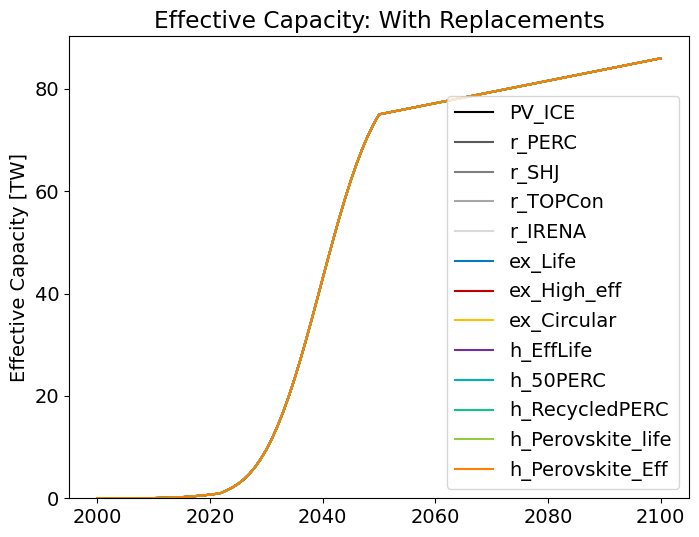

In [135]:
effective_capacity = cc_yearly.filter(like='ActiveCapacity')
plt.plot(effective_capacity/1e6)
plt.legend(sim1.scenario.keys())
plt.ylabel('Effective Capacity [TW]')
plt.title('Effective Capacity: With Replacements')
plt.ylim(0,)

(0.0, 341.9988000904351)

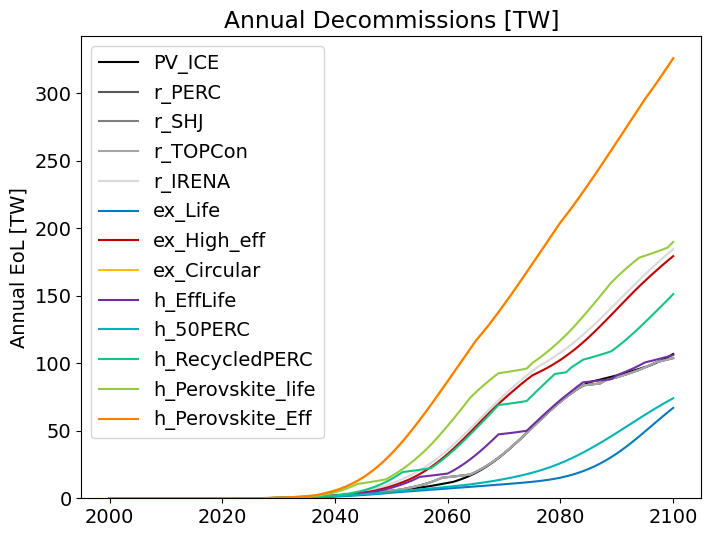

In [136]:
annual_EoL = cc_yearly.filter(like='DecommisionedCapacity')
plt.plot(annual_EoL/1e6)
plt.legend(sim1.scenario.keys())
plt.ylabel('Annual EoL [TW]')
plt.title('Annual Decommissions [TW]')
plt.ylim(0,)

(0.0, 8.641328493588126)

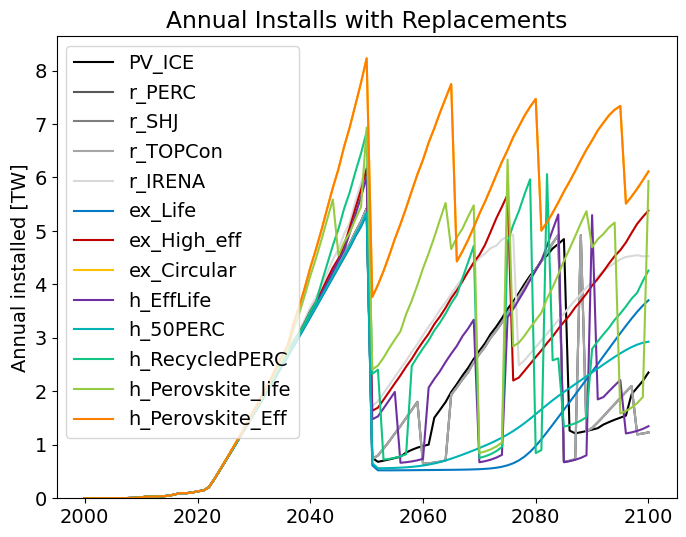

In [227]:
annual_installs = cc_yearly.filter(like='newInstalled')
plt.plot(annual_installs/1e6)
plt.legend(sim1.scenario.keys())
plt.ylabel('Annual installed [TW]')
plt.title('Annual Installs with Replacements')
plt.ylim(0,)

#### Fixing Jagged Lines

In [228]:
annual_installs = cc_yearly.filter(like='newInstalled')
posttransinstalls = annual_installs.loc[2051:,].cumsum()
flatinstallslate = posttransinstalls.loc[2100]/(2100-2050)
flatinstallslate

newInstalledCapacity_sim1_PV_ICE_[MW]               2.221055e+06
newInstalledCapacity_sim1_r_PERC_[MW]               2.159963e+06
newInstalledCapacity_sim1_r_SHJ_[MW]                2.159963e+06
newInstalledCapacity_sim1_r_TOPCon_[MW]             2.159963e+06
newInstalledCapacity_sim1_r_IRENA_[MW]              3.618366e+06
newInstalledCapacity_sim1_ex_Life_[MW]              1.324735e+06
newInstalledCapacity_sim1_ex_High_eff_[MW]          3.595318e+06
newInstalledCapacity_sim1_ex_Circular_[MW]          5.985499e+06
newInstalledCapacity_sim1_h_EffLife_[MW]            2.153960e+06
newInstalledCapacity_sim1_h_50PERC_[MW]             1.467608e+06
newInstalledCapacity_sim1_h_RecycledPERC_[MW]       2.789712e+06
newInstalledCapacity_sim1_h_Perovskite_life_[MW]    3.654927e+06
newInstalledCapacity_sim1_h_Perovskite_Eff_[MW]     5.985499e+06
Name: 2100, dtype: float64

In [229]:
annual_installs_modify = annual_installs.copy()
for col in annual_installs_modify:
    annual_installs_modify.loc[2051:,col] = flatinstallslate[col]

#annual_installs_modify
#plt.plot(annual_installs_modify)

In [230]:
#decade binning of post 2050 installs by decade
posttransinstalls_annual = annual_installs.loc[2051:,]
posttransinstalls_decades = posttransinstalls_annual.groupby(np.arange(len(posttransinstalls_annual))//10).sum()
posttransinstalls_decades.index = ['2051-2060','2061-2070','2071-2080','2081-2090','2091-2100']
posttransinstalls_decades
#this is the sum each decade, still need to divide by 10 for annual

newInstalledCapacity_sim1_PV_ICE_[MW]  \
2051-2060                           8.084245e+06   
2061-2070                           2.017992e+07   
2071-2080                           3.606240e+07   
2081-2090                           2.952406e+07   
2091-2100                           1.720211e+07   

           newInstalledCapacity_sim1_r_PERC_[MW]  \
2051-2060                           1.169166e+07   
2061-2070                           1.655666e+07   
2071-2080                           3.546531e+07   
2081-2090                           2.832288e+07   
2091-2100                           1.596166e+07   

           newInstalledCapacity_sim1_r_SHJ_[MW]  \
2051-2060                          1.169167e+07   
2061-2070                          1.655666e+07   
2071-2080                          3.546531e+07   
2081-2090                          2.832288e+07   
2091-2100                          1.596166e+07   

           newInstalledCapacity_sim1_r_TOPCon_[MW]  \
2051-2060                             1.169166e+07   
2061-2070                             1.655666e+07   
2071-2080                             3.546531e+07   
2081-2090                             2.832288e+07   
2091-2100                             1.596166e+07   

           newInstalledCapacity_sim1_r_IRENA_[MW]  \
2051-2060                            2.354720e+07   
2061-2070                            3.876813e+07   
2071-2080                            3.924160e+07   
2081-2090                            3.511517e+07   
2091-2100                            4.424623e+07   

           newInstalledCapacity_sim1_ex_Life_[MW]  \
2051-2060                            5.336494e+06   
2061-2070                            5.341243e+06   
2071-2080                            6.876479e+06   
2081-2090                            1.730013e+07   
2091-2100                            3.138243e+07   

           newInstalledCapacity_sim1_ex_High_eff_[MW]  \
2051-2060                                2.239811e+07   
2061-2070                                3.818909e+07   
2071-2080                                3.808882e+07   
2081-2090                                3.365549e+07   
2091-2100                                4.743439e+07   

           newInstalledCapacity_sim1_ex_Circular_[MW]  \
2051-2060                                5.009420e+07   
2061-2070                                6.028416e+07   
2071-2080                                6.584287e+07   
2081-2090                                5.837160e+07   
2091-2100                                6.468215e+07   

           newInstalledCapacity_sim1_h_EffLife_[MW]  \
2051-2060                              1.199032e+07   
2061-2070                              2.500011e+07   
2071-2080                              2.585843e+07   
2081-2090                              2.843517e+07   
2091-2100                              1.641395e+07   

           newInstalledCapacity_sim1_h_50PERC_[MW]  \
2051-2060                             5.860633e+06   
2061-2070                             7.692541e+06   
2071-2080                             1.247427e+07   
2081-2090                             2.018488e+07   
2091-2100                             2.716805e+07   

           newInstalledCapacity_sim1_h_RecycledPERC_[MW]  \
2051-2060                                   1.648322e+07   
2061-2070                                   3.428366e+07   
2071-2080                                   3.121564e+07   
2081-2090                                   2.203251e+07   
2091-2100                                   3.547056e+07   

           newInstalledCapacity_sim1_h_Perovskite_life_[MW]  \
2051-2060                                      3.184281e+07   
2061-2070                                      4.637377e+07   
2071-2080                                      2.544112e+07   
2081-2090                                      4.455346e+07   
2091-2100                                      3.453517e+07   

           newInstalledCapacity_s

In [231]:
annual_installs_decademod = annual_installs.copy()
for col in annual_installs_decademod:
    annual_installs_decademod.loc[2051:2060,col] = posttransinstalls_decades.loc['2051-2060',col]/10
    annual_installs_decademod.loc[2061:2070,col] = posttransinstalls_decades.loc['2061-2070',col]/10
    annual_installs_decademod.loc[2071:2080,col] = posttransinstalls_decades.loc['2071-2080',col]/10
    annual_installs_decademod.loc[2081:2090,col] = posttransinstalls_decades.loc['2081-2090',col]/10
    annual_installs_decademod.loc[2091:2100,col] = posttransinstalls_decades.loc['2091-2100',col]/10
    
#plt.plot(annual_installs_decademod)

In [232]:
annual_installs_decademod_GW = np.round(annual_installs_decademod/1e3,2)
annual_installs_decademod_GW.to_csv(os.path.join(testfolder, 'cc_annual_installs_decademod_GW.csv'))

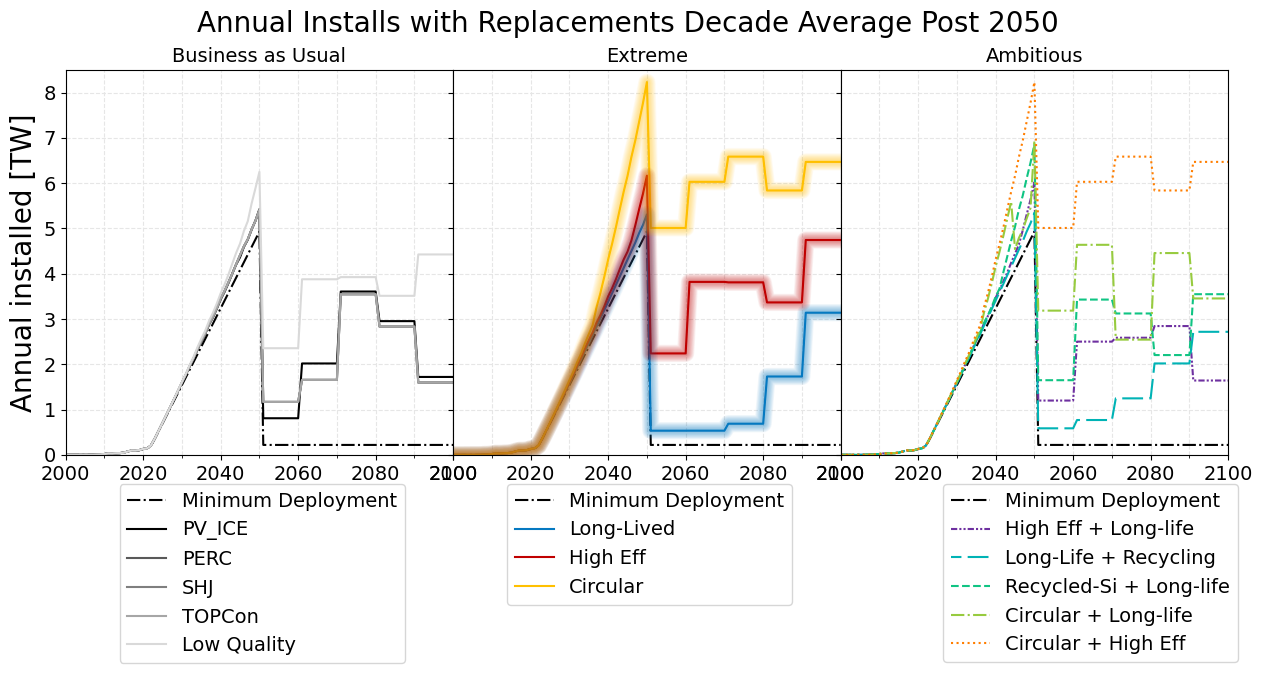

In [233]:
#annual_installs_TW = cc_yearly.filter(like='newInstalled')
annual_installs_decademod_TW = annual_installs_decademod/1e6


fig_installs_annual, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(15,5), sharey=True, sharex=True, 
                                      gridspec_kw={'wspace':0})

ax1.plot(global_projection['World_Annual_[MW]']/1e6, label='Minimum Deployment', ls='dashdot')
#BAU
ax1.set_prop_cycle(color=colorpalette[0:5])
ax1.plot(annual_installs_decademod_TW.iloc[:,0:5], label=scennames_labels_flat[0:5]) # baselines
ax1.set_title('Business as Usual', fontsize=14)
ax1.set_ylabel('Annual installed [TW]', fontsize=20)
ax1.set_xlim(2000,2100)
ax1.set_ylim(0,8.5)
ax1.legend(bbox_to_anchor=(0.9,-0.05))
ax1.xaxis.set_minor_locator(MultipleLocator(10))
ax1.grid(axis='both', which='both', color='0.9', ls='--')


#Extreme
ax2.plot(global_projection['World_Annual_[MW]']/1e6, label='Minimum Deployment', ls='dashdot')
ax2.set_prop_cycle(color=colorpalette[5:8])
#ax2.plot(annual_installs_TW.iloc[:,4:7], label=scennames_labels_flat[4:7], ls='--')
ax2.plot(annual_installs_decademod_TW.iloc[:,5:8], label=scennames_labels_flat[5:8]) #, color=colorpalette[4:7])
ax2.xaxis.set_minor_locator(MultipleLocator(10))
ax2.grid(axis='both', which='both', color='0.9', ls='--')

#create glowlines for Extreme scens
n_lines = 10
diff_linewidth = 1.05
alpha_value = 0.05
for n in range(1, n_lines+1):    
    ax2.plot(annual_installs_decademod_TW.iloc[:,5],
            linewidth=2+(diff_linewidth*n),
            alpha=alpha_value,
            color=colorpalette[5])

for n in range(1, n_lines+1):    
    ax2.plot(annual_installs_decademod_TW.iloc[:,6],
            linewidth=2+(diff_linewidth*n),
            alpha=alpha_value,
            color=colorpalette[6])

for n in range(1, n_lines+1):    
    ax2.plot(annual_installs_decademod_TW.iloc[:,7],
            linewidth=2+(diff_linewidth*n),
            alpha=alpha_value,
            color=colorpalette[7])

ax2.set_title('Extreme', fontsize=14)
ax2.legend(bbox_to_anchor=(0.9,-0.05))


#Ambitious
ax3.plot(global_projection['World_Annual_[MW]']/1e6, label='Minimum Deployment', ls='dashdot')
ax3.set_prop_cycle(color=colorpalette[8:])
ax3.plot(annual_installs_decademod_TW.iloc[:,8], label=scennames_labels_flat[8], ls=(0, (3, 1, 1, 1, 1, 1)))# 
ax3.plot(annual_installs_decademod_TW.iloc[:,9], label=scennames_labels_flat[9], ls=(5, (10, 3)))# 
ax3.plot(annual_installs_decademod_TW.iloc[:,10], label=scennames_labels_flat[10], ls='--')# 
ax3.plot(annual_installs_decademod_TW.iloc[:,11], label=scennames_labels_flat[11], ls='-.')# 
ax3.plot(annual_installs_decademod_TW.iloc[:,12], label=scennames_labels_flat[12], ls=':')# 


ax3.set_title('Ambitious', fontsize=14)
ax3.legend(bbox_to_anchor=(1.05,-0.05)) #(x,y)
ax3.xaxis.set_minor_locator(MultipleLocator(10))
ax3.grid(axis='both', which='both', color='0.9', ls='--') 


#overall figure
fig_installs_annual.suptitle('Annual Installs with Replacements Decade Average Post 2050', fontsize=20, y=1)
plt.show()
fig_installs_annual.savefig('energyresults-annualInstalls-decade.png', dpi=300, bbox_inches='tight')

(0.0, 421.4995979154807)

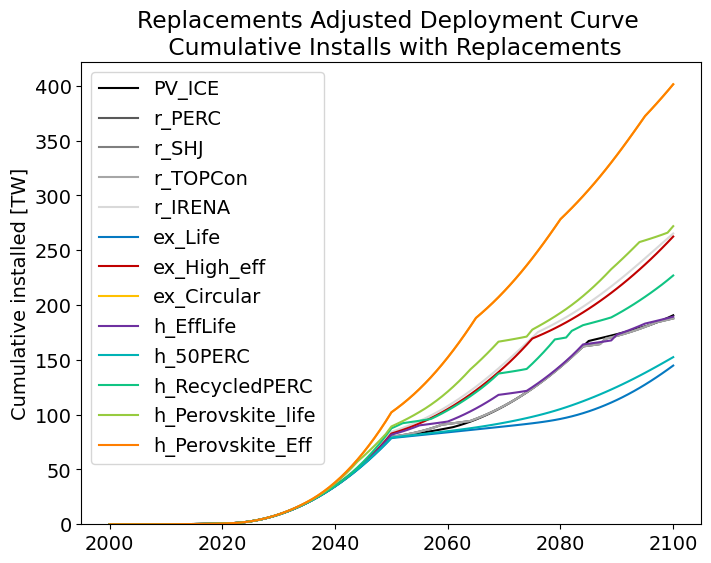

In [234]:
cumu_installs_annually = cc_cumu.filter(like='newInstalled')
plt.plot(cumu_installs_annually/1e6)
plt.legend(sim1.scenario.keys())
plt.ylabel('Cumulative installed [TW]')
plt.title('Replacements Adjusted Deployment Curve \n Cumulative Installs with Replacements')
plt.ylim(0,)

(0.0, 410.0)

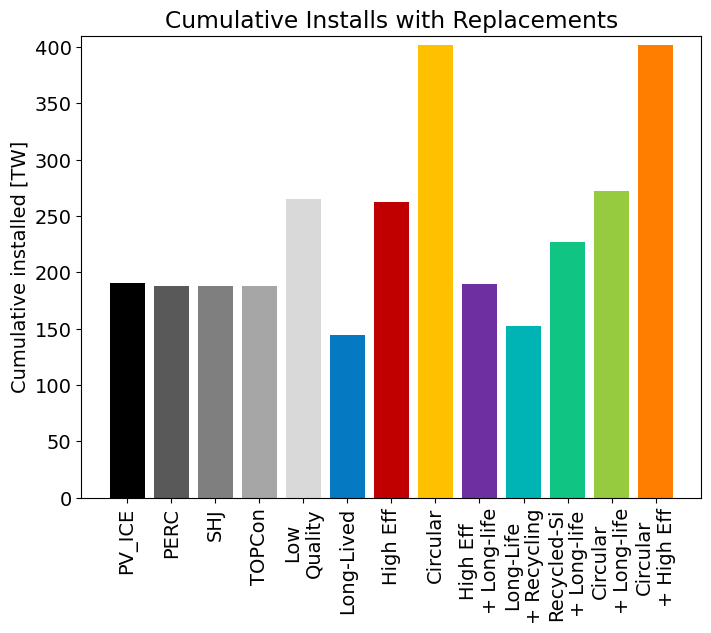

In [235]:
cumu_installs = cc_cumu.filter(like='newInstalled')
plt.bar(scennames_labels, cumu_installs.loc[2100]/1e6, tick_label=scennames_labels, color=colorpalette)
#plt.legend(scennames)
plt.xticks(rotation=90)
plt.ylabel('Cumulative installed [TW]')
plt.title('Cumulative Installs with Replacements')
plt.ylim(0,410)

In [236]:
total_deploy = cumu_installs.iloc[-1,]/1e6
total_deploy.index = scennames_labels_flat

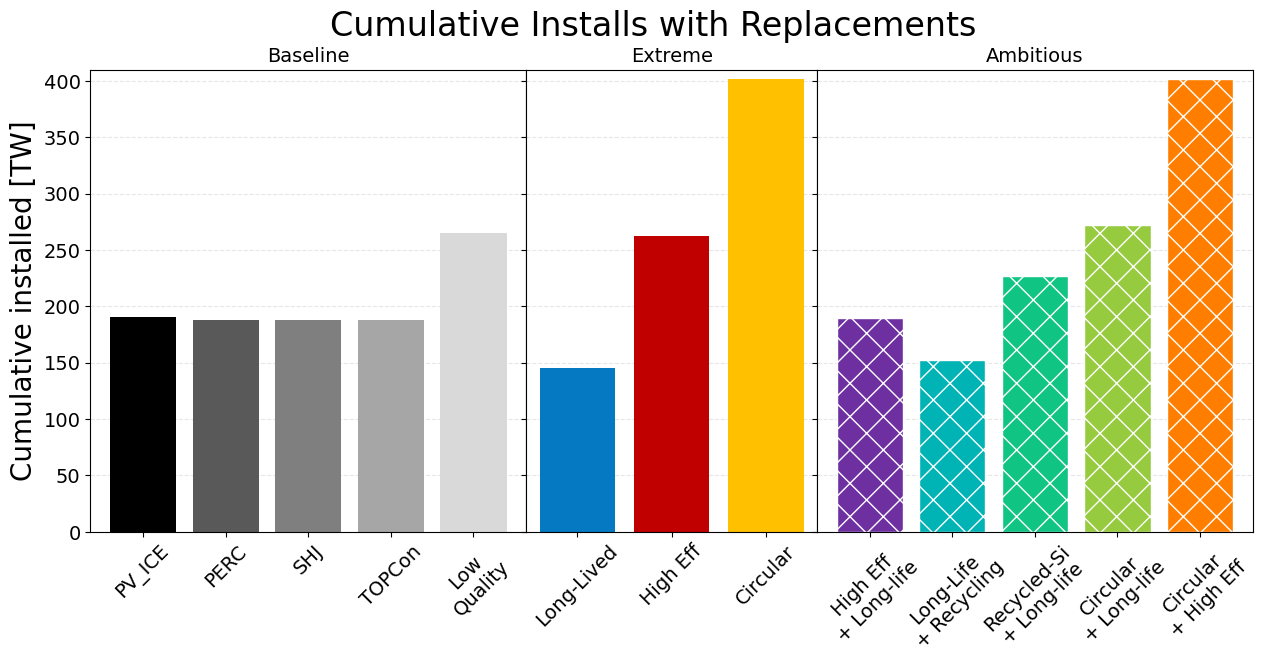

In [237]:
cumu_installs = cc_cumu.filter(like='newInstalled')

fig_installs_cumu, (ax0,ax2,ax3) = plt.subplots(1,3,figsize=(15,6), sharey=True, 
                                      gridspec_kw={'wspace': 0, 'width_ratios': [1.5,1,1.5]})
#BAU
ax0.bar(scennames_labels[0:5], cumu_installs.iloc[-1,0:5]/1e6,# width=0.1, 
        tick_label=scennames_labels[0:5], color=colorpalette[0:5])
ax0.set_ylim(0,410)
ax0.set_ylabel('Cumulative installed [TW]', fontsize=20)
ax0.set_title('Baseline', fontsize=14)
ax0.set_xticklabels(labels=scennames_labels[0:5], rotation=45)
ax0.grid(axis='y', color='0.9', ls='--') 
ax0.set_axisbelow(True)

#Extreme
ax2.bar(scennames_labels[5:8], cumu_installs.iloc[-1,5:8]/1e6, #width=0.8,
        tick_label=scennames_labels[5:8], color=colorpalette[5:8])
ax2.set_title('Extreme', fontsize=14)
ax2.set_xticklabels(labels=scennames_labels[5:8], rotation=45)
ax2.grid(axis='y', color='0.9', ls='--') 
ax2.set_axisbelow(True)

#Ambitious
ax3.bar(scennames_labels[8:], cumu_installs.iloc[-1,8:]/1e6, #width=0.8,
        tick_label=scennames_labels[8:], color=colorpalette[8:], hatch='x', edgecolor='white')
ax3.set_title('Ambitious', fontsize=14)
ax3.set_xticklabels(labels=scennames_labels[8:], rotation=45)
ax3.grid(axis='y', color='0.9', ls='--') 
ax3.set_axisbelow(True)

#overall fig
fig_installs_cumu.suptitle('Cumulative Installs with Replacements', fontsize=24)

plt.show()

fig_installs_cumu.savefig('energyresults-cumulativedeploy.png', dpi=300, bbox_inches='tight')

In [238]:
cumulative_nameplate_installs = global_projection.loc[2100,'World_Cumu_[MW]'] #MW
print('The nameplate installations for energy transition and through 2100 are '+str(cumulative_nameplate_installs/1e6)+' TW.')

The nameplate installations for energy transition and through 2100 are 85.966 TW.


In [239]:
global_projection['World_Annual_[MW]'].sum()

85965999.99955177

Additional_installs = cumu_installs.loc[2100]-global_projection.loc[2100,'World_cum']
plt.bar(scennames_labels, Additional_installs/1e6, tick_label=scennames_labels, color=colorpalette)
#plt.legend(scennames)
plt.ylabel('Cumulative Replacements [TW]')
plt.title('Replacements Required by Technology')
plt.xticks(rotation=90)
plt.ylim(0,410)

# RESULTS: Virgin Material Demands

cumu_virgin_module = cc_cumu.filter(like='VirginStock_Module')
plt.bar(scennames_labels, cumu_virgin_module.loc[2100]/1e9, tick_label=scennames_labels, color=colorpalette)
#plt.legend(scennames)
plt.title('Cumulative Virgin Material Demands')
plt.ylabel('Virgin Material Requirements\n[billion tonnes]')
plt.xticks(rotation=90)

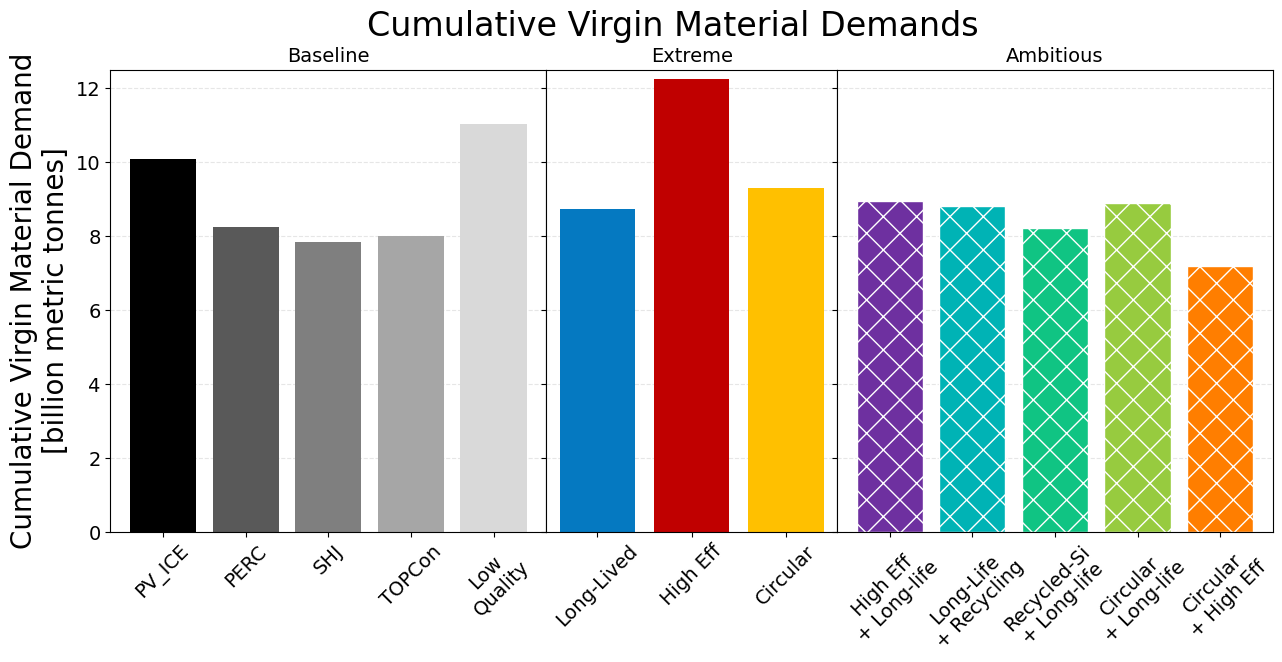

In [240]:
cumu_virgin_module_bt = cc_cumu.filter(like='VirginStock_Module')/1e9

fig_vmat_cumu, (ax0,ax2,ax3) = plt.subplots(1,3,figsize=(15,6), sharey=True, 
                                      gridspec_kw={'wspace': 0, 'width_ratios': [1.5,1,1.5]})
#BAU
ax0.bar(scennames_labels[0:5], cumu_virgin_module_bt.iloc[-1,0:5],# width=0.1, 
        tick_label=scennames_labels[0:5], color=colorpalette[0:5])
ax0.set_ylim(0,12.5)
ax0.set_ylabel('Cumulative Virgin Material Demand\n[billion metric tonnes]', fontsize=20)
ax0.set_title('Baseline', fontsize=14)
ax0.set_xticklabels(labels=scennames_labels[0:5], rotation=45)
ax0.grid(axis='y', color='0.9', ls='--') 
ax0.set_axisbelow(True)

#Extreme
ax2.bar(scennames_labels[5:8], cumu_virgin_module_bt.iloc[-1,5:8], #width=0.8,
        tick_label=scennames_labels[5:8], color=colorpalette[5:8])
ax2.set_title('Extreme', fontsize=14)
ax2.set_xticklabels(labels=scennames_labels[5:8], rotation=45)
ax2.grid(axis='y', color='0.9', ls='--') 
ax2.set_axisbelow(True)

#Ambitious
ax3.bar(scennames_labels[8:], cumu_virgin_module_bt.iloc[-1,8:], #width=0.8,
        tick_label=scennames_labels[8:], color=colorpalette[8:], hatch='x', edgecolor='white')
ax3.set_title('Ambitious', fontsize=14)
ax3.set_xticklabels(labels=scennames_labels[8:], rotation=45)
ax3.grid(axis='y', color='0.9', ls='--') 
ax3.set_axisbelow(True)

#overall fig
fig_vmat_cumu.suptitle('Cumulative Virgin Material Demands', fontsize=24)
plt.show()

fig_vmat_cumu.savefig('energyresults-cumuMatDemand.png', dpi=300, bbox_inches='tight')

In [241]:
virgin = cumu_virgin_module_bt.iloc[-1,:]
virgin.index=scennames_labels_flat

Text(0, 0.5, 'Million Metric tonnes')

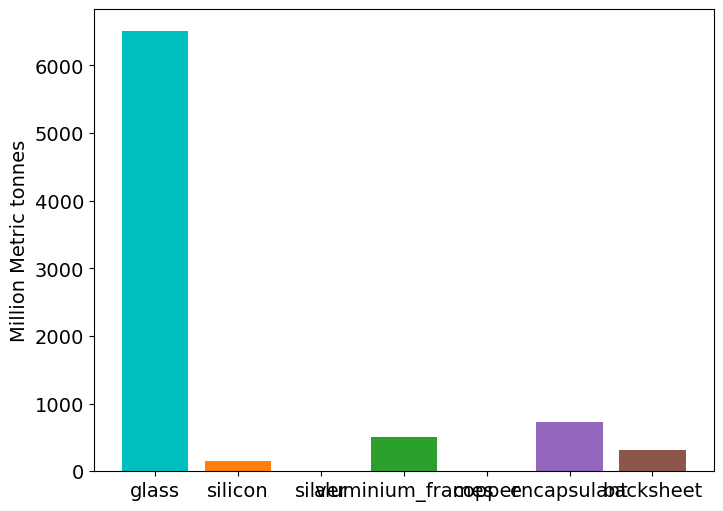

In [242]:
recycledperc_virginstock = cc_cumu.filter(like='VirginStock').filter(like='Recycled')
recycledperc_virginstock.drop('VirginStock_Module_sim1_h_RecycledPERC_[Tonnes]',axis=1, inplace=True)
plt.bar(recycledperc_virginstock.columns, recycledperc_virginstock.loc[2100]/1e6, tick_label = MATERIALS, color=colormats)
plt.ylabel('Million Metric tonnes')

cumu_virgin_module = cc_cumu.filter(like='VirginStock_Module')
plt.plot(cumu_virgin_module/1e9)
plt.legend(scennames_labels_flat)
plt.title('Cumulative Virgin Material Extraction: Module')
plt.ylabel('Virgin Material Requirements\n[billion tonnes]')
plt.ylim(0,)

(0.0, 457.5520683054622)

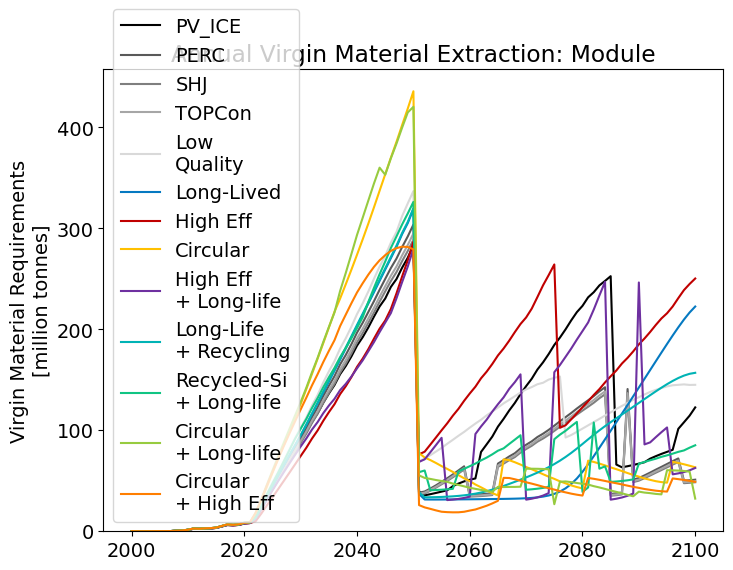

In [243]:
annual_virgin_module = cc_yearly.filter(like='VirginStock_Module')
plt.plot(annual_virgin_module/1e6)
plt.legend(scennames_labels)
plt.title('Annual Virgin Material Extraction: Module')
plt.ylabel('Virgin Material Requirements\n[million tonnes]')
plt.ylim(0,)

annual_virgin_module_mt = annual_virgin_module/1e6

fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(15,5), sharey=True, sharex=True, 
                                      gridspec_kw={'wspace':0})

#BAU
ax1.set_prop_cycle(color=colorpalette[0:5])
ax1.plot(annual_virgin_module_mt.iloc[:,0:5], label=scennames_labels_flat[0:5]) # baselines
ax1.set_title('Business as Usual', fontsize=14)
ax1.set_ylabel('Annual Material Demands\n[million metric tonnes]', fontsize=20)
ax1.set_xlim(2000,2100)
ax1.set_ylim(0,8.5)
ax1.legend(bbox_to_anchor=(0.9,-0.05))
ax1.set_ylim(0,450)


#Extreme
ax2.set_prop_cycle(color=colorpalette[5:8])

ax2.plot(annual_virgin_module_mt.iloc[:,5:8], label=scennames_labels_flat[5:8])

#create glowlines for Extreme scens
n_lines = 10
diff_linewidth = 1.05
alpha_value = 0.05
for n in range(1, n_lines+1):    
    ax2.plot(annual_virgin_module_mt.iloc[:,5],
            linewidth=2+(diff_linewidth*n),
            alpha=alpha_value,
            color=colorpalette[5])

for n in range(1, n_lines+1):    
    ax2.plot(annual_virgin_module_mt.iloc[:,6],
            linewidth=2+(diff_linewidth*n),
            alpha=alpha_value,
            color=colorpalette[6])

for n in range(1, n_lines+1):    
    ax2.plot(annual_virgin_module_mt.iloc[:,7],
            linewidth=2+(diff_linewidth*n),
            alpha=alpha_value,
            color=colorpalette[7])

ax2.set_title('Extreme', fontsize=14)
ax2.legend(bbox_to_anchor=(0.9,-0.05))

#Ambitious
ax3.set_prop_cycle(color=colorpalette[8:])
ax3.plot(annual_virgin_module_mt.iloc[:,8:], label=scennames_labels_flat[8:], ls='--')# 
ax3.set_title('Ambitious', fontsize=14)
ax3.legend(bbox_to_anchor=(1.05,-0.05)) #(x,y)

#overall figure
fig.suptitle('Annual Material Demands', fontsize=24, y=1)
plt.show()
fig.savefig('energyresults-annualMatDemands.png', dpi=300, bbox_inches='tight')

In [244]:
#do it by decade to match up with annual installs graphs
annual_virgin_module = cc_yearly.filter(like='VirginStock_Module')
virgin_module_annual = annual_virgin_module.loc[2051:,]
virgin_module_decades = virgin_module_annual.groupby(np.arange(len(virgin_module_annual))//10).sum()
virgin_module_decades.index = ['2051-2060','2061-2070','2071-2080','2081-2090','2091-2100']
virgin_module_decades
#this is the sum each decade, still need to divide by 10 for annual

VirginStock_Module_sim1_PV_ICE_[Tonnes]  \
2051-2060                             4.220275e+08   
2061-2070                             1.052121e+09   
2071-2080                             1.879663e+09   
2081-2090                             1.539121e+09   
2091-2100                             8.971855e+08   

           VirginStock_Module_sim1_r_PERC_[Tonnes]  \
2051-2060                             4.839221e+08   
2061-2070                             6.044583e+08   
2071-2080                             1.070382e+09   
2081-2090                             9.026544e+08   
2091-2100                             5.981208e+08   

           VirginStock_Module_sim1_r_SHJ_[Tonnes]  \
2051-2060                            4.598659e+08   
2061-2070                            5.746617e+08   
2071-2080                            1.017616e+09   
2081-2090                            8.581590e+08   
2091-2100                            5.686381e+08   

           VirginStock_Module_sim1_r_TOPCon_[Tonnes]  \
2051-2060                               4.696811e+08   
2061-2070                               5.869387e+08   
2071-2080                               1.039357e+09   
2081-2090                               8.764918e+08   
2091-2100                               5.807857e+08   

           VirginStock_Module_sim1_r_IRENA_[Tonnes]  \
2051-2060                              8.512090e+08   
2061-2070                              1.241424e+09   
2071-2080                              1.279354e+09   
2081-2090                              1.192064e+09   
2091-2100                              1.423912e+09   

           VirginStock_Module_sim1_ex_Life_[Tonnes]  \
2051-2060                              3.207434e+08   
2061-2070                              3.210288e+08   
2071-2080                              4.133023e+08   
2081-2090                              1.039803e+09   
2091-2100                              1.886202e+09   

           VirginStock_Module_sim1_ex_High_eff_[Tonnes]  \
2051-2060                                  1.042054e+09   
2061-2070                                  1.776717e+09   
2071-2080                                  1.772052e+09   
2081-2090                                  1.565795e+09   
2091-2100                                  2.206847e+09   

           VirginStock_Module_sim1_ex_Circular_[Tonnes]  \
2051-2060                                  6.313944e+08   
2061-2070                                  5.434961e+08   
2071-2080                                  5.114741e+08   
2081-2090                                  6.228530e+08   
2091-2100                                  5.808271e+08   

           VirginStock_Module_sim1_h_EffLife_[Tonnes]  \
2051-2060                                5.578403e+08   
2061-2070                                1.163110e+09   
2071-2080                                1.203043e+09   
2081-2090                                1.322924e+09   
2091-2100                                7.636461e+08   

           VirginStock_Module_sim1_h_50PERC_[Tonnes]  \
2051-2060                               3.495455e+08   
2061-2070                               4.448512e+08   
2071-2080                               6.940257e+08   
2081-2090                               1.096209e+09   
2091-2100                               1.459864e+09   

           VirginStock_Module_sim1_h_RecycledPERC_[Tonnes]  \
2051-2060                                     5.105496e+08   
2061-2070                                     7.617865e+08   
2071-2080                                     7.084091e+08   
2081-2090                                     5.941487e+08   
2091-2100                                     7.633263e+08   

           VirginStock_Module_sim1_h_Perovskite_life_[Tonnes]  \
2051-2060                                       4.902461e+08    
2061-2070                                       4.438205e+08    
2071-2080                                       5.156364e+08    
2081-2090           

In [245]:
annual_virgin_module_decademod = annual_virgin_module.copy()
for col in annual_virgin_module_decademod:
    annual_virgin_module_decademod.loc[2051:2060,col] = virgin_module_decades.loc['2051-2060',col]/10
    annual_virgin_module_decademod.loc[2061:2070,col] = virgin_module_decades.loc['2061-2070',col]/10
    annual_virgin_module_decademod.loc[2071:2080,col] = virgin_module_decades.loc['2071-2080',col]/10
    annual_virgin_module_decademod.loc[2081:2090,col] = virgin_module_decades.loc['2081-2090',col]/10
    annual_virgin_module_decademod.loc[2091:2100,col] = virgin_module_decades.loc['2091-2100',col]/10
    
#plt.plot(annual_virgin_module_decademod)

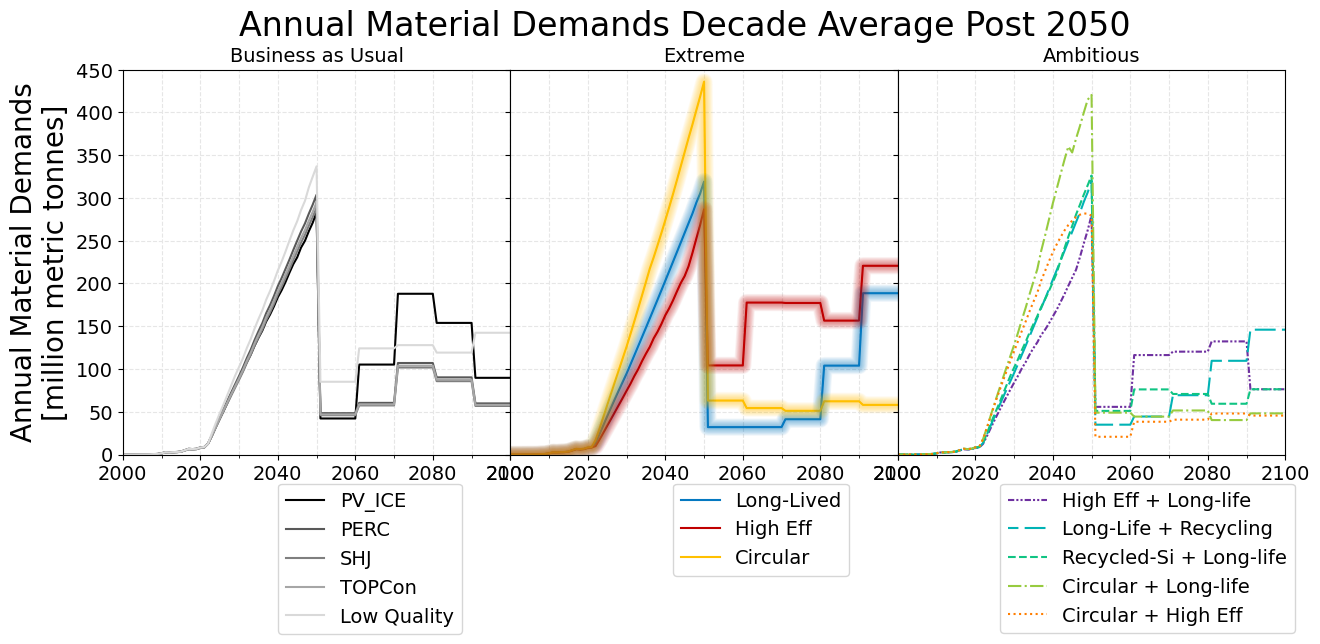

In [246]:
annual_virgin_module_decademod_mt = annual_virgin_module_decademod/1e6

fig_vmat_annual, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(15,5), sharey=True, sharex=True, 
                                      gridspec_kw={'wspace':0})

#BAU
ax1.set_prop_cycle(color=colorpalette[0:5])
ax1.plot(annual_virgin_module_decademod_mt.iloc[:,0:5], label=scennames_labels_flat[0:5]) # baselines
ax1.set_title('Business as Usual', fontsize=14)
ax1.set_ylabel('Annual Material Demands\n[million metric tonnes]', fontsize=20)
ax1.set_xlim(2000,2100)
ax1.set_ylim(0,8.5)
ax1.legend(bbox_to_anchor=(0.9,-0.05))
ax1.set_ylim(0,450)
ax1.xaxis.set_minor_locator(MultipleLocator(10))
ax1.grid(axis='both', which='both', color='0.9', ls='--') 


#Extreme
ax2.set_prop_cycle(color=colorpalette[5:8])

ax2.plot(annual_virgin_module_decademod_mt.iloc[:,5:8], label=scennames_labels_flat[5:8])
ax2.xaxis.set_minor_locator(MultipleLocator(10))
ax2.grid(axis='both', which='both', color='0.9', ls='--') 

#create glowlines for Extreme scens
n_lines = 10
diff_linewidth = 1.05
alpha_value = 0.05
for n in range(1, n_lines+1):    
    ax2.plot(annual_virgin_module_decademod_mt.iloc[:,5],
            linewidth=2+(diff_linewidth*n),
            alpha=alpha_value,
            color=colorpalette[5])

for n in range(1, n_lines+1):    
    ax2.plot(annual_virgin_module_decademod_mt.iloc[:,6],
            linewidth=2+(diff_linewidth*n),
            alpha=alpha_value,
            color=colorpalette[6])

for n in range(1, n_lines+1):    
    ax2.plot(annual_virgin_module_decademod_mt.iloc[:,7],
            linewidth=2+(diff_linewidth*n),
            alpha=alpha_value,
            color=colorpalette[7])

ax2.set_title('Extreme', fontsize=14)
ax2.legend(bbox_to_anchor=(0.9,-0.05))

#Ambitious
ax3.set_prop_cycle(color=colorpalette[8:])
ax3.plot(annual_virgin_module_decademod_mt.iloc[:,8], label=scennames_labels_flat[8], ls=(0, (3, 1, 1, 1, 1, 1)))# 
ax3.plot(annual_virgin_module_decademod_mt.iloc[:,9], label=scennames_labels_flat[9], ls=(5, (10, 3)))# 
ax3.plot(annual_virgin_module_decademod_mt.iloc[:,10], label=scennames_labels_flat[10], ls='--')# 
ax3.plot(annual_virgin_module_decademod_mt.iloc[:,11], label=scennames_labels_flat[11], ls='-.')# 
ax3.plot(annual_virgin_module_decademod_mt.iloc[:,12], label=scennames_labels_flat[12], ls=':')# 


ax3.set_title('Ambitious', fontsize=14)
ax3.legend(bbox_to_anchor=(1.05,-0.05)) #(x,y)
ax3.xaxis.set_minor_locator(MultipleLocator(10))
ax3.grid(axis='both', which='both', color='0.9', ls='--') 

#overall figure

fig_vmat_annual.suptitle('Annual Material Demands Decade Average Post 2050', fontsize=24, y=1)
plt.show()
fig_vmat_annual.savefig('energyresults-annualMatDemands-decade.png', dpi=300, bbox_inches='tight')

plt.fig_effectiveCap
fig_installs_annual
fig_vmat_annual

In [247]:
#print out masses for stacked bar charts
#mass_cumu = cc_cumu.loc[[2100]].filter(like='PV_ICE_[Tonnes]')
mass_cumu_virgin = cc_cumu.filter(like='VirginStock').loc[2100]
mass_cumu_wasteall = cc_cumu.filter(like='WasteAll').loc[2100]
mass_cumu = pd.concat([mass_cumu_virgin,mass_cumu_wasteall])
mass_cumu.to_csv(os.path.join(testfolder, 'cc_cumu_mass_2100results.csv'))

In [248]:
cc_cumu.to_csv(os.path.join(testfolder, 'cc_cumu_mass_results.csv'))

# RESULTS: Lifecycle Wastes

cumu_lifecycle_wastes = cc_cumu.filter(like='WasteAll_Module')

plt.bar(scennames_labels, cumu_lifecycle_wastes.loc[2100]/1e9, 
        tick_label=scennames_labels, color=colorpalette)
#plt.legend(scennames)
plt.title('Cumulative Lifecycle Wastes')
plt.ylabel('Lifecycle Wastes\n[billion tonnes]')
plt.xticks(rotation=90)

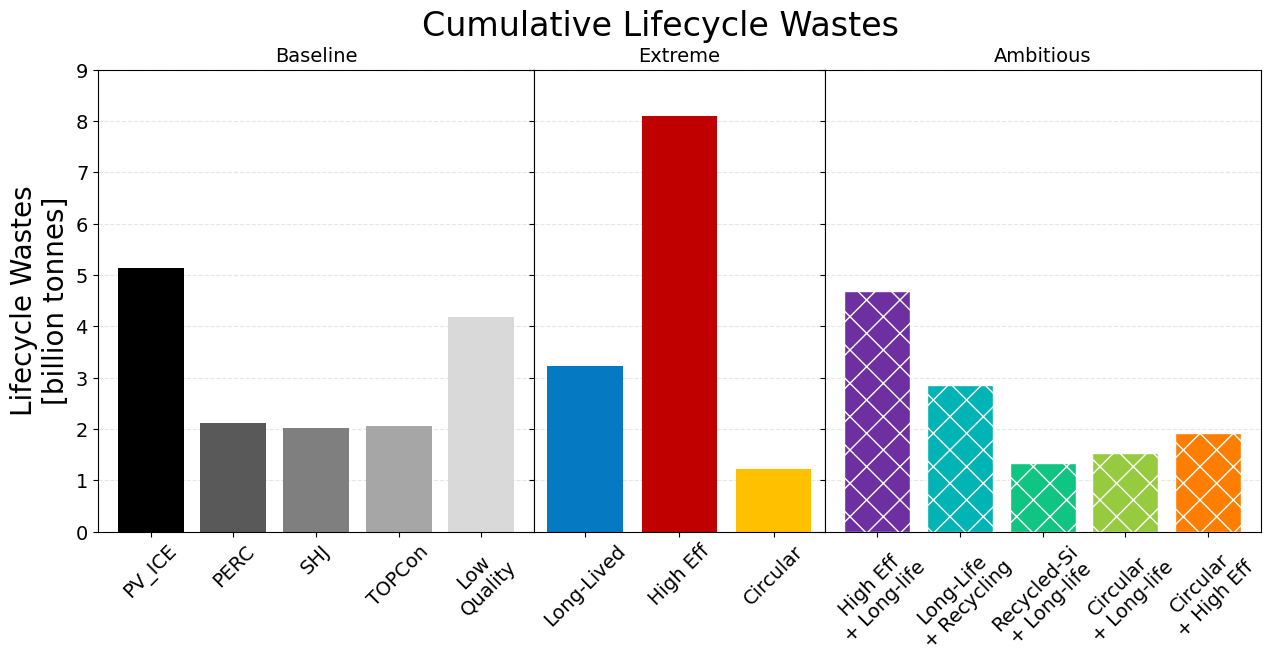

In [249]:
cumu_lifecycle_wastes_bt = cc_cumu.filter(like='WasteAll_Module')/1e9

fig_wastes, (ax0,ax2,ax3) = plt.subplots(1,3,figsize=(15,6), sharey=True, 
                                      gridspec_kw={'wspace': 0, 'width_ratios': [1.5,1,1.5]})
#BAU
ax0.bar(scennames_labels[0:5], cumu_lifecycle_wastes_bt.iloc[-1,0:5],# width=0.1, 
        tick_label=scennames_labels[0:5], color=colorpalette[0:5])
ax0.set_ylim(0,9)
ax0.set_ylabel('Lifecycle Wastes\n[billion tonnes]', fontsize=20)
ax0.set_title('Baseline', fontsize=14)
ax0.set_xticklabels(labels=scennames_labels[0:5], rotation=45)
ax0.grid(axis='y', color='0.9', ls='--') 
ax0.set_axisbelow(True)

#Extreme
ax2.bar(scennames_labels[5:8], cumu_lifecycle_wastes_bt.iloc[-1,5:8], #width=0.8,
        tick_label=scennames_labels[5:8], color=colorpalette[5:8])
ax2.set_title('Extreme', fontsize=14)
ax2.set_xticklabels(labels=scennames_labels[5:8], rotation=45)
ax2.grid(axis='y', color='0.9', ls='--') 
ax2.set_axisbelow(True)

#Ambitious
ax3.bar(scennames_labels[8:], cumu_lifecycle_wastes_bt.iloc[-1,8:], #width=0.8,
        tick_label=scennames_labels[8:], color=colorpalette[8:], hatch='x', edgecolor='white')
ax3.set_title('Ambitious', fontsize=14)
ax3.set_xticklabels(labels=scennames_labels[8:], rotation=45)
ax3.grid(axis='y', color='0.9', ls='--') 
ax3.set_axisbelow(True)

#overall fig
fig_wastes.suptitle('Cumulative Lifecycle Wastes', fontsize=24)
plt.show()

fig_wastes.savefig('energyresults-cumuWaste.png', dpi=300, bbox_inches='tight')

In [250]:
wastes = cumu_lifecycle_wastes_bt.iloc[-1,:]
wastes.index=scennames_labels_flat

(0.0, 285.9909035105216)

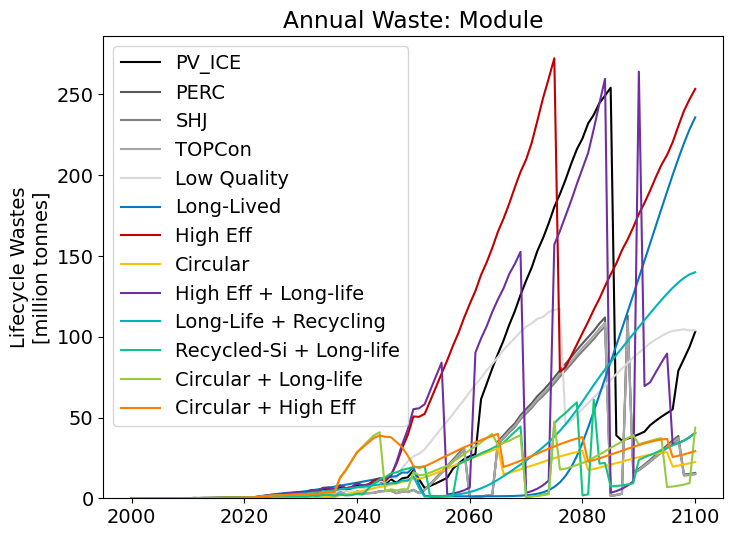

In [251]:
annual_waste_module = cc_yearly.filter(like='WasteAll_Module')
plt.plot(annual_waste_module/1e6)
plt.legend(scennames_labels_flat)
plt.title('Annual Waste: Module')
plt.ylabel('Lifecycle Wastes\n[million tonnes]')
plt.ylim(0,)

In [252]:
#do it by decade to match up with annual installs graphs
waste_module_annual = annual_waste_module.loc[2051:,]
waste_module_decades = waste_module_annual.groupby(np.arange(len(waste_module_annual))//10).sum()
waste_module_decades.index = ['2051-2060','2061-2070','2071-2080','2081-2090','2091-2100']
waste_module_decades
#this is the sum each decade, still need to divide by 10 for annual

WasteAll_Module_sim1_PV_ICE_[Tonnes]  \
2051-2060                          1.486041e+08   
2061-2070                          9.108933e+08   
2071-2080                          1.839154e+09   
2081-2090                          1.406897e+09   
2091-2100                          6.548639e+08   

           WasteAll_Module_sim1_r_PERC_[Tonnes]  \
2051-2060                          1.496903e+08   
2061-2070                          2.760397e+08   
2071-2080                          7.715851e+08   
2081-2090                          5.777745e+08   
2091-2100                          2.537908e+08   

           WasteAll_Module_sim1_r_SHJ_[Tonnes]  \
2051-2060                         1.424777e+08   
2061-2070                         2.624269e+08   
2071-2080                         7.335337e+08   
2081-2090                         5.492803e+08   
2091-2100                         2.412744e+08   

           WasteAll_Module_sim1_r_TOPCon_[Tonnes]  \
2051-2060                            1.455273e+08   
2061-2070                            2.680331e+08   
2071-2080                            7.492048e+08   
2081-2090                            5.610154e+08   
2091-2100                            2.464292e+08   

           WasteAll_Module_sim1_r_IRENA_[Tonnes]  \
2051-2060                           4.585761e+08   
2061-2070                           8.905605e+08   
2071-2080                           8.818120e+08   
2081-2090                           7.483706e+08   
2091-2100                           1.010307e+09   

           WasteAll_Module_sim1_ex_Life_[Tonnes]  \
2051-2060                           1.970195e+07   
2061-2070                           1.377886e+07   
2071-2080                           1.242771e+08   
2081-2090                           8.974020e+08   
2091-2100                           1.936591e+09   

           WasteAll_Module_sim1_ex_High_eff_[Tonnes]  \
2051-2060                               8.233827e+08   
2061-2070                               1.692441e+09   
2071-2080                               1.678985e+09   
2081-2090                               1.422095e+09   
2091-2100                               2.181817e+09   

           WasteAll_Module_sim1_ex_Circular_[Tonnes]  \
2051-2060                               1.786120e+08   
2061-2070                               2.258881e+08   
2071-2080                               2.510558e+08   
2081-2090                               2.136201e+08   
2091-2100                               2.424898e+08   

           WasteAll_Module_sim1_h_EffLife_[Tonnes]  \
2051-2060                             3.607979e+08   
2061-2070                             1.103942e+09   
2071-2080                             1.109874e+09   
2081-2090                             1.242594e+09   
2091-2100                             5.741778e+08   

           WasteAll_Module_sim1_h_50PERC_[Tonnes]  \
2051-2060                            2.426518e+07   
2061-2070                            1.322163e+08   
2071-2080                            4.118560e+08   
2081-2090                            8.610871e+08   
2091-2100                            1.271646e+09   

           WasteAll_Module_sim1_h_RecycledPERC_[Tonnes]  \
2051-2060                                  1.122939e+08   
2061-2070                                  3.057050e+08   
2071-2080                                  2.747754e+08   
2081-2090                                  1.712102e+08   
2091-2100                                  3.222844e+08   

           WasteAll_Module_sim1_h_Perovskite_life_[Tonnes]  \
2051-2060                                     2.057279e+08   
2061-2070                                     3.239871e+08   
2071-2080                                     1.526176e+08   
2081-2090                                     3.134026e+08   
2091-2100                                     2.273176e+08   

           WasteAll_Module_sim1_h_Perovskite_Eff_[Tonnes]  
2051-2060                                    

In [253]:
annual_waste_module_decademod = annual_waste_module.copy()
for col in annual_waste_module_decademod:
    annual_waste_module_decademod.loc[2051:2060,col] = waste_module_decades.loc['2051-2060',col]/10
    annual_waste_module_decademod.loc[2061:2070,col] = waste_module_decades.loc['2061-2070',col]/10
    annual_waste_module_decademod.loc[2071:2080,col] = waste_module_decades.loc['2071-2080',col]/10
    annual_waste_module_decademod.loc[2081:2090,col] = waste_module_decades.loc['2081-2090',col]/10
    annual_waste_module_decademod.loc[2091:2100,col] = waste_module_decades.loc['2091-2100',col]/10
    
#plt.plot(annual_virgin_module_decademod)

annual_waste_module_decademod_mt = annual_waste_module_decademod/1e6

fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(15,5), sharey=True, sharex=True, 
                                      gridspec_kw={'wspace':0})

#BAU
ax1.set_prop_cycle(color=colorpalette[0:5])
ax1.plot(annual_waste_module_decademod_mt.iloc[:,0:5], label=scennames_labels_flat[0:5]) # baselines
ax1.set_title('Business as Usual', fontsize=14)
ax1.set_ylabel('Lifecycle Wastes\n[million tonnes]', fontsize=20)
ax1.set_xlim(2000,2100)
ax1.set_ylim(0,225)
ax1.legend(bbox_to_anchor=(0.9,-0.05))


#Extreme
ax2.set_prop_cycle(color=colorpalette[5:8])
ax2.plot(annual_waste_module_decademod_mt.iloc[:,5:8], label=scennames_labels_flat[5:8]) #, 

#create glowlines for Extreme scens
n_lines = 10
diff_linewidth = 1.05
alpha_value = 0.05
for n in range(1, n_lines+1):    
    ax2.plot(annual_waste_module_decademod_mt.iloc[:,5],
            linewidth=2+(diff_linewidth*n),
            alpha=alpha_value,
            color=colorpalette[5])

for n in range(1, n_lines+1):    
    ax2.plot(annual_waste_module_decademod_mt.iloc[:,6],
            linewidth=2+(diff_linewidth*n),
            alpha=alpha_value,
            color=colorpalette[6])

for n in range(1, n_lines+1):    
    ax2.plot(annual_waste_module_decademod_mt.iloc[:,7],
            linewidth=2+(diff_linewidth*n),
            alpha=alpha_value,
            color=colorpalette[7])

ax2.set_title('Extreme', fontsize=14)
ax2.legend(bbox_to_anchor=(0.9,-0.05))

#Ambitious
ax3.set_prop_cycle(color=colorpalette[8:])
ax3.plot(annual_waste_module_decademod_mt.iloc[:,8:], label=scennames_labels_flat[8:], ls='--')# 
ax3.set_title('Ambitious', fontsize=14)
ax3.legend(bbox_to_anchor=(1.05,-0.05)) #(x,y)

#overall figure

fig.suptitle('Annual Lifecycle Wastes', fontsize=24, y=1)
plt.show()
fig.savefig('energyresults-annualwaste.png', dpi=300, bbox_inches='tight')

In [254]:
sim1.scenario['r_IRENA'].dataOut_m.loc[45:,]

Area  Cumulative_Active_Area  EOL_BadStatus  EOL_Landfill0  \
45   2.156352e+10            2.639097e+11   6.331016e+08   3.599990e+08   
46   2.277744e+10            2.852119e+11   7.918401e+08   5.015907e+08   
47   2.368685e+10            3.074125e+11   1.014382e+09   4.718918e+08   
48   2.541251e+10            3.302016e+11   1.849495e+09   7.739023e+08   
49   2.687649e+10            3.535782e+11   2.546148e+09   9.537117e+08   
50   2.839800e+10            3.776024e+11   3.280368e+09   1.093456e+09   
51   7.818817e+09            3.802168e+11   3.903329e+09   1.301110e+09   
52   8.259984e+09            3.827135e+11   4.322424e+09   1.440808e+09   
53   8.930657e+09            3.850321e+11   4.959089e+09   1.653030e+09   
54   9.615337e+09            3.871796e+11   5.600874e+09   1.866958e+09   
55   1.030867e+10            3.891646e+11   6.242734e+09   2.080911e+09   
56   1.100487e+10            3.909969e+11   6.879433e+09   2.293144e+09   
57   1.169021e+10            3.926599e+11   7.520413e+09   2.506804e+09   
58   1.242590e+10            3.941427e+11   8.207297e+09   2.735766e+09   
59   1.310634e+10            3.954696e+11   8.834563e+09   2.944854e+09   
60   1.387192e+10            3.966181e+11   9.542593e+09   3.180864e+09   
61   1.458040e+10            3.976117e+11   1.019008e+10   3.396694e+09   
62   1.524655e+10            3.984680e+11   1.079269e+10   3.597562e+09   
63   1.601268e+10            3.991591e+11   1.149119e+10   3.830397e+09   
64   1.666028e+10            3.997246e+11   1.207114e+10   4.023712e+09   
65   1.735453e+10            4.001519e+11   1.269542e+10   4.231808e+09   
66   1.807644e+10            4.004342e+11   1.334557e+10   4.448524e+09   
67   1.866982e+10            4.006103e+11   1.387031e+10   4.623438e+09   
68   1.928448e+10            4.006737e+11   1.441580e+10   4.805267e+09   
69   1.990126e+10            4.006238e+11   1.496336e+10   4.987787e+09   
70   2.043235e+10            4.004848e+11   1.542847e+10   5.142823e+09   
71   2.080451e+10            4.003008e+11   1.574139e+10   5.247132e+09   
72   2.126737e+10            4.000476e+11   1.614042e+10   5.380139e+09   
73   2.147611e+10            3.997955e+11   1.629615e+10   5.432049e+09   
74   2.199703e+10            3.994662e+11   1.674481e+10   5.581602e+09   
75   2.225212e+10            3.991362e+11   1.693655e+10   5.645518e+09   
76   2.241326e+10            3.988387e+11   1.703306e+10   5.677686e+09   
77   1.129572e+10            4.013604e+11   6.580585e+09   2.193528e+09   
78   1.172716e+10            4.037934e+11   6.970620e+09   2.323540e+09   
79   1.228559e+10            4.061057e+11   7.479901e+09   2.493300e+09   
80   1.285203e+10            4.082954e+11   7.996750e+09   2.665583e+09   
81   1.342289e+10            4.103612e+11   8.517850e+09   2.839283e+09   
82   1.399440e+10            4.123026e+11   9.039714e+09   3.013238e+09   
83   1.455882e+10            4.141213e+11   9.555152e+09   3.185051e+09   
84   1.514638e+10            4.158107e+11   1.009267e+10   3.364223e+09   
85   1.570012e+10            4.173790e+11   1.059890e+10   3.532967e+09   
86   1.629134e+10            4.188157e+11   1.114095e+10   3.713651e+09   
87   1.684202e+10            4.201301e+11   1.164571e+10   3.881904e+09   
88   1.735934e+10            4.213294e+11   1.212008e+10   4.040027e+09   
89   1.791344e+10            4.224027e+11   1.263011e+10   4.210036e+09   
90   1.838566e+10            4.233690e+11   1.306449e+10   4.354831e+09   
91   1.886009e+10            4.242260e+11   1.350234e+10   4.500781e+09   
92   1.931998e+10            4.249753e+11   1.392796e+10   4.642653e+09   
93   1.967992e+10            4.256404e+11   1.426115e+10   4.753717e+09   
94   2.001569e+10            4.262254e+11   1.457299e+10   4.857664e+09   
95   2.031097e+10            4.267391e+11   1.484795e+10   4.949317e+09   
96   2.051590e+10            4.272031e+11   1.503889e+10   5.012964e+09   
97   2.059272e+10            4.276493e

fig_installs_cumu
fig_vmat_cumu
fig_wastes


C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\4105108743.py:102: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig_mat_cumu.show()


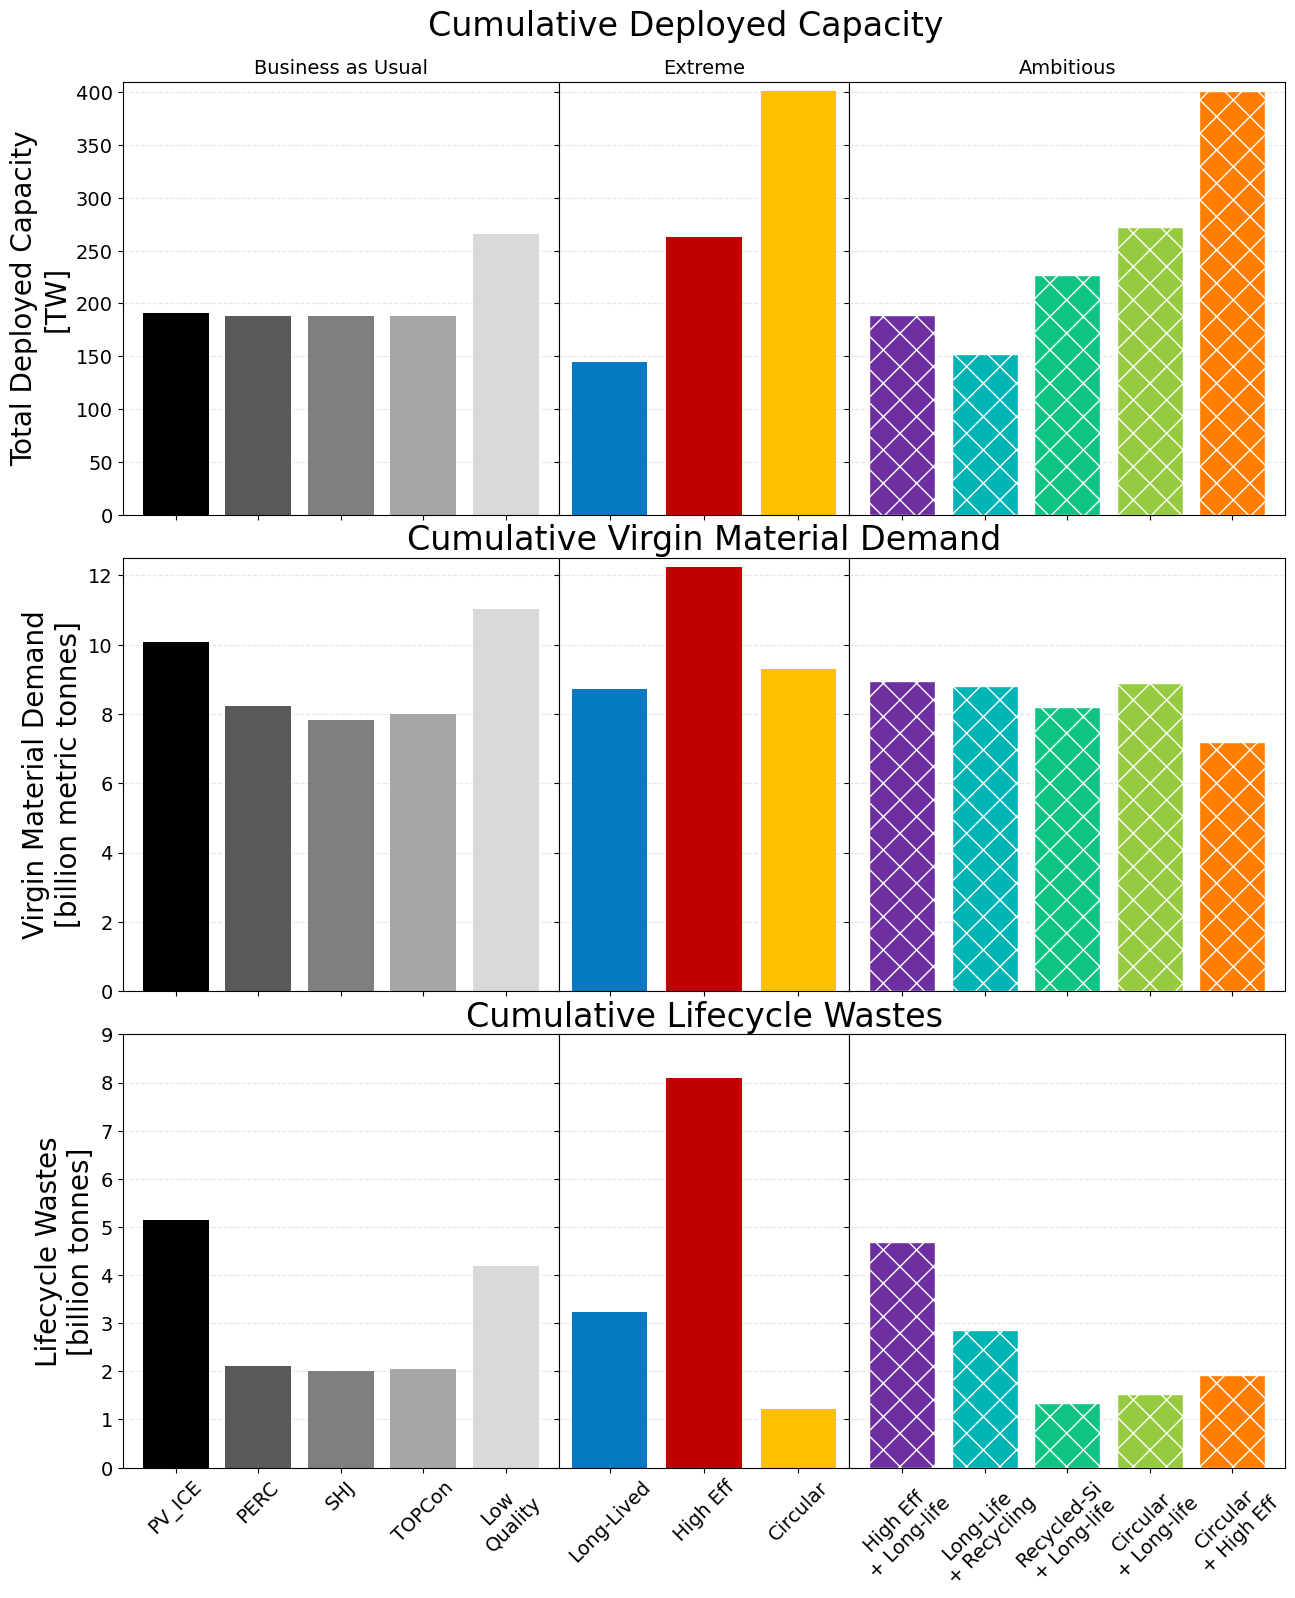

In [255]:
# Figure of cumulative capacity and mass metrics
fig_mat_cumu, axs = plt.subplots(3,3,figsize=(15,18),
                         gridspec_kw={'wspace': 0, 'hspace':0.1, 'width_ratios': [1.5,1,1.5]})

#Cumulative Installs-------------------------------------------------
#BAU
axs[0,0].bar(scennames_labels[0:5], cumu_installs.iloc[-1,0:5]/1e6,# width=0.1, 
        tick_label=scennames_labels[0:5], color=colorpalette[0:5])
axs[0,0].set_ylim(0,410)
axs[0,0].set_ylabel('Total Deployed Capacity\n[TW]', fontsize=20)
axs[0,0].set_title('Business as Usual', fontsize=14)
axs[0,0].set_xticklabels([])
axs[0,0].grid(axis='y', color='0.9', ls='--') 
axs[0,0].set_axisbelow(True)

#Extreme
axs[0,1].set_ylim(axs[0,0].get_ylim())
axs[0,1].bar(scennames_labels[5:8], cumu_installs.iloc[-1,5:8]/1e6, #width=0.8,
        tick_label=scennames_labels[5:8], color=colorpalette[5:8])
axs[0,1].set_title('Extreme', fontsize=14)
axs[0,1].set_xticklabels([])
axs[0,1].set_yticklabels([])
axs[0,1].grid(axis='y', color='0.9', ls='--') 
axs[0,1].set_axisbelow(True)

#Ambitious
axs[0,2].set_ylim(axs[0,0].get_ylim())
axs[0,2].bar(scennames_labels[8:], cumu_installs.iloc[-1,8:]/1e6, #width=0.8,
        tick_label=scennames_labels[8:], color=colorpalette[8:], hatch='x', edgecolor='white')
axs[0,2].set_title('Ambitious', fontsize=14)
axs[0,2].set_xticklabels([])
axs[0,2].set_yticklabels([])
axs[0,2].grid(axis='y', color='0.9', ls='--') 
axs[0,2].set_axisbelow(True)


#Virgin Material Demand-------------------------------------------
#BAU
axs[1,0].bar(scennames_labels[0:5], cumu_virgin_module_bt.iloc[-1,0:5],# width=0.1, 
        tick_label=scennames_labels[0:5], color=colorpalette[0:5])
axs[1,0].set_ylim(0,12.5)
axs[1,0].set_ylabel('Virgin Material Demand\n[billion metric tonnes]', fontsize=20)
#axs[1,0].set_title('Baseline', fontsize=14)
axs[1,0].set_xticklabels([])
axs[1,0].grid(axis='y', color='0.9', ls='--') 
axs[1,0].set_axisbelow(True)

#Extreme
axs[1,1].set_ylim(axs[1,0].get_ylim())
axs[1,1].bar(scennames_labels[5:8], cumu_virgin_module_bt.iloc[-1,5:8], #width=0.8,
        tick_label=scennames_labels[5:8], color=colorpalette[5:8])
axs[1,1].set_title('Cumulative Virgin Material Demand', fontsize=24)
axs[1,1].set_xticklabels([])
axs[1,1].set_yticklabels([])
axs[1,1].grid(axis='y', color='0.9', ls='--') 
axs[1,1].set_axisbelow(True)

#Ambitious
axs[1,2].set_ylim(axs[1,0].get_ylim())
axs[1,2].bar(scennames_labels[8:], cumu_virgin_module_bt.iloc[-1,8:], #width=0.8,
        tick_label=scennames_labels[8:], color=colorpalette[8:], hatch='x', edgecolor='white')
#axs[1,2].set_title('Ambitious', fontsize=14)
axs[1,2].set_xticklabels([])
axs[1,2].set_yticklabels([])
axs[1,2].grid(axis='y', color='0.9', ls='--') 
axs[1,2].set_axisbelow(True)

#Lifecycle Wastes-------------------------------------------------
#BAU
axs[2,0].bar(scennames_labels[0:5], cumu_lifecycle_wastes_bt.iloc[-1,0:5],# width=0.1, 
        tick_label=scennames_labels[0:5], color=colorpalette[0:5])
axs[2,0].set_ylim(0,9)
axs[2,0].set_ylabel('Lifecycle Wastes\n[billion tonnes]', fontsize=20)
#axs[2,0].set_title('Baseline', fontsize=14)
axs[2,0].set_xticklabels(labels=scennames_labels[0:5], rotation=45)
axs[2,0].grid(axis='y', color='0.9', ls='--') 
axs[2,0].set_axisbelow(True)

#Extreme
axs[2,1].set_ylim(axs[2,0].get_ylim())
axs[2,1].bar(scennames_labels[5:8], cumu_lifecycle_wastes_bt.iloc[-1,5:8], #width=0.8,
        tick_label=scennames_labels[5:8], color=colorpalette[5:8])
axs[2,1].set_title('Cumulative Lifecycle Wastes', fontsize=24)
axs[2,1].set_xticklabels(labels=scennames_labels[5:8], rotation=45)
axs[2,1].set_yticklabels([])
axs[2,1].grid(axis='y', color='0.9', ls='--') 
axs[2,1].set_axisbelow(True)

#Ambitious
axs[2,2].set_ylim(axs[2,0].get_ylim())
axs[2,2].bar(scennames_labels[8:], cumu_lifecycle_wastes_bt.iloc[-1,8:], #width=0.8,
        tick_label=scennames_labels[8:], color=colorpalette[8:], hatch='x', edgecolor='white')
#axs[2,2].set_title('Ambitious', fontsize=14)
axs[2,2].set_xticklabels(labels=scennames_labels[8:], rotation=45)
axs[2,2].set_yticklabels([])#yaxis.set_visible(False)
axs[2,2].grid(axis='y', color='0.9', ls='--') 
axs[2,2].set_axisbelow(True)

#Overall Figure
fig_mat_cumu.suptitle('Cumulative Deployed Capacity', fontsize=24, y=0.92)
fig_mat_cumu.savefig('energyresults-Cumu-CapMass.png', dpi=300, bbox_inches='tight')
fig_mat_cumu.show()

# RESULTS: Energy

## Energy Generation
Because of different bifi factors, they do NOT produce the same energy

#energyGen = allenergy.filter(like='e_out_annual')
plt.plot(energyGen/1e12)
plt.legend(scennames_labels)
plt.title('Annual Energy Generation')
plt.ylabel('Energy Generation [TWh]')
plt.ylim(0,)

## Annual Energy Demands through 2050
Increasing the steepness of the curve

In [256]:
e_annual_sumDemands = energy_demands.filter(like='demand_total')

plt.plot(e_annual_sumDemands/1e12)
plt.legend(scennames_labels_flat)
plt.title('Annual Energy Demands')
plt.ylabel('Energy Demands\n[TWh]')
plt.ylim(0,)
plt.xlim(2000,2050)

In [257]:
#ember electricity demand
world_elec_demand = pd.read_csv(os.path.join(altBaselinesfolder, 'ember-world-electricity-demand.csv'), index_col='year')
world_elec_demand_ssps = pd.read_csv(os.path.join(supportMatfolder, 'input-Keiner2023-globalElecDemandSSP15.csv'), index_col='year')

#Haegel energy demand research
#added 4 2050 datapoints to above DF
elec_2050 = pd.DataFrame({2050:[58000],2050:[103400],2050:[105000],2050:[85300],})
elec_2050

2050
0  85300

In [258]:
world_elec_demand_ssps.iloc[:,0:2] = world_elec_demand_ssps.iloc[:,0:2].interpolate()
world_elec_demand_ssps.head(5)

TotalElectricityDemand_SSP1_[PWh]  TotalElectricityDemand_SSP5_[PWh]  \
year                                                                         
2000                                NaN                                NaN   
2001                                NaN                                NaN   
2002                                NaN                                NaN   
2003                                NaN                                NaN   
2004                                NaN                                NaN   

      Global_Electricity_Demand_Ember  
year                                   
2000                         14.97179  
2001                         15.19635  
2002                         15.73318  
2003                         16.29211  
2004                         17.09314

In [259]:
#calculate percentage of world electricity demands
elec_mean_2050 = world_elec_demand.loc[2050,'Electricity_demand_twh'].mean()
idx_temp_edmd = pd.Series(range(2023,2051,1))
late_elec_demand = pd.DataFrame(columns=['Electricity_demand_twh'],index=idx_temp_edmd)
late_elec_demand.loc[2050] = elec_mean_2050
elec_demand_goal = pd.DataFrame(pd.concat([world_elec_demand.loc[:2022,'Electricity_demand_twh'],
                                           late_elec_demand.loc[:,'Electricity_demand_twh']]),
                               dtype=float)
elec_demand = elec_demand_goal.interpolate()

In [260]:
e_annual_sumDemands_PWh = e_annual_sumDemands/1e15
#FIX THIS CALC
prct_elec_demand_2050_ssp1 = e_annual_sumDemands_PWh/world_elec_demand_ssps['TotalElectricityDemand_SSP1_[PWh]']*100
prct_elec_demand_2050_ssp1.loc[2050]
prct_elec_demand_2050_ssp5 = e_annual_sumDemands_PWh/world_elec_demand_ssps['TotalElectricityDemand_SSP5_[PWh]']*100
prct_elec_demand_2050_ssp5.loc[2050]

2000                            NaN
2001                            NaN
2002                            NaN
2003                            NaN
2004                            NaN
                                 ..
h_RecycledPERC_e_demand_total   NaN
r_IRENA_e_demand_total          NaN
r_PERC_e_demand_total           NaN
r_SHJ_e_demand_total            NaN
r_TOPCon_e_demand_total         NaN
Name: 2050, Length: 114, dtype: float64

In [261]:
e_annual_sumDemands_TWh = e_annual_sumDemands/1e12
prct_elec_demand_2050 = e_annual_sumDemands_TWh.loc[:2050]/elec_demand.values*100
prct_elec_demand_2050.loc[2050]

PV_ICE_e_demand_total               4.562323
r_PERC_e_demand_total               4.271417
r_SHJ_e_demand_total                4.069461
r_TOPCon_e_demand_total             4.155767
r_IRENA_e_demand_total              5.564081
ex_Life_e_demand_total              4.404259
ex_High_eff_e_demand_total          3.964407
ex_Circular_e_demand_total          6.514088
h_EffLife_e_demand_total            3.870223
h_50PERC_e_demand_total             4.441628
h_RecycledPERC_e_demand_total       5.866432
h_Perovskite_life_e_demand_total    6.280710
h_Perovskite_Eff_e_demand_total     4.497918
Name: 2050, dtype: float64

In [262]:
sim1.scenario['r_IRENA'].material['glass'].matdataOut_e

mat_extraction  mat_MFG_virgin  mat_MFG_virgin_fuel  mat_MFGScrap_LQ  \
0      5.347604e+08    2.294971e+11         1.836114e+11     4.001527e+09   
1      1.894837e+08    8.035842e+10         6.428545e+10     1.417876e+09   
2      2.278207e+08    9.521559e+10         7.636298e+10     1.704746e+09   
3      3.453459e+08    1.422102e+11         1.143511e+11     2.584168e+09   
4      7.000218e+08    2.839568e+11         2.289496e+11     5.238152e+09   
..              ...             ...                  ...              ...   
96     1.158933e+12    3.939689e+14         3.419601e+14     8.932419e+12   
97     1.162286e+12    3.951085e+14         3.429493e+14     8.965865e+12   
98     1.165694e+12    3.962673e+14         3.439550e+14     8.999766e+12   
99     1.161507e+12    3.948438e+14         3.427195e+14     8.955588e+12   
100    1.162403e+12    3.951486e+14         3.429840e+14     8.962182e+12   

     mat_MFGScrap_HQ  mat_MFGScrap_HQ_fuel  mat_Landfill  mat_Landfill_fuel  \
0       4.001527e+08          2.000763e+08  1.929307e+08       1.504860e+08   
1       1.417876e+08          7.089380e+07  6.836193e+07       5.332230e+07   
2       1.704746e+08          8.523728e+07  8.219508e+07       6.411216e+07   
3       2.584168e+08          1.292084e+08  1.246104e+08       9.719611e+07   
4       5.238152e+08          2.619076e+08  2.526262e+08       1.970485e+08   
..               ...                   ...           ...                ...   
96      6.029383e+12          3.014691e+12  6.612601e+12       5.157829e+12   
97      6.051959e+12          3.025979e+12  6.643774e+12       5.182144e+12   
98      6.074842e+12          3.037421e+12  6.675302e+12       5.206736e+12   
99      6.045022e+12          3.022511e+12  6.632562e+12       5.173399e+12   
100     6.049473e+12          3.024737e+12  6.637179e+12       5.176999e+12   

     mat_EoL_ReMFG_clean  mat_Recycled_LQ  mat_Recycled_HQ  \
0                    0.0     0.000000e+00     0.000000e+00   
1                    0.0     4.176129e+01     2.505677e+00   
2                    0.0     1.707163e+03     1.024298e+02   
3                    0.0     1.421993e+04     8.531957e+02   
4                    0.0     6.223970e+04     3.734382e+03   
..                   ...              ...              ...   
96                   0.0     2.025177e+14     1.366995e+14   
97                   0.0     2.034741e+14     1.373450e+14   
98                   0.0     2.044414e+14     1.379980e+14   
99                   0.0     2.031298e+14     1.371126e+14   
100                  0.0     2.032711e+14     1.372080e+14   

     mat_Recycled_HQ_fuel  mat_Recycled_HQ_elec  
0            0.000000e+00          0.000000e+00  
1            1.252839e+00          1.252839e+00  
2            5.121490e+01          5.121490e+01  
3            4.265979e+02          4.265979e+02  
4            1.867191e+03          1.867191e+03  
..                    ...                   ...  
96           6.834973e+13          6.834973e+13  
97           6.867252e+13          6.867252e+13  
98           6.899899e+13          6.899899e+13  
99           6.855631e+13          6.855631e+13  
100          6.860400e+13          6.860400e+13  

[101 rows x 13 columns]

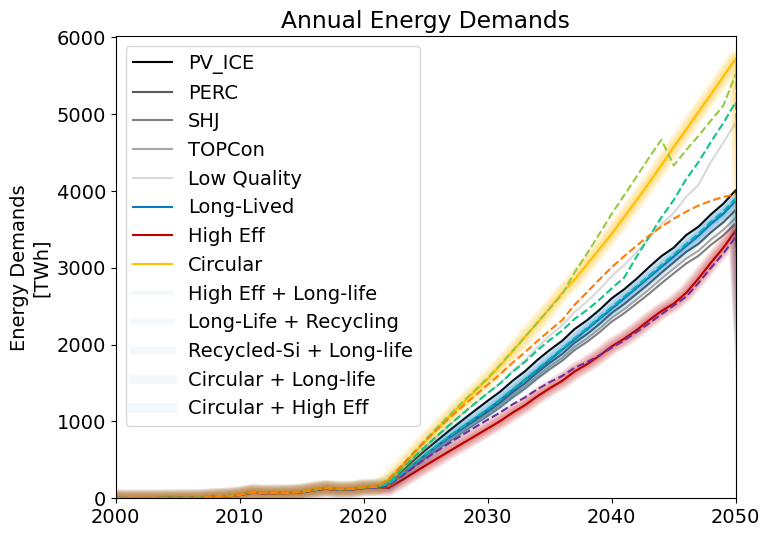

In [263]:
e_annual_sumDemands_TWh = e_annual_sumDemands/1e12

fig, ax1 = plt.subplots()

#world electricity demand
#ax1.plot(world_elec_demand.iloc[0:2022,0], label='Global Electricity Demand', ls='dashdot')

#BAU
ax1.plot(e_annual_sumDemands_TWh.iloc[:,0:5])

#Extreme
ax1.plot(e_annual_sumDemands_TWh.iloc[:,5:8])
#create glowlines for Extreme scens
n_lines = 10
diff_linewidth = 1.05
alpha_value = 0.05
for n in range(1, n_lines+1):
    ax1.plot(e_annual_sumDemands_TWh.iloc[:,5],
            linewidth=2+(diff_linewidth*n),
            alpha=alpha_value,
            color=colorpalette[5])

for n in range(1, n_lines+1):    
    ax1.plot(e_annual_sumDemands_TWh.iloc[:,6],
            linewidth=2+(diff_linewidth*n),
            alpha=alpha_value,
            color=colorpalette[6])

for n in range(1, n_lines+1):    
    ax1.plot(e_annual_sumDemands_TWh.iloc[:,7],
            linewidth=2+(diff_linewidth*n),
            alpha=alpha_value,
            color=colorpalette[7])

#Ambitious
ax1.plot(e_annual_sumDemands_TWh.iloc[:,8:], ls='--')

ax1.legend(scennames_labels_flat)
plt.title('Annual Energy Demands')
plt.ylabel('Energy Demands\n[TWh]')
plt.ylim(0,)
plt.xlim(2000,2050)

plt.show()

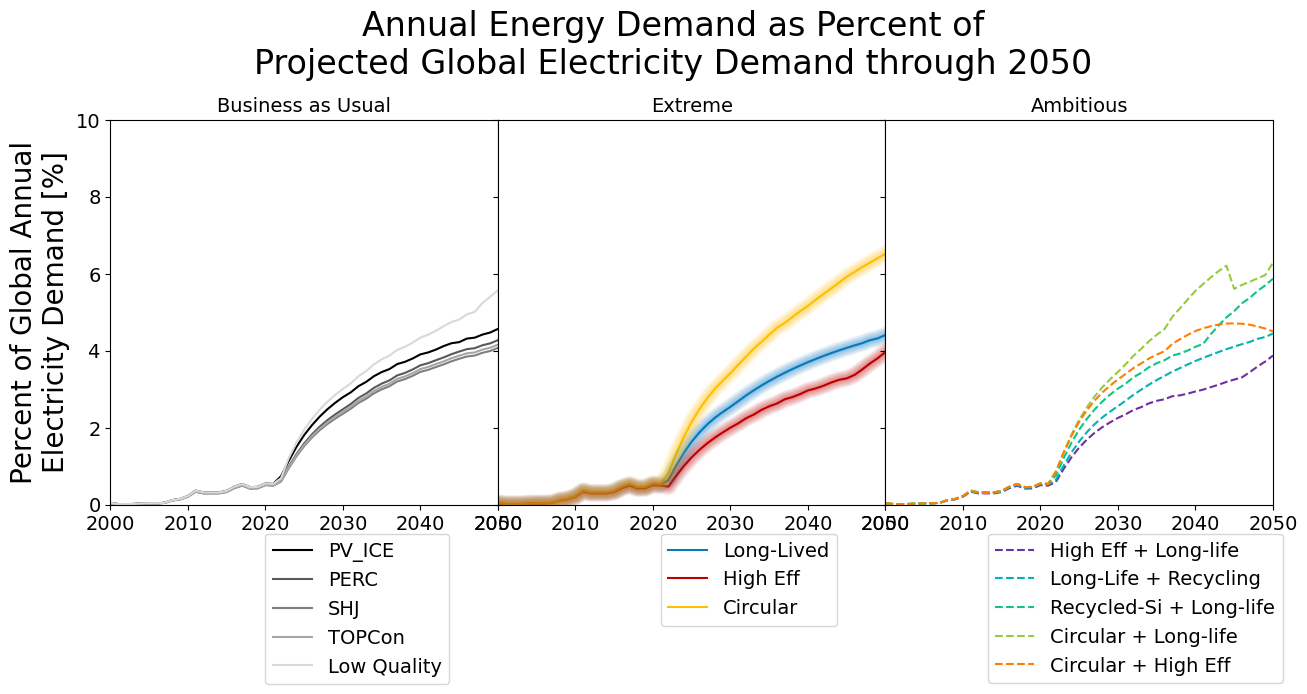

In [264]:
e_annual_demands_TWh = e_annual_sumDemands/1e12

fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(15,5), sharey=True, sharex=True, 
                                      gridspec_kw={'wspace':0})
#ax1.plot(world_elec_demand.iloc[:2022,0], label='Global Electricity Demand', ls='dashdot')
#ax1.scatter(x=2050, y=elec_2050.T, label='Global Electricity Demand')

#BAU
ax1.set_prop_cycle(color=colorpalette[0:5])
ax1.plot(prct_elec_demand_2050.iloc[:2050,0:5], label=scennames_labels_flat[0:5]) # baselines
ax1.set_title('Business as Usual', fontsize=14)
ax1.set_ylabel('Percent of Global Annual\nElectricity Demand [%]', fontsize=20)
ax1.set_xlim(2000,2050)
ax1.set_ylim(0,10)
ax1.legend(bbox_to_anchor=(0.9,-0.05))


#Extreme
#ax2.plot(world_elec_demand.iloc[:,0], label='Global Electricity Demand', ls='dashdot')
ax2.set_prop_cycle(color=colorpalette[5:8])
ax2.plot(prct_elec_demand_2050.iloc[:2050,5:8], label=scennames_labels_flat[5:8]) #, color=colorpalette[4:7])

#create glowlines for Extreme scens
n_lines = 10
diff_linewidth = 1.05
alpha_value = 0.05
for n in range(1, n_lines+1):    
    ax2.plot(prct_elec_demand_2050.iloc[:2050,5],
            linewidth=2+(diff_linewidth*n),
            alpha=alpha_value,
            color=colorpalette[5])

for n in range(1, n_lines+1):    
    ax2.plot(prct_elec_demand_2050.iloc[:2050,6],
            linewidth=2+(diff_linewidth*n),
            alpha=alpha_value,
            color=colorpalette[6])

for n in range(1, n_lines+1):    
    ax2.plot(prct_elec_demand_2050.iloc[:2050,7],
            linewidth=2+(diff_linewidth*n),
            alpha=alpha_value,
            color=colorpalette[7])

ax2.set_title('Extreme', fontsize=14)
ax2.legend(bbox_to_anchor=(0.9,-0.05))

#Ambitious
#ax3.plot(world_elec_demand.iloc[:,0], label='Global Electricity Demand', ls='dashdot')
ax3.set_prop_cycle(color=colorpalette[8:])
ax3.plot(prct_elec_demand_2050.iloc[:2050,8:], label=scennames_labels_flat[8:], ls='--')# 
ax3.set_title('Ambitious', fontsize=14)
ax3.legend(bbox_to_anchor=(1.05,-0.05)) #(x,y)

#overall figure
fig.suptitle('Annual Energy Demand as Percent of\nProjected Global Electricity Demand through 2050', fontsize=24, y=1.1)
plt.show()
fig.savefig('energyresults-annualEnergyDemands2050.png', dpi=300, bbox_inches='tight')

## Energy Demands

In [265]:
e_annual_sumDemands_cumu = e_annual_sumDemands.cumsum()

plt.bar(e_annual_sumDemands_cumu.columns, e_annual_sumDemands_cumu.loc[2100]/1e12, 
        tick_label=(scennames_labels), color=colorpalette)
plt.title('Cumulative Lifecycle Energy Demands')
plt.ylabel('Cumulative Energy Demands\n[TWh]')
plt.xticks(rotation=90)

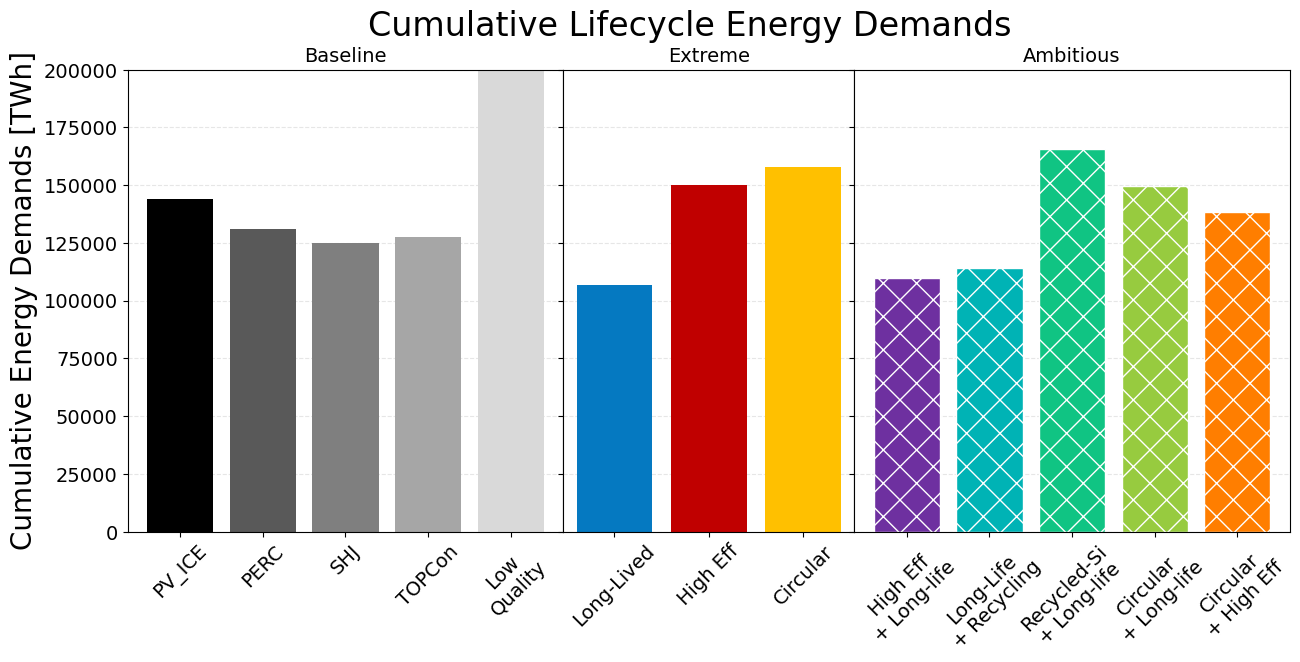

In [266]:
cumu_e_demands_twh = e_annual_sumDemands_cumu.loc[2100]/1e12
cumu_e_demands_twh.index = scennames_labels_flat

fig_eDemands, (ax0,ax2,ax3) = plt.subplots(1,3,figsize=(15,6), sharey=True, 
                                      gridspec_kw={'wspace': 0, 'width_ratios': [1.5,1,1.5]})
#BAU
ax0.bar(scennames_labels[0:5], cumu_e_demands_twh.iloc[0:5],# width=0.1, 
        tick_label=scennames_labels[0:5], color=colorpalette[0:5])
ax0.set_ylim(0,200000)
ax0.set_ylabel('Cumulative Energy Demands [TWh]', fontsize=20)
ax0.set_title('Baseline', fontsize=14)
ax0.set_xticklabels(labels=scennames_labels[0:5], rotation=45)
ax0.grid(axis='y', color='0.9', ls='--') 
ax0.set_axisbelow(True)

#Extreme
ax2.bar(scennames_labels[5:8], cumu_e_demands_twh.iloc[5:8], #width=0.8,
        tick_label=scennames_labels[5:8], color=colorpalette[5:8])
ax2.set_title('Extreme', fontsize=14)
ax2.set_xticklabels(labels=scennames_labels[5:8], rotation=45)
ax2.grid(axis='y', color='0.9', ls='--') 
ax2.set_axisbelow(True)

#Ambitious
ax3.bar(scennames_labels[8:], cumu_e_demands_twh.iloc[8:], #width=0.8,
        tick_label=scennames_labels[8:], color=colorpalette[8:], hatch='x', edgecolor='white')
ax3.set_title('Ambitious', fontsize=14)
ax3.set_xticklabels(labels=scennames_labels[8:], rotation=45)
ax3.grid(axis='y', color='0.9', ls='--') 
ax3.set_axisbelow(True)

#overall fig

fig_eDemands.suptitle('Cumulative Lifecycle Energy Demands', fontsize=24)
plt.show()

fig_eDemands.savefig('energyresults-energyDemands.png', dpi=300, bbox_inches='tight')

In [267]:
#select material demands that are not fuel
e_fuels = energy_demands.filter(like='_fuel')
e_energydemands = energy_demands.loc[:,~energy_demands.columns.isin(e_fuels.columns)]
#sum energy demands by material
e_mfging_bymat = pd.DataFrame()
for scen in sim1.scenario.keys():
    e_energy_mfg_scen = e_energydemands.filter(like=scen).filter(like='_MFG_')
    e_energy_mod_mfg_scen = energy_demands.filter(like=scen).filter(like='mod_MFG')
    e_mfging_bymat = pd.concat([e_mfging_bymat,e_energy_mfg_scen,e_energy_mod_mfg_scen], axis=1)

In [268]:
cum_e_mfging_bymat = e_mfging_bymat.cumsum().loc[2100]
cum_e_mfging_bymat

PV_ICE_glass_mat_MFG_virgin                         2.830129e+16
PV_ICE_silicon_mat_MFG_virgin                       6.254999e+16
PV_ICE_silver_mat_MFG_virgin                        4.701355e+14
PV_ICE_aluminium_frames_mat_MFG_virgin              1.991850e+16
PV_ICE_copper_mat_MFG_virgin                        8.627977e+13
                                                        ...     
h_Perovskite_Eff_aluminium_frames_mat_MFG_virgin    1.008780e+16
h_Perovskite_Eff_copper_mat_MFG_virgin              1.691510e+14
h_Perovskite_Eff_encapsulant_mat_MFG_virgin         4.328103e+15
h_Perovskite_Eff_backsheet_mat_MFG_virgin           2.728711e+13
h_Perovskite_Eff_mod_MFG                            5.144008e+15
Name: 2100, Length: 104, dtype: float64

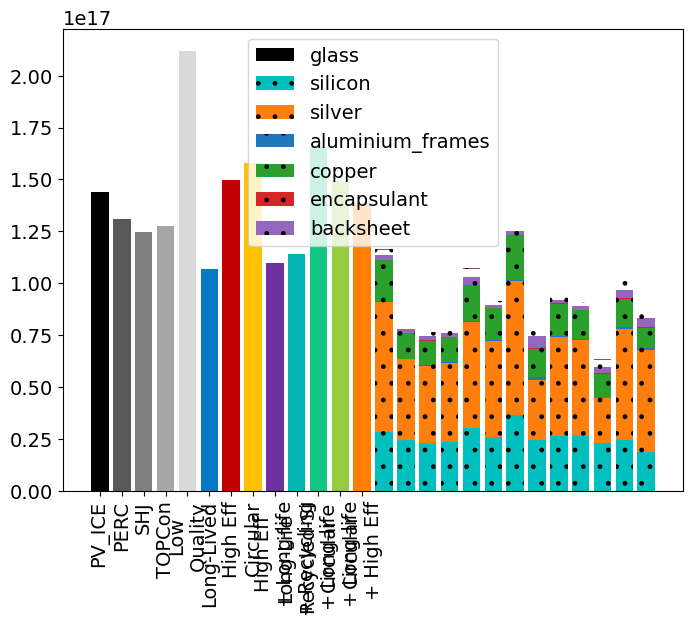

In [269]:
#run 2x rn??
#energy demands by material mfging
plt.bar(e_annual_sumDemands_cumu.columns, e_annual_sumDemands_cumu.loc[2100], 
        tick_label=(scennames_labels), color=colorpalette)

#Materials
cume_mfg_glass = cum_e_mfging_bymat.filter(like='glass')
cume_mfg_silicon = cum_e_mfging_bymat.filter(like='silicon')
cume_mfg_silver = cum_e_mfging_bymat.filter(like='silver')
cume_mfg_aluminium_frames = cum_e_mfging_bymat.filter(like='aluminium_frames')
cume_mfg_copper = cum_e_mfging_bymat.filter(like='copper')
cume_mfg_encapsulant = cum_e_mfging_bymat.filter(like='encapsulant')
cume_mfg_backsheet = cum_e_mfging_bymat.filter(like='backsheet')
cume_mfg_mod = cum_e_mfging_bymat.filter(like='mod')

bot_ag = cume_mfg_glass.values+cume_mfg_silicon.values
bot_al = cume_mfg_glass.values+cume_mfg_silicon.values+cume_mfg_silver.values
bot_cu = cume_mfg_glass.values+cume_mfg_silicon.values+cume_mfg_silver.values+cume_mfg_aluminium_frames.values
bot_encap = cume_mfg_glass.values+cume_mfg_silicon.values+cume_mfg_silver.values+cume_mfg_aluminium_frames.values+cume_mfg_copper.values
bot_back = cume_mfg_glass.values+cume_mfg_silicon.values+cume_mfg_silver.values+cume_mfg_aluminium_frames.values+cume_mfg_copper.values+cume_mfg_encapsulant.values
bot_mod = cume_mfg_glass.values+cume_mfg_silicon.values+cume_mfg_silver.values+cume_mfg_aluminium_frames.values+cume_mfg_copper.values+cume_mfg_encapsulant.values+cume_mfg_backsheet.values

plt.bar(scennames_labels, cume_mfg_glass, color = colormats[0], hatch='.')
plt.bar(scennames_labels, cume_mfg_silicon, bottom = cume_mfg_glass, color=colormats[1], hatch='.')
plt.bar(scennames_labels, cume_mfg_silver, bottom = bot_ag, color=colormats[2], hatch='.')
plt.bar(scennames_labels, cume_mfg_aluminium_frames, bottom = bot_al, color=colormats[3], hatch='.')
plt.bar(scennames_labels, cume_mfg_copper, bottom = bot_cu , color=colormats[4], hatch='.')
plt.bar(scennames_labels, cume_mfg_encapsulant, bottom = bot_encap ,color=colormats[5], hatch='.')
plt.bar(scennames_labels, cume_mfg_backsheet, bottom = bot_back, color=colormats[6], hatch='.')
plt.bar(scennames_labels, cume_mfg_mod, bottom = bot_back, color='white', hatch='.')

plt.xticks(rotation=90)

plt.legend(MATERIALS)

## Net Energy

In [270]:
energyGen_cumu = energyGen.cumsum()
energyGen_cumu.columns = e_annual_sumDemands_cumu.columns = scennames_labels_flat
netEnergy_cumu = energyGen_cumu.loc[[2100]] - e_annual_sumDemands_cumu.loc[[2100]]

In [271]:
e_annual_sumDemands_cumu.loc[[2100]]

PV_ICE          PERC           SHJ        TOPCon   Low Quality  \
year                                                                         
2100  1.440969e+17  1.310505e+17  1.248440e+17  1.274785e+17  2.119972e+17   

        Long-Lived      High Eff      Circular  High Eff + Long-life  \
year                                                                   
2100  1.068917e+17  1.499011e+17  1.577219e+17          1.098205e+17   

      Long-Life + Recycling  Recycled-Si + Long-life  Circular + Long-life  \
year                                                                         
2100           1.140960e+17             1.656784e+17          1.494029e+17   

      Circular + High Eff  
year                       
2100         1.385677e+17

In [272]:
netEnergy_cumu

PV_ICE          PERC           SHJ        TOPCon   Low Quality  \
year                                                                         
2100  7.043933e+18  7.560141e+18  7.710108e+18  7.635593e+18  6.976032e+18   

        Long-Lived      High Eff      Circular  High Eff + Long-life  \
year                                                                   
2100  7.332719e+18  7.699427e+18  7.030308e+18          7.739508e+18   

      Long-Life + Recycling  Recycled-Si + Long-life  Circular + Long-life  \
year                                                                         
2100           7.325515e+18             7.022351e+18          7.038627e+18   

      Circular + High Eff  
year                       
2100         7.049462e+18

plt.bar(netEnergy_cumu.columns, netEnergy_cumu.loc[2100]/1e12, 
        tick_label=(scennames_labels), color=colorpalette)
plt.title('Net Energy Cumulatively')
plt.ylabel('Cumulative Net Energy [TWh]')
#plt.ylim(4e6,5.5e6)
plt.xticks(rotation=90)

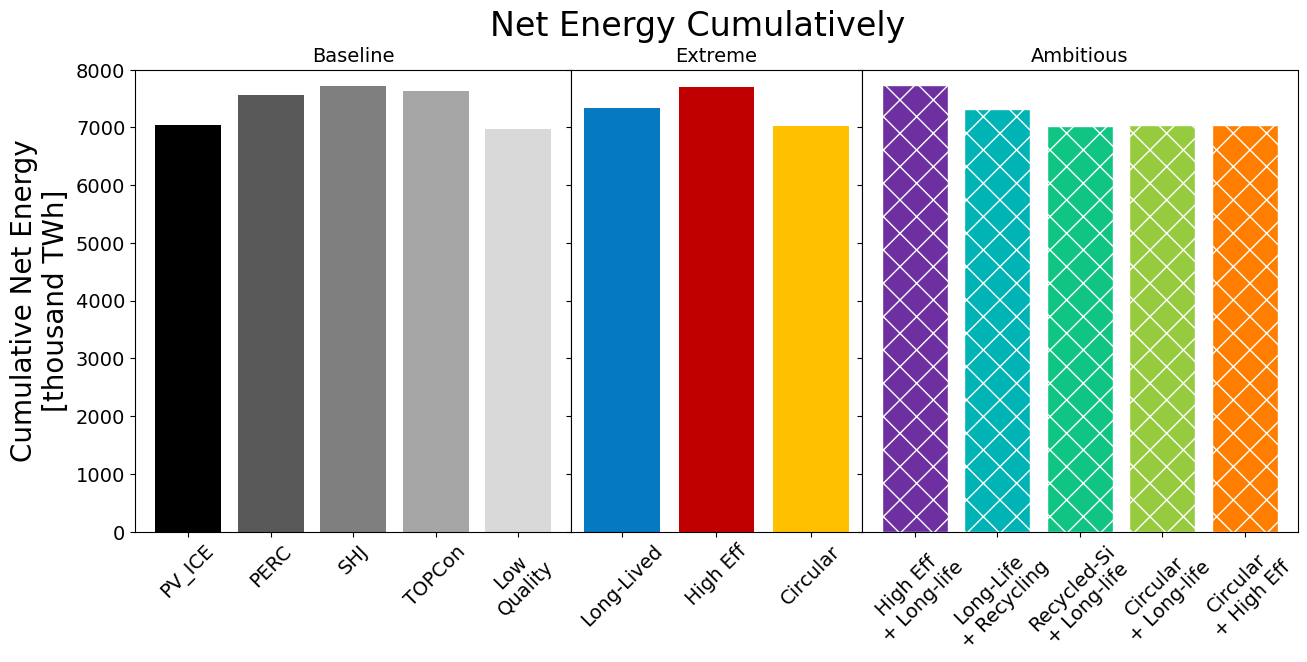

In [273]:
cumu_netEnergy_twh = netEnergy_cumu.loc[2100]/1e15

fig, (ax0,ax2,ax3) = plt.subplots(1,3,figsize=(15,6), sharey=True, 
                                      gridspec_kw={'wspace': 0, 'width_ratios': [1.5,1,1.5]})
#BAU
ax0.bar(scennames_labels[0:5], cumu_netEnergy_twh.iloc[0:5],# width=0.1, 
        tick_label=scennames_labels[0:5], color=colorpalette[0:5])
ax0.set_ylim(0,8000)
ax0.set_ylabel('Cumulative Net Energy\n[thousand TWh]', fontsize=20)
ax0.set_title('Baseline', fontsize=14)
ax0.set_xticklabels(labels=scennames_labels[0:5], rotation=45)

#Extreme
ax2.bar(scennames_labels[5:8], cumu_netEnergy_twh.iloc[5:8], #width=0.8,
        tick_label=scennames_labels[5:8], color=colorpalette[5:8])
ax2.set_title('Extreme', fontsize=14)
ax2.set_xticklabels(labels=scennames_labels[5:8], rotation=45)

#Ambitious
ax3.bar(scennames_labels[8:], cumu_netEnergy_twh.iloc[8:], #width=0.8,
        tick_label=scennames_labels[8:], color=colorpalette[8:], hatch='x', edgecolor='white')
ax3.set_title('Ambitious', fontsize=14)
ax3.set_xticklabels(labels=scennames_labels[8:], rotation=45)

#overall fig

fig.suptitle('Net Energy Cumulatively', fontsize=24)
plt.show()

fig.savefig('energyresults-cumuNetEnergy.png', dpi=300, bbox_inches='tight')

netEnergy_relative = netEnergy_cumu - netEnergy_cumu.loc[2100,'PV_ICE']
netEnergy_relative
plt.bar(netEnergy_relative.columns, netEnergy_relative.loc[2100]/1e12, 
        tick_label=(scennames_labels), color=colorpalette)
plt.title('Cumulatively Net Energy Relative to PV ICE')
plt.ylabel('Relative Cumulative Net Energy [TWh]')
plt.xticks(rotation=90)

In [274]:
netEnergy_cumu_norm = netEnergy_cumu/netEnergy_cumu.loc[2100,'PV_ICE']
netEnergy_cumu_norm_waterfall = netEnergy_cumu_norm-1
netEnergy_cumu_norm


PV_ICE      PERC       SHJ    TOPCon  Low Quality  Long-Lived  High Eff  \
year                                                                            
2100     1.0  1.073284  1.094574  1.083996      0.99036    1.040998  1.093058   

      Circular  High Eff + Long-life  Long-Life + Recycling  \
year                                                          
2100  0.998066              1.098748               1.039975   

      Recycled-Si + Long-life  Circular + Long-life  Circular + High Eff  
year                                                                      
2100                 0.996936              0.999247             1.000785

plt.bar(netEnergy_cumu.columns, netEnergy_cumu_norm_waterfall.loc[2100], 
        tick_label=(scennames_labels), color=colorpalette)
plt.title('Net Energy Cumulatively Relative to PV ICE')
plt.ylabel('Relative Cumulative Net Energy')
#plt.ylim(-0.026,0.005)
plt.plot(0.0, lw=2)
plt.xticks(rotation=90)

In [275]:
netEnergy_cumu_norm_waterfall

PV_ICE      PERC       SHJ    TOPCon  Low Quality  Long-Lived  High Eff  \
year                                                                            
2100     0.0  0.073284  0.094574  0.083996     -0.00964    0.040998  0.093058   

      Circular  High Eff + Long-life  Long-Life + Recycling  \
year                                                          
2100 -0.001934              0.098748               0.039975   

      Recycled-Si + Long-life  Circular + Long-life  Circular + High Eff  
year                                                                      
2100                -0.003064             -0.000753             0.000785

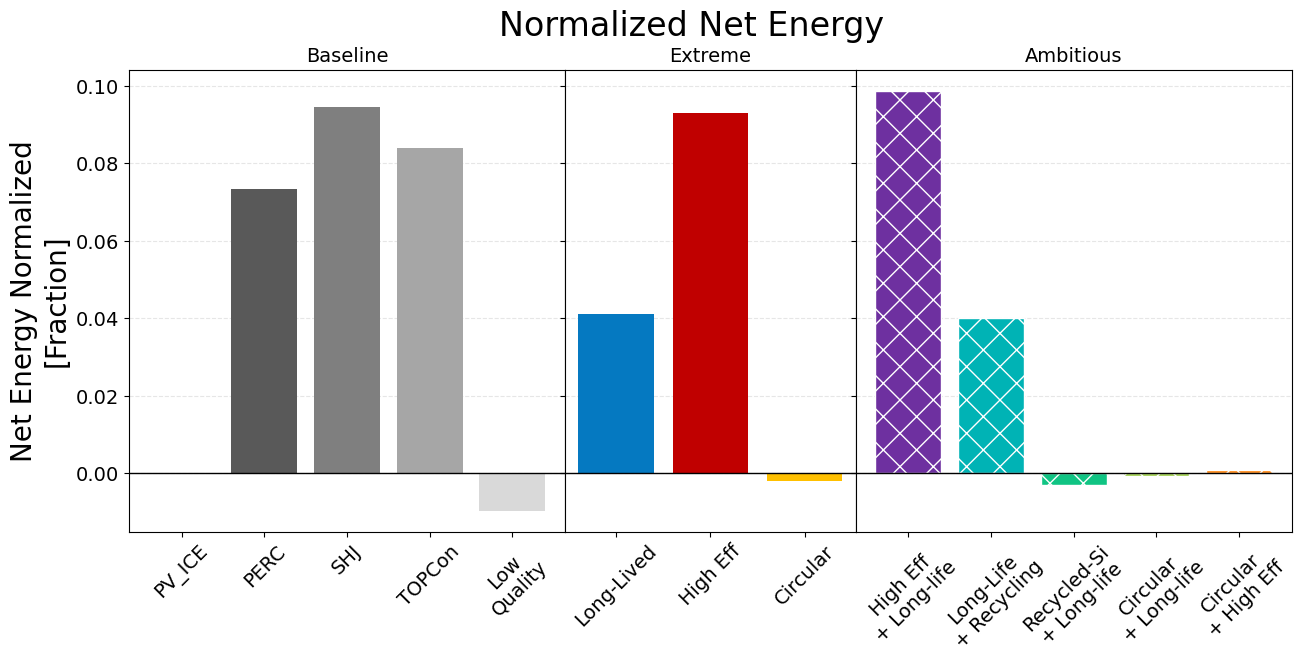

In [276]:

fig_eNetE, (ax0,ax2,ax3) = plt.subplots(1,3,figsize=(15,6), sharey=True, 
                                      gridspec_kw={'wspace': 0, 'width_ratios': [1.5,1,1.5]})
#BAU
ax0.bar(scennames_labels[0:5], netEnergy_cumu_norm_waterfall.iloc[-1,0:5],# width=0.1, 
        tick_label=scennames_labels[0:5], color=colorpalette[0:5])
#ax0.set_ylim(0,410)
ax0.set_ylabel('Net Energy Normalized\n[Fraction]', fontsize=20)
ax0.set_title('Baseline', fontsize=14)
ax0.set_xticklabels(labels=scennames_labels[0:5], rotation=45)
ax0.axhline(0, lw=1, color='black')
ax0.grid(axis='y', color='0.9', ls='--') 
ax0.set_axisbelow(True)

#Extreme
ax2.bar(scennames_labels[5:8], netEnergy_cumu_norm_waterfall.iloc[-1,5:8], #width=0.8,
        tick_label=scennames_labels[5:8], color=colorpalette[5:8])
ax2.set_title('Extreme', fontsize=14)
ax2.set_xticklabels(labels=scennames_labels[5:8], rotation=45)
ax2.axhline(0, lw=1, color='black')
ax2.grid(axis='y', color='0.9', ls='--') 
ax2.set_axisbelow(True)

#Ambitious
ax3.bar(scennames_labels[8:], netEnergy_cumu_norm_waterfall.iloc[-1,8:], #width=0.8,
        tick_label=scennames_labels[8:], color=colorpalette[8:], hatch='x', edgecolor='white')
ax3.set_title('Ambitious', fontsize=14)
ax3.set_xticklabels(labels=scennames_labels[8:], rotation=45)
ax3.grid(axis='y', color='0.9', ls='--') 
ax3.set_axisbelow(True)

#overall fig
ax3.axhline(0, lw=1, color='black')

fig_eNetE.suptitle('Normalized Net Energy', fontsize=24)
plt.show()

fig_eNetE.savefig('energyresults-cumuNetEnergyNorm.png', dpi=300, bbox_inches='tight')

In [277]:
netenergy_final = netEnergy_cumu.loc[2100]/1e12

In [278]:
energyGen.columns = e_annual_sumDemands.columns = scennames_labels_flat
annual_net_energy = energyGen - e_annual_sumDemands

plt.plot(annual_net_energy/1e12)
plt.legend(scennames_labels_flat)
plt.title('Annual Net Energy')
plt.ylabel('Net Energy (Eout - Ein)\n[TWh]')
plt.ylim(0,)
plt.xlim(2000,2100)

## Energy Balance
Inspired by EROI, this is all the energy generation divided by all the energy demanded for all systems deployed in energy transition. This is giving us an idea of our energy bang for energy buck

In [279]:
energyBalance_allyears = energyGen_cumu/e_annual_sumDemands_cumu

plt.bar(energyBalance_allyears.columns, energyBalance_allyears.loc[2100], 
        tick_label=(scennames_labels), color=colorpalette)
plt.title('Energy Balance')
plt.ylabel('Unitless')
plt.xticks(rotation=90)

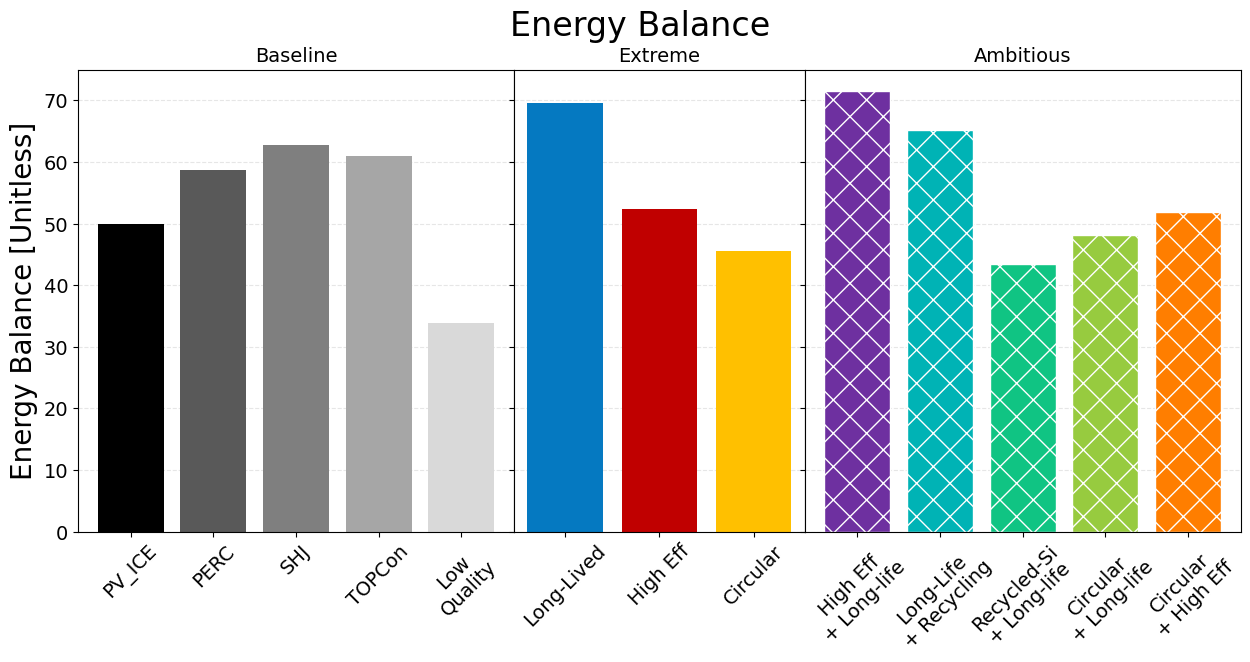

In [280]:
energyBalance = energyBalance_allyears.loc[2100]

fig_eBalance, (ax0,ax2,ax3) = plt.subplots(1,3,figsize=(15,6), sharey=True, 
                                      gridspec_kw={'wspace': 0, 'width_ratios': [1.5,1,1.5]})
#BAU
ax0.bar(scennames_labels[0:5], energyBalance.iloc[0:5],# width=0.1, 
        tick_label=scennames_labels[0:5], color=colorpalette[0:5])
ax0.set_ylim(0,75)
ax0.set_ylabel('Energy Balance [Unitless]', fontsize=20)
ax0.set_title('Baseline', fontsize=14)
ax0.set_xticklabels(labels=scennames_labels[0:5], rotation=45)
ax0.grid(axis='y', color='0.9', ls='--') 
ax0.set_axisbelow(True)

#Extreme
ax2.bar(scennames_labels[5:8], energyBalance.iloc[5:8], #width=0.8,
        tick_label=scennames_labels[5:8], color=colorpalette[5:8])
ax2.set_title('Extreme', fontsize=14)
ax2.set_xticklabels(labels=scennames_labels[5:8], rotation=45)
ax2.grid(axis='y', color='0.9', ls='--') 
ax2.set_axisbelow(True)

#Ambitious
ax3.bar(scennames_labels[8:], energyBalance.iloc[8:], #width=0.8,
        tick_label=scennames_labels[8:], color=colorpalette[8:], hatch='x', edgecolor='white')
ax3.set_title('Ambitious', fontsize=14)
ax3.set_xticklabels(labels=scennames_labels[8:], rotation=45)
ax3.grid(axis='y', color='0.9', ls='--') 
ax3.set_axisbelow(True)

#overall fig

fig_eBalance.suptitle('Energy Balance', fontsize=24)
plt.show()

fig_eBalance.savefig('energyresults-energyBalance.png', dpi=300, bbox_inches='tight')

fig_eDemands
fig_eNetE
fig_eBalance

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_22336\866380601.py:104: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig_e_cumu.show()


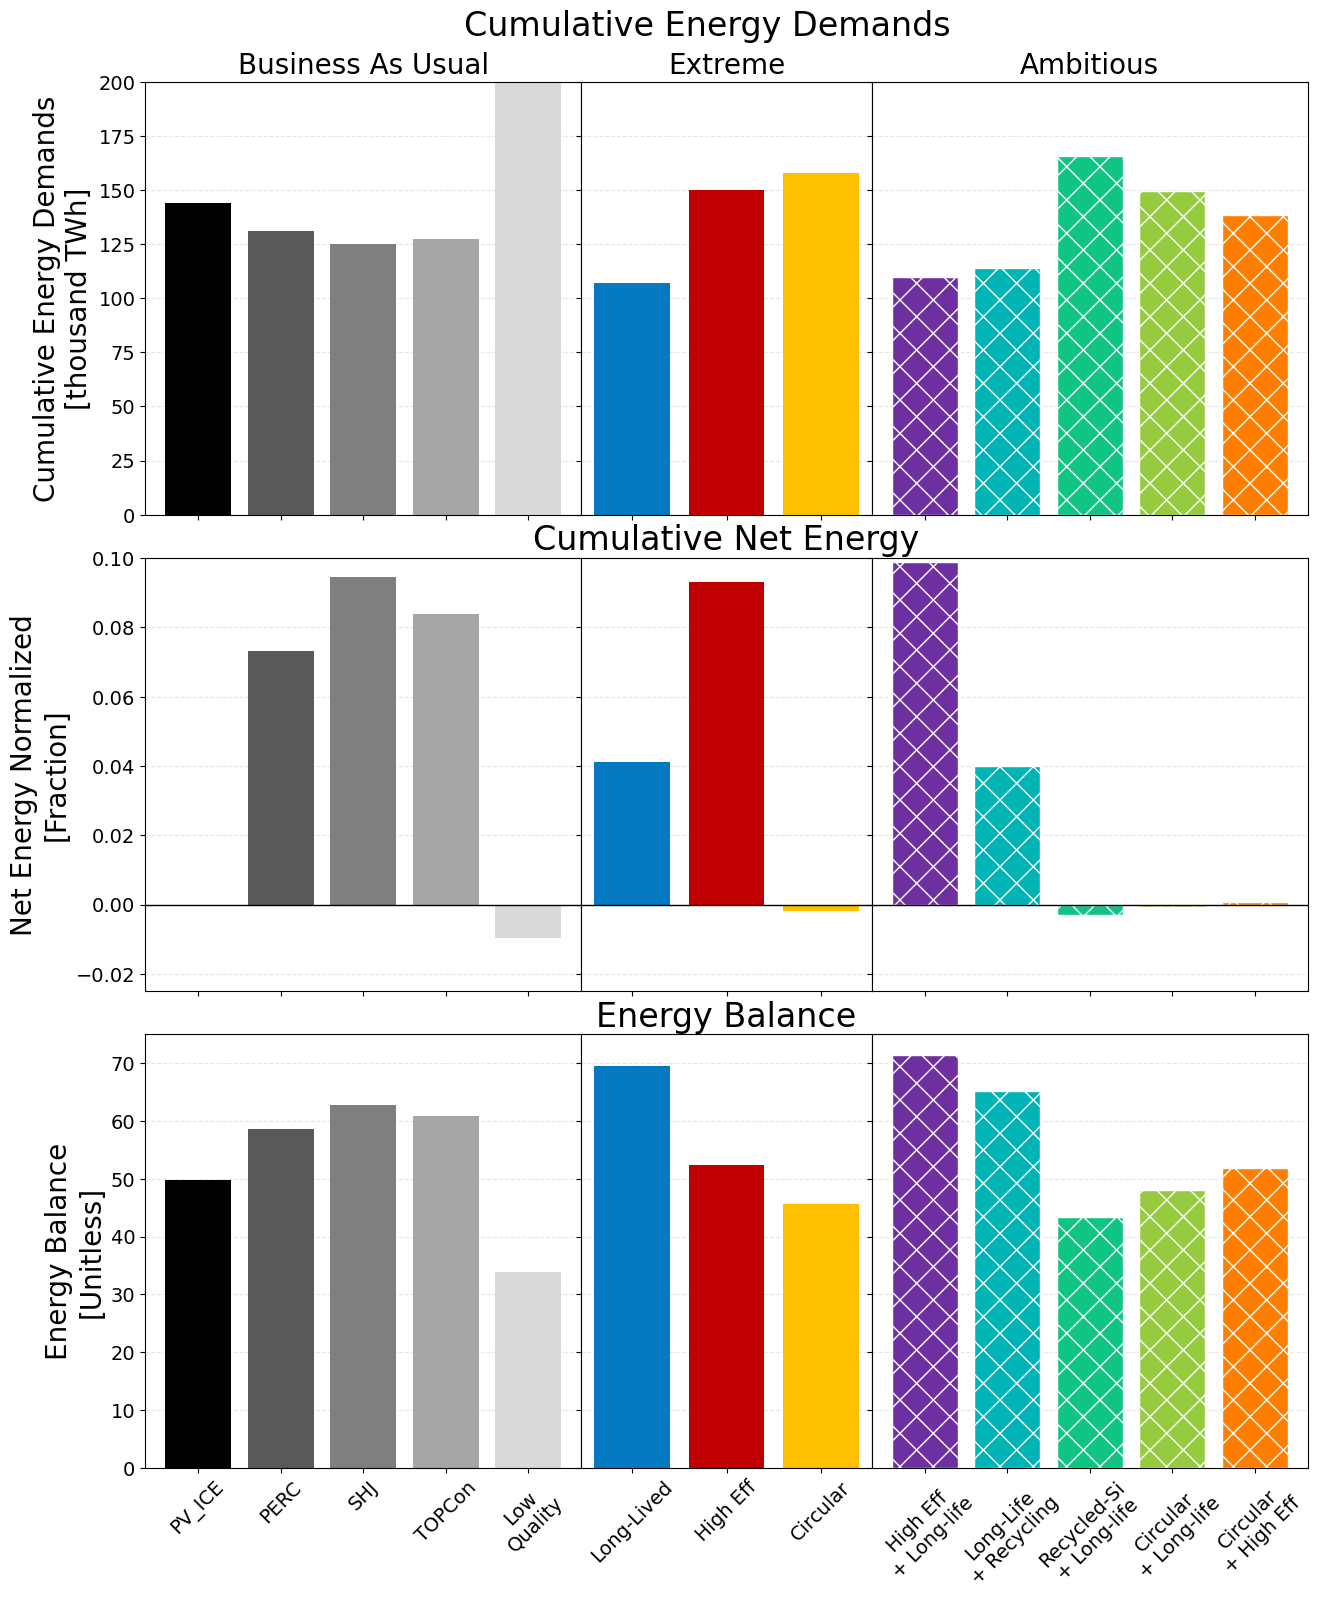

In [281]:
#cumulative energy figure
fig_e_cumu, axs = plt.subplots(3,3,figsize=(15,18),
                         gridspec_kw={'wspace': 0, 'hspace':0.1, 'width_ratios': [1.5,1,1.5]})

#Energy Demands
#BAU
axs[0,0].bar(scennames_labels[0:5], cumu_e_demands_twh.iloc[0:5]/1e3,# width=0.1, 
        color=colorpalette[0:5])
axs[0,0].set_ylim(0,200)
axs[0,0].set_ylabel('Cumulative Energy Demands\n[thousand TWh]', fontsize=20)
axs[0,0].set_title('Business As Usual', fontsize=20)
axs[0,0].set_xticklabels([])
#axs[0,0].yaxis.set_minor_locator(MultipleLocator(0.05))
axs[0,0].grid(axis='y', color='0.9', ls='--') 
axs[0,0].set_axisbelow(True)

#Extreme
axs[0,1].bar(scennames_labels[5:8], cumu_e_demands_twh.iloc[5:8]/1e3, #width=0.8,
        color=colorpalette[5:8])
axs[0,1].set_title('Extreme', fontsize=20)
axs[0,1].set_ylim(axs[0,0].get_ylim())#, visible=False)#sharey(axs[0, 0])
axs[0,1].set_xticklabels([])
axs[0,1].set_yticklabels([])#yaxis.set_visible(False)
axs[0,1].grid(axis='y', color='0.9', ls='--') 
axs[0,1].set_axisbelow(True)

#Ambitious
axs[0,2].bar(scennames_labels[8:], cumu_e_demands_twh.iloc[8:]/1e3, #width=0.8,
        color=colorpalette[8:], hatch='x', edgecolor='white')
axs[0,2].set_title('Ambitious', fontsize=20)
axs[0,2].set_ylim(axs[0,0].get_ylim())#, visible=False)
axs[0,2].set_xticklabels([])
axs[0,2].set_yticklabels([])#yaxis.set_visible(False)
axs[0,2].grid(axis='y', color='0.9', ls='--') 
axs[0,2].set_axisbelow(True)

#Net Energy------------------------------------------------------
#BAU
axs[1,0].bar(scennames_labels[0:5], netEnergy_cumu_norm_waterfall.iloc[-1,0:5],# width=0.1, 
             color=colorpalette[0:5])
axs[1,0].set_ylim(-0.025,0.1)
axs[1,0].set_ylabel('Net Energy Normalized\n[Fraction]', fontsize=20)
axs[1,0].set_xticklabels([])
axs[1,0].axhline(0, lw=1, color='black')
axs[1,0].grid(axis='y', color='0.9', ls='--') 
axs[1,0].set_axisbelow(True)

#Extreme
axs[1,1].bar(scennames_labels[5:8], netEnergy_cumu_norm_waterfall.iloc[-1,5:8], #width=0.8,
        color=colorpalette[5:8])
axs[1,1].set_ylim(axs[1,0].get_ylim())
axs[1,1].set_xticklabels([])
axs[1,1].axhline(0, lw=1, color='black')
axs[1,1].set_yticklabels([])#yaxis.set_visible(False)
axs[1,1].grid(axis='y', color='0.9', ls='--') 
axs[1,1].set_axisbelow(True)

axs[1,1].set_title('Cumulative Net Energy', fontsize=24)

#Ambitious
axs[1,2].bar(scennames_labels[8:], netEnergy_cumu_norm_waterfall.iloc[-1,8:], #width=0.8,
        color=colorpalette[8:], hatch='x', edgecolor='white')
axs[1,2].set_ylim(axs[1,0].get_ylim())
axs[1,2].set_xticklabels([])
axs[1,2].set_yticklabels([])#yaxis.set_visible(False)
axs[1,2].grid(axis='y', color='0.9', ls='--') 
axs[1,2].set_axisbelow(True)

#overall fig
axs[1,2].axhline(0, lw=1, color='black')

#Energy Balance------------------------------------------------
#BAU
axs[2,0].bar(scennames_labels[0:5], energyBalance.iloc[0:5],# width=0.1, 
        tick_label=scennames_labels[0:5], color=colorpalette[0:5])
axs[2,0].set_ylim(0,75)
axs[2,0].set_ylabel('Energy Balance\n[Unitless]', fontsize=20)
axs[2,0].set_xticklabels(labels=scennames_labels[0:5], rotation=45)
axs[2,0].grid(axis='y', color='0.9', ls='--') 
axs[2,0].set_axisbelow(True)

#Extreme
axs[2,1].bar(scennames_labels[5:8], energyBalance.iloc[5:8], #width=0.8,
        tick_label=scennames_labels[5:8], color=colorpalette[5:8])
axs[2,1].set_ylim(axs[2,0].get_ylim())
axs[2,1].set_xticklabels(labels=scennames_labels[5:8], rotation=45)
axs[2,1].set_title('Energy Balance', fontsize=24)
axs[2,1].set_yticklabels([])#yaxis.set_visible(False)
axs[2,1].grid(axis='y', color='0.9', ls='--') 
axs[2,1].set_axisbelow(True)

#Ambitious
axs[2,2].bar(scennames_labels[8:], energyBalance.iloc[8:], #width=0.8,
        tick_label=scennames_labels[8:], color=colorpalette[8:], hatch='x', edgecolor='white')
axs[2,2].set_ylim(axs[2,0].get_ylim())
axs[2,2].set_xticklabels(labels=scennames_labels[8:], rotation=45)
axs[2,2].set_yticklabels([])#yaxis.set_visible(False)
axs[2,2].grid(axis='y', color='0.9', ls='--') 
axs[2,2].set_axisbelow(True)

#overall fig
fig_e_cumu.suptitle('Cumulative Energy Demands', fontsize=24, y=0.92)
fig_e_cumu.savefig('energyresults-AllEnergyMetrics.png', dpi=300, bbox_inches='tight')
fig_e_cumu.show()

### Discussion summary table

In [282]:
discussTable = pd.concat([total_deploy,virgin,wastes, cumu_e_demands_twh,netenergy_final,energyBalance], axis=1,
         keys=['replacements','virgin','wastes','energydemand','netenergy','energybalance'])
discussTable.to_csv(os.path.join(testfolder,'discussiontable.csv'))
discussTable

replacements     virgin    wastes   energydemand  \
PV_ICE                     190.661154  10.086320  5.139612  144096.948146   
PERC                       187.845809   8.231230  2.112444  131050.540947   
SHJ                        187.845808   7.826973  2.009416  124844.038485   
TOPCon                     187.845809   7.993722  2.051980  127478.540049   
Low Quality                265.309534  11.016047  4.185460  211997.224101   
Long-Lived                 144.809344   8.724813  3.224156  106891.733718   
High Eff                   262.521124  12.232932  8.088472  149901.133556   
Circular                   401.428223   9.292273  1.213731  157721.945763   
High Eff + Long-life       189.441187   8.954969  4.695228  109820.473236   
Long-Life + Recycling      152.478197   8.809286  2.863773  114095.990131   
Recycled-Si + Long-life    226.993873   8.210236  1.345835  165678.360693   
Circular + Long-life       271.977799   8.879959  1.531751  149402.895055   
Circular + High Eff        401.428223   7.184763  1.919526  138567.700036   

                            netenergy  energybalance  
PV_ICE                   7.043933e+06      49.883289  
PERC                     7.560141e+06      58.688744  
SHJ                      7.710108e+06      62.757920  
TOPCon                   7.635593e+06      60.897088  
Low Quality              6.976032e+06      33.906244  
Long-Lived               7.332719e+06      69.599495  
High Eff                 7.699427e+06      52.363368  
Circular                 7.030308e+06      45.574061  
High Eff + Long-life     7.739508e+06      71.474180  
Long-Life + Recycling    7.325515e+06      65.204839  
Recycled-Si + Long-life  7.022351e+06      43.385446  
Circular + Long-life     7.038627e+06      48.111716  
Circular + High Eff      7.049462e+06      51.873775